In [390]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [391]:
os.listdir()

['.config',
 'hour Vs temp Residuals Analysis.jpg',
 'month Vs temp Residuals Analysis.jpg',
 'Humidity_Temp_Prediction.csv',
 'humidity Vs temp Residuals Analysis.jpg',
 'minute Vs temp Residuals Analysis.jpg',
 'sample_data']

Prepare data

In [392]:
def get_data(file_path="Humidity_Temp_Prediction.csv"):
  data = pd.read_csv(file_path, delimiter=';', parse_dates=['date_time'])
  data['minute'] = data['date_time'].dt.minute
  data['hour']   = data['date_time'].dt.hour
  data['minute'] = data['minute'] + data['hour']*60
  data['month']  = data['date_time'].dt.month

  return data

In [393]:
def normalize(x):
  mean = np.mean(x, axis=0, keepdims=True)
  std = np.std(x, axis=0, keepdims=True)
  return (x - mean)/std

Support function to train polynomial regression model

In [394]:
def init_w(degree):
  """
  Input the degree of polynomial model (for X)
  """
  weights = np.random.randn(degree, 1)
  bias = np.random.randn(1)
  return weights, bias

In [395]:
def add_features(x, degree):
  """
  Input x: numpy array of 1 feature
  Output X_poly: numpy array of polynomial of that 1 feature, level = degree
  """
  X_poly = np.zeros((len(x), degree))
  for i in range(len(x)):
    for j in range(degree):
      X_poly[i, j] = x[i, 0] ** (j + 1)
  return X_poly

In [396]:
def split_dataset(X, y, test_size=0.2):
  """
  Input X, y: numpy array
  Output X_train, y_train, X_test, y_test are numpy arrays
  """
  indices = np.arange(len(X))
  np.random.shuffle(indices)
  train_indices = indices[ : -int(test_size * len(X))]
  test_indices = indices[-int(test_size * len(X)) : ]

  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]

  return X_train, X_test, y_train, y_test

In [397]:
def mse_loss(y_true, y_pred):
  return np.mean((y_true - y_pred)**2)

In [398]:
def prepare_batches(x, y, batch_size=32):
  """
  input x, y as shuffled numpy arrays
  prepare mini batches of x and corresponding y
  """
  x_batch_list = list()
  y_batch_list = list()

  for i in range(len(y) // batch_size):
    x_batch_list.append(x[i*batch_size : i*batch_size + batch_size, :])
    y_batch_list.append(y[i*batch_size : i*batch_size + batch_size])

  if len(y) % batch_size > 0:
    x_batch_list.append(x[(len(y) // batch_size)*batch_size : , :])
    y_batch_list.append(y[(len(y) // batch_size)*batch_size :])

  batch_num = len(x_batch_list)

  return x_batch_list, y_batch_list, batch_num

In [399]:
def poly_reg_fit(X, Y, lr=0.001, epochs=100, batch_size=32, patience=3):
  """
  Input x_train and y_train: np array - data raw of 1 feature and corresponding y values
  X_train should be transformed before!
  output weight w and loss history using mini-batch gradient descent
  """
  # prepare train and validation data
  x_train, x_val, y_train, y_val = split_dataset(X, Y, test_size=0.25)

  train_losses = []
  val_losses = []

  # prepare mini-batch gradient descent training
  x_batches, y_batches, n_batches = prepare_batches(x_train, y_train, batch_size=batch_size)

  # prepare early stopping
  patience_counter = 0

  # prepare for training
  weights, bias = init_w(degree)
  # weights = np.array([0, 1, 1, 0])
  best_w = None
  best_b = None
  best_val_loss = float('inf')

  for epoch in tqdm(range(epochs)):
    epoch_avg_train_loss = 0
    for i in range(n_batches):
      x = x_batches[i]
      y = y_batches[i]

      y_pred = np.dot(x, weights) + bias
      loss = mse_loss(y, y_pred)
      train_losses.append(loss)
      epoch_avg_train_loss += loss

      dw = -2 * (np.dot(x.T, (y - y_pred))) / len(x)
      db = -2 * np.sum(y - y_pred) / len(x)
      weights -= lr * dw
      bias -= lr * db

    epoch_avg_train_loss  = epoch_avg_train_loss / n_batches

    # validation for each epoch
    y_val_pred = np.dot(x_val, weights) + bias
    val_loss = mse_loss(y_val, y_val_pred)
    val_losses.append(val_loss)

    print('Epoch {} | train_loss={:.3f} | val_loss={:.3f}'.format(epoch, epoch_avg_train_loss, val_loss))

    # early stopping check
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_w = weights.copy()
      best_b = bias.copy()
      patience_counter = 0
    else:
      patience_counter += 1

    if patience_counter >= patience:
      print('Early stopping at epoch {}'.format(epoch))
      break

  return best_w, best_b, train_losses, val_losses

Support functions for data and predict result visualization

In [400]:
def SensorViz(df, feature_X, feature_y):
    plt.figure(figsize=(18,5))
    plt.scatter(df[feature_X],df[feature_y])
    plt.plot(df[feature_X],df[feature_y])
    plt.title(f'{feature_X} Vs {feature_y}', size = 20)
    plt.xlabel(feature_X, size = 20)
    plt.ylabel(feature_y, size = 20)
    plt.grid()

In [401]:
def SensorVizWithPrediction(df, feature_X, feature_y, y_predict):
    plt.figure(figsize=(18,5))
    plt.scatter(df[feature_X],df[feature_y])
    plt.plot(df[feature_X],df[feature_y])
    plt.plot(df[feature_X], y_predict, color = 'red', linewidth=5)
    plt.title(f'{feature_X} Vs {feature_y}', size = 20)
    plt.xlabel(feature_X, size = 20)
    plt.ylabel(feature_y, size = 20)
    plt.grid()

Model assessment functions

In [402]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

def assess_model(X, y, y_predict, feature_X, feature_y):
  Rsquare2 = r2_score(y, y_predict)
  MSE = mean_squared_error(y, y_predict)
  RMSE = mean_squared_error(y, y_predict, squared = False) # If True returns MSE value, if False returns RMSE value.
  MAE = mean_absolute_error(y, y_predict)

  print(f"Rsquare2 : {Rsquare2}")
  print(f"Mean Square Error : {MSE}")
  print(f"Root Mean Square Error : {RMSE}")
  print(f"Mean Absolute Error : {MAE}")

  residuals = y - y_predict
  plt.figure(figsize=(20,5))
  sns.displot(residuals)
  plt.axvline(x = np.mean(residuals), color = 'red', label = 'mean')
  plt.axvline(x = np.median(residuals), color = 'orange', label = 'median')
  plt.xlabel("Residuals")
  plt.legend(loc = "upper right")
  plt.savefig(f"{feature_X} Vs {feature_y} Residuals Analysis.jpg")
  plt.show()

  std = np.std(residuals)
  y_predict_upBound = y_predict + 3*std
  y_predict_lowBound = y_predict - 3*std

  plt.figure(figsize=(18, 5))
  plt.scatter(X,y, color = "blue")
  plt.plot(X, y_predict, color = "red", linewidth = 5)
  plt.plot(X, y_predict_upBound, color = "green", linewidth = 1)
  plt.plot(X, y_predict_lowBound, color = "green", linewidth = 1)
  plt.title(f"{feature_X} vs {feature_y}")
  plt.xlabel(feature_X, size = 15)
  plt.ylabel(feature_y, size = 15)
  plt.show()

MAIN PROGRAM

In [403]:
data = get_data()
data.head()

,id,temp,humidity,date_time,minute,hour,month
0,9197,21,20,2016-08-17 00:00:01,0,0,8
1,9198,21,20,2016-08-17 00:01:01,1,0,8
2,9199,21,20,2016-08-17 00:02:01,2,0,8
3,9200,21,20,2016-08-17 00:03:01,3,0,8
4,9201,21,20,2016-08-17 00:04:01,4,0,8


In [404]:
features = data.drop(['id', 'date_time'], axis=1)
features.describe()

,temp,humidity,minute,hour,month
count,619999.000000,619999.000000,619999.000000,619999.000000,619999.000000
mean,19.365405,41.340391,715.723067,11.436893,7.460789
std,1.523185,32.418998,417.192832,6.946960,3.360717
min,15.000000,16.000000,0.000000,0.000000,1.000000
25%,18.000000,20.000000,354.000000,5.000000,5.000000
50%,19.000000,21.000000,711.000000,11.000000,8.000000
75%,20.000000,95.000000,1079.000000,17.000000,10.000000
max,28.000000,95.000000,1439.000000,23.000000,12.000000


Pair 1: humidity and temp

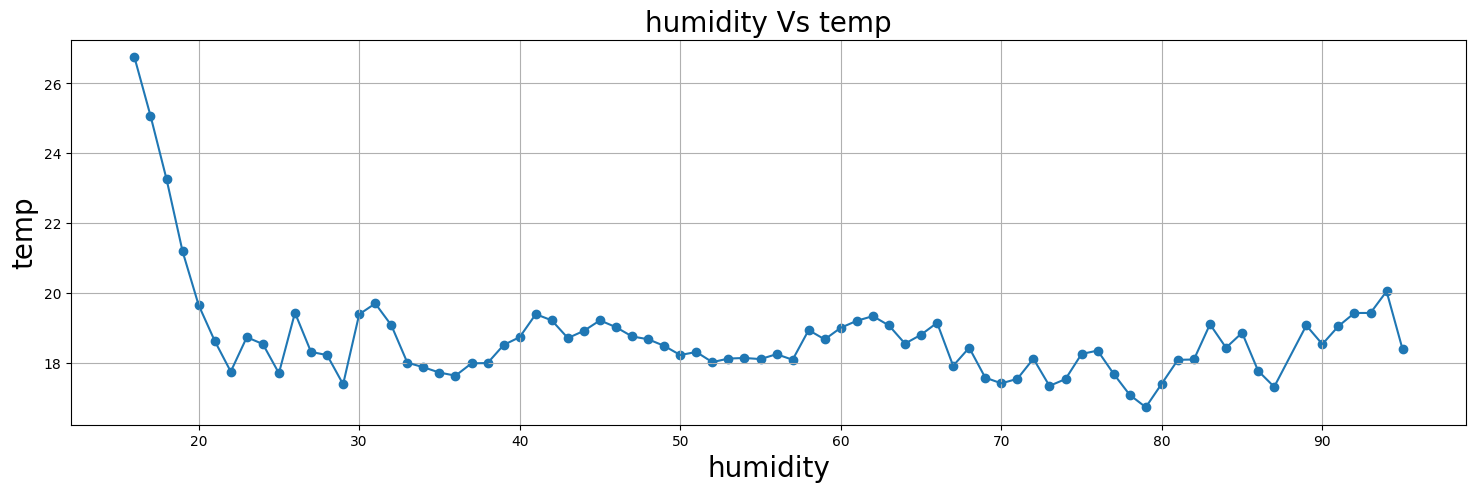

In [405]:
feature_y = 'temp'
feature_X = 'humidity'

df_pair1 = features[[feature_X, feature_y]].groupby(feature_X, as_index=False).mean()
SensorViz(df_pair1, feature_X, feature_y)

In [406]:
# Define hyper-parameters for training model
epochs = 10000
learning_rate = 0.001
degree = 11
batch_size = 32
patience = 5 # for early stopping

# Prepare data for training
X1 = df_pair1[[feature_X]].values
y1 = df_pair1[[feature_y]].values.reshape(-1, 1)

print(type(X1), X1.shape, type(y1), y1.shape)
X1 = add_features(x=X1, degree=degree)
X1 = normalize(x=X1)

# Fit model (training)
w1, b1, train_loss_his, val_loss_his = poly_reg_fit(X1, y1,
                                                    lr=learning_rate,
                                                    epochs=epochs,
                                                    batch_size=batch_size,
                                                    patience=patience)

<class 'numpy.ndarray'> (79, 1) <class 'numpy.ndarray'> (79, 1)


  2%|▏         | 155/10000 [00:00<00:06, 1542.95it/s]

Epoch 0 | train_loss=397.430 | val_loss=338.744
Epoch 1 | train_loss=391.735 | val_loss=334.786
Epoch 2 | train_loss=386.241 | val_loss=330.989
Epoch 3 | train_loss=380.939 | val_loss=327.341
Epoch 4 | train_loss=375.817 | val_loss=323.833
Epoch 5 | train_loss=370.866 | val_loss=320.455
Epoch 6 | train_loss=366.075 | val_loss=317.198
Epoch 7 | train_loss=361.437 | val_loss=314.054
Epoch 8 | train_loss=356.943 | val_loss=311.014
Epoch 9 | train_loss=352.585 | val_loss=308.072
Epoch 10 | train_loss=348.357 | val_loss=305.222
Epoch 11 | train_loss=344.251 | val_loss=302.456
Epoch 12 | train_loss=340.261 | val_loss=299.769
Epoch 13 | train_loss=336.380 | val_loss=297.156
Epoch 14 | train_loss=332.605 | val_loss=294.612
Epoch 15 | train_loss=328.928 | val_loss=292.131
Epoch 16 | train_loss=325.345 | val_loss=289.710
Epoch 17 | train_loss=321.851 | val_loss=287.345
Epoch 18 | train_loss=318.442 | val_loss=285.031
Epoch 19 | train_loss=315.114 | val_loss=282.766
Epoch 20 | train_loss=311.863 

  3%|▎         | 320/10000 [00:00<00:06, 1604.00it/s]

Epoch 319 | train_loss=29.774 | val_loss=26.646
Epoch 320 | train_loss=29.556 | val_loss=26.429
Epoch 321 | train_loss=29.340 | val_loss=26.213
Epoch 322 | train_loss=29.125 | val_loss=26.000
Epoch 323 | train_loss=28.912 | val_loss=25.788
Epoch 324 | train_loss=28.701 | val_loss=25.578
Epoch 325 | train_loss=28.492 | val_loss=25.369
Epoch 326 | train_loss=28.284 | val_loss=25.162

  5%|▍         | 481/10000 [00:00<00:06, 1520.91it/s]


Epoch 327 | train_loss=28.077 | val_loss=24.957
Epoch 328 | train_loss=27.873 | val_loss=24.754
Epoch 329 | train_loss=27.670 | val_loss=24.552
Epoch 330 | train_loss=27.468 | val_loss=24.351
Epoch 331 | train_loss=27.269 | val_loss=24.153
Epoch 332 | train_loss=27.070 | val_loss=23.956
Epoch 333 | train_loss=26.874 | val_loss=23.761
Epoch 334 | train_loss=26.678 | val_loss=23.567
Epoch 335 | train_loss=26.485 | val_loss=23.375
Epoch 336 | train_loss=26.293 | val_loss=23.184
Epoch 337 | train_loss=26.102 | val_loss=22.995
Epoch 338 | train_loss=25.913 | val_loss=22.807
Epoch 339 | train_loss=25.726 | val_loss=22.621
Epoch 340 | train_loss=25.540 | val_loss=22.437
Epoch 341 | train_loss=25.355 | val_loss=22.254
Epoch 342 | train_loss=25.172 | val_loss=22.072
Epoch 343 | train_loss=24.990 | val_loss=21.892
Epoch 344 | train_loss=24.810 | val_loss=21.713
Epoch 345 | train_loss=24.631 | val_loss=21.536
Epoch 346 | train_loss=24.453 | val_loss=21.361
Epoch 347 | train_loss=24.277 | val_los

  8%|▊         | 786/10000 [00:00<00:06, 1488.29it/s]

Epoch 630 | train_loss=4.457 | val_loss=2.301
Epoch 631 | train_loss=4.438 | val_loss=2.285
Epoch 632 | train_loss=4.419 | val_loss=2.270
Epoch 633 | train_loss=4.401 | val_loss=2.254
Epoch 634 | train_loss=4.383 | val_loss=2.239
Epoch 635 | train_loss=4.364 | val_loss=2.224
Epoch 636 | train_loss=4.346 | val_loss=2.209
Epoch 637 | train_loss=4.329 | val_loss=2.195
Epoch 638 | train_loss=4.311 | val_loss=2.180
Epoch 639 | train_loss=4.293 | val_loss=2.166
Epoch 640 | train_loss=4.276 | val_loss=2.151
Epoch 641 | train_loss=4.258 | val_loss=2.137
Epoch 642 | train_loss=4.241 | val_loss=2.123
Epoch 643 | train_loss=4.224 | val_loss=2.109
Epoch 644 | train_loss=4.207 | val_loss=2.095
Epoch 645 | train_loss=4.190 | val_loss=2.082
Epoch 646 | train_loss=4.174 | val_loss=2.068
Epoch 647 | train_loss=4.157 | val_loss=2.055
Epoch 648 | train_loss=4.141 | val_loss=2.041
Epoch 649 | train_loss=4.125 | val_loss=2.028
Epoch 650 | train_loss=4.108 | val_loss=2.015
Epoch 651 | train_loss=4.092 | val

 10%|▉         | 996/10000 [00:00<00:05, 1521.29it/s]

Epoch 941 | train_loss=2.261 | val_loss=0.797
Epoch 942 | train_loss=2.259 | val_loss=0.797
Epoch 943 | train_loss=2.257 | val_loss=0.797
Epoch 944 | train_loss=2.256 | val_loss=0.796
Epoch 945 | train_loss=2.254 | val_loss=0.796
Epoch 946 | train_loss=2.252 | val_loss=0.796
Epoch 947 | train_loss=2.251 | val_loss=0.796
Epoch 948 | train_loss=2.249 | val_loss=0.795
Epoch 949 | train_loss=2.247 | val_loss=0.795
Epoch 950 | train_loss=2.246 | val_loss=0.795
Epoch 951 | train_loss=2.244 | val_loss=0.794
Epoch 952 | train_loss=2.243 | val_loss=0.794
Epoch 953 | train_loss=2.241 | val_loss=0.794
Epoch 954 | train_loss=2.240 | val_loss=0.794
Epoch 955 | train_loss=2.238 | val_loss=0.794
Epoch 956 | train_loss=2.237 | val_loss=0.793
Epoch 957 | train_loss=2.235 | val_loss=0.793
Epoch 958 | train_loss=2.234 | val_loss=0.793
Epoch 959 | train_loss=2.232 | val_loss=0.793
Epoch 960 | train_loss=2.231 | val_loss=0.793
Epoch 961 | train_loss=2.229 | val_loss=0.792
Epoch 962 | train_loss=2.228 | val

In [407]:
print('Weights: ', w1)
print('Bias: ', b1)

Weights:  [[-0.31259344]
 [-0.10102488]
 [-0.94530993]
 [-0.65984756]
 [-0.2011946 ]
 [-0.02276614]
 [ 1.60103126]
 [-0.32417569]
 [ 0.63254507]
 [-0.07029278]
 [ 0.01349407]]
Bias:  [18.4621445]


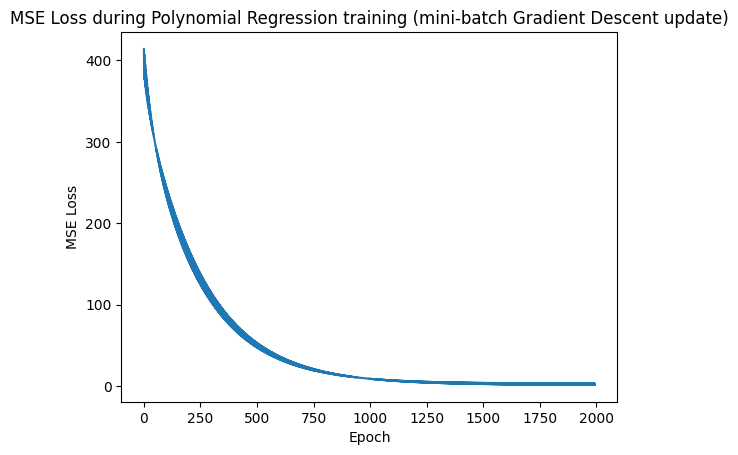

In [408]:
# Plot loss
plt.plot(train_loss_his)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MSE Loss during Polynomial Regression training (mini-batch Gradient Descent update)')
plt.show()

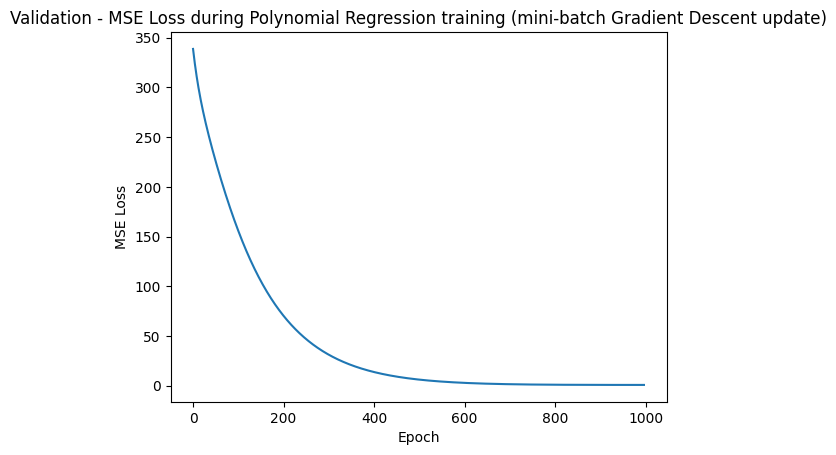

In [409]:
# Plot loss
plt.plot(val_loss_his)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Validation - MSE Loss during Polynomial Regression training (mini-batch Gradient Descent update)')
plt.show()

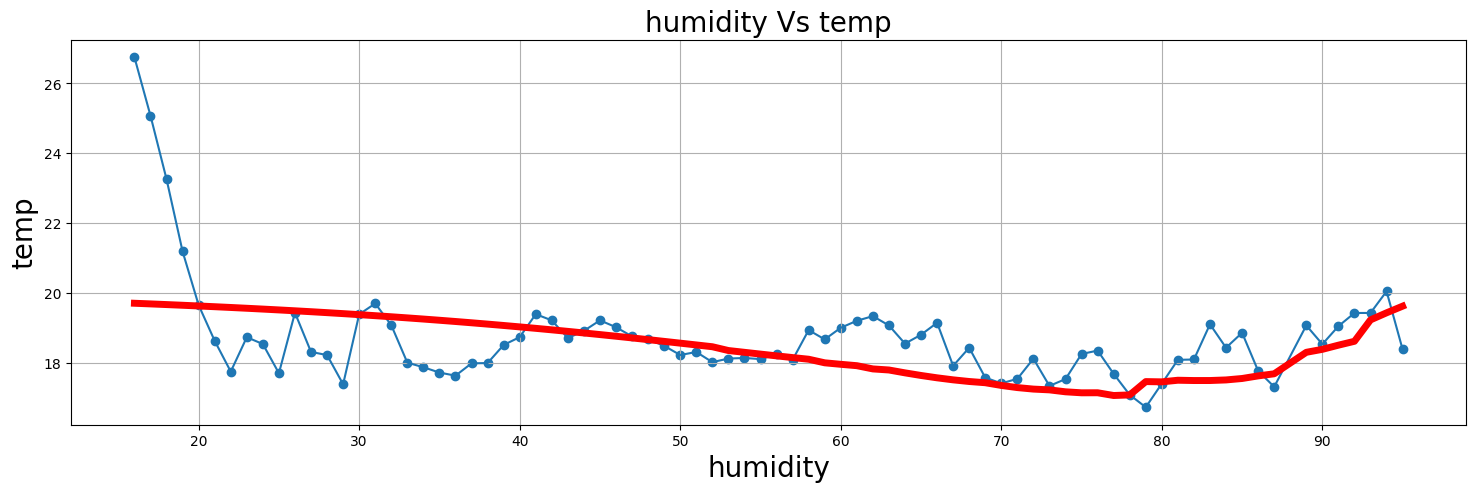

In [410]:
y1_pred = np.dot(X1, w1) + b1
SensorVizWithPrediction(df_pair1, feature_X, feature_y, y1_pred)

Rsquare2 : 0.13611070357811172
Mean Square Error : 1.9014589490279439
Root Mean Square Error : 1.378933990090876
Mean Absolute Error : 0.8649882101859776


<Figure size 2000x500 with 0 Axes>

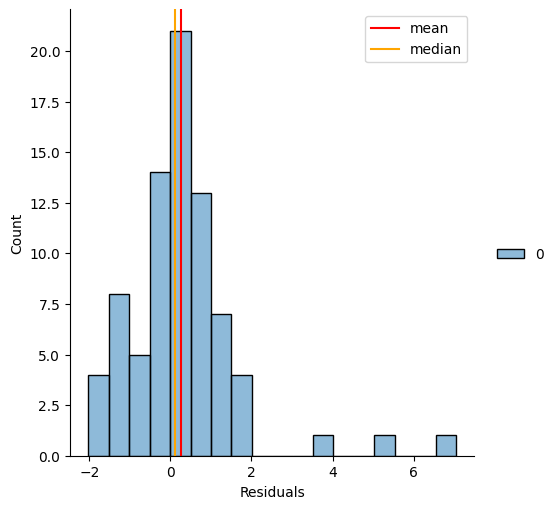

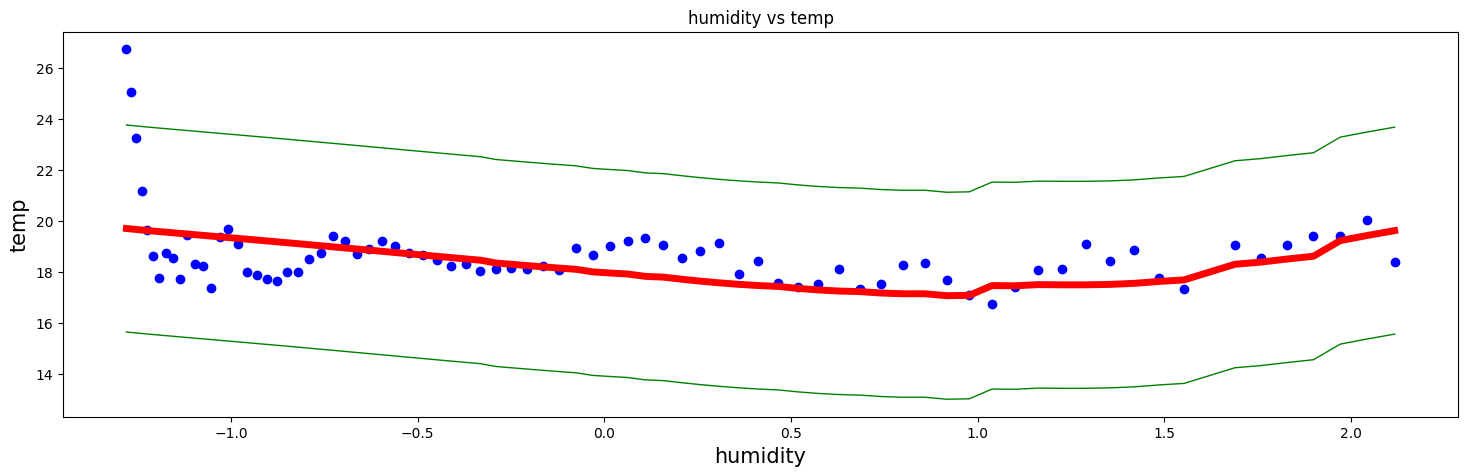

In [411]:
assess_model(X1[:, 1], y1, y1_pred, feature_X='humidity', feature_y='temp')

Pair 2: minute and temp

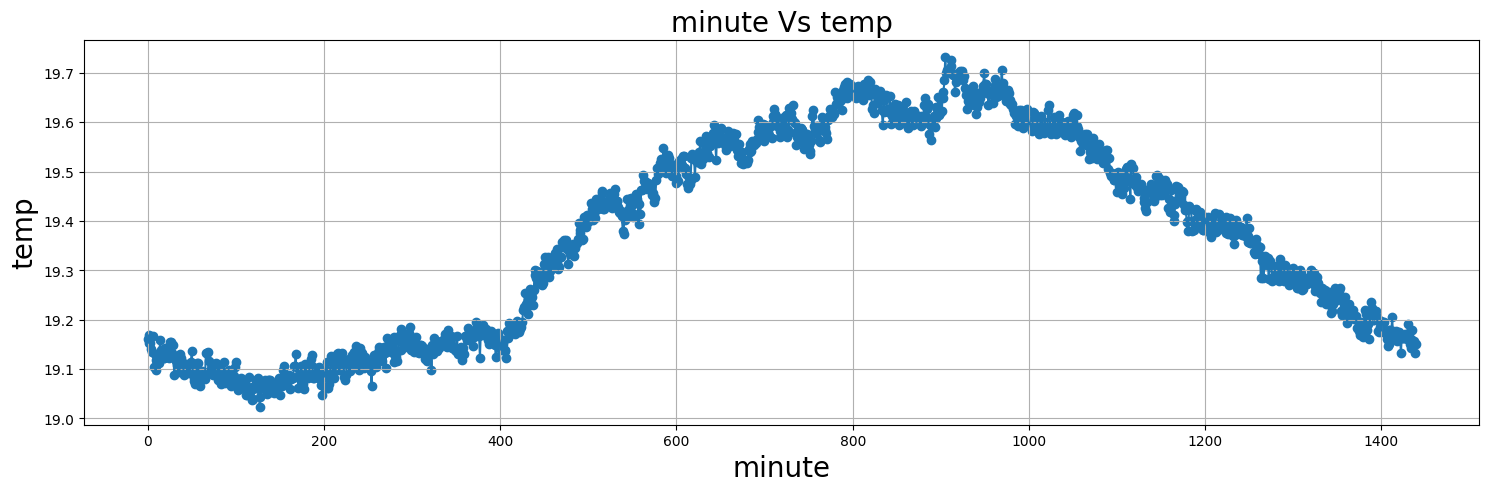

In [412]:
feature_y = 'temp'
feature_X = 'minute'

df_pair2 = features[[feature_X, feature_y]].groupby(feature_X, as_index=False).mean()
SensorViz(df_pair2, feature_X, feature_y)

In [413]:
# Define hyper-parameters for training model
epochs = 10000
learning_rate = 0.001
degree = 3
batch_size = 32
patience = 5 # for early stopping

# Prepare data for training
X2 = df_pair2[[feature_X]].values
y2 = df_pair2[[feature_y]].values.reshape(-1, 1)

print(type(X2), X2.shape, type(y2), y2.shape)
X2 = add_features(x=X2, degree=degree)
X2 = normalize(x=X2)

# Fit model (training)
w2, b2, train_loss_his, val_loss_his = poly_reg_fit(X2, y2,
                                                    lr=learning_rate,
                                                    epochs=epochs,
                                                    batch_size=batch_size,
                                                    patience=patience)

<class 'numpy.ndarray'> (1440, 1) <class 'numpy.ndarray'> (1440, 1)


  0%|          | 42/10000 [00:00<00:23, 417.04it/s]

Epoch 0 | train_loss=385.337 | val_loss=357.830
Epoch 1 | train_loss=336.033 | val_loss=312.684
Epoch 2 | train_loss=293.108 | val_loss=273.234
Epoch 3 | train_loss=255.716 | val_loss=238.756
Epoch 4 | train_loss=223.127 | val_loss=208.621
Epoch 5 | train_loss=194.715 | val_loss=182.284
Epoch 6 | train_loss=169.938 | val_loss=159.265
Epoch 7 | train_loss=148.326 | val_loss=139.148
Epoch 8 | train_loss=129.472 | val_loss=121.568
Epoch 9 | train_loss=113.021 | val_loss=106.206
Epoch 10 | train_loss=98.666 | val_loss=92.783
Epoch 11 | train_loss=86.139 | val_loss=81.056
Epoch 12 | train_loss=75.206 | val_loss=70.811
Epoch 13 | train_loss=65.665 | val_loss=61.861
Epoch 14 | train_loss=57.337 | val_loss=54.044
Epoch 15 | train_loss=50.068 | val_loss=47.215
Epoch 16 | train_loss=43.723 | val_loss=41.251
Epoch 17 | train_loss=38.185 | val_loss=36.041
Epoch 18 | train_loss=33.351 | val_loss=31.492
Epoch 19 | train_loss=29.131 | val_loss=27.519
Epoch 20 | train_loss=25.448 | val_loss=24.049
Epo

  1%|▏         | 126/10000 [00:00<00:24, 398.52it/s]


Epoch 82 | train_loss=0.090 | val_loss=0.092
Epoch 83 | train_loss=0.088 | val_loss=0.090
Epoch 84 | train_loss=0.087 | val_loss=0.088
Epoch 85 | train_loss=0.085 | val_loss=0.087
Epoch 86 | train_loss=0.084 | val_loss=0.086
Epoch 87 | train_loss=0.083 | val_loss=0.084
Epoch 88 | train_loss=0.082 | val_loss=0.083
Epoch 89 | train_loss=0.080 | val_loss=0.082
Epoch 90 | train_loss=0.079 | val_loss=0.081
Epoch 91 | train_loss=0.078 | val_loss=0.080
Epoch 92 | train_loss=0.077 | val_loss=0.079
Epoch 93 | train_loss=0.076 | val_loss=0.078
Epoch 94 | train_loss=0.075 | val_loss=0.077
Epoch 95 | train_loss=0.074 | val_loss=0.076
Epoch 96 | train_loss=0.073 | val_loss=0.075
Epoch 97 | train_loss=0.072 | val_loss=0.074
Epoch 98 | train_loss=0.072 | val_loss=0.073
Epoch 99 | train_loss=0.071 | val_loss=0.072
Epoch 100 | train_loss=0.070 | val_loss=0.071
Epoch 101 | train_loss=0.069 | val_loss=0.070
Epoch 102 | train_loss=0.068 | val_loss=0.070
Epoch 103 | train_loss=0.068 | val_loss=0.069
Epoch

  2%|▏         | 205/10000 [00:00<00:26, 367.10it/s]

Epoch 161 | train_loss=0.037 | val_loss=0.038
Epoch 162 | train_loss=0.036 | val_loss=0.037
Epoch 163 | train_loss=0.036 | val_loss=0.037
Epoch 164 | train_loss=0.036 | val_loss=0.036
Epoch 165 | train_loss=0.035 | val_loss=0.036
Epoch 166 | train_loss=0.035 | val_loss=0.036
Epoch 167 | train_loss=0.035 | val_loss=0.035
Epoch 168 | train_loss=0.034 | val_loss=0.035
Epoch 169 | train_loss=0.034 | val_loss=0.035
Epoch 170 | train_loss=0.033 | val_loss=0.034
Epoch 171 | train_loss=0.033 | val_loss=0.034
Epoch 172 | train_loss=0.033 | val_loss=0.034
Epoch 173 | train_loss=0.033 | val_loss=0.033
Epoch 174 | train_loss=0.032 | val_loss=0.033
Epoch 175 | train_loss=0.032 | val_loss=0.033
Epoch 176 | train_loss=0.032 | val_loss=0.032
Epoch 177 | train_loss=0.031 | val_loss=0.032
Epoch 178 | train_loss=0.031 | val_loss=0.032
Epoch 179 | train_loss=0.031 | val_loss=0.031
Epoch 180 | train_loss=0.030 | val_loss=0.031
Epoch 181 | train_loss=0.030 | val_loss=0.031
Epoch 182 | train_loss=0.030 | val

  3%|▎         | 279/10000 [00:00<00:26, 360.99it/s]

Epoch 234 | train_loss=0.018 | val_loss=0.019
Epoch 235 | train_loss=0.018 | val_loss=0.019
Epoch 236 | train_loss=0.018 | val_loss=0.019
Epoch 237 | train_loss=0.018 | val_loss=0.018
Epoch 238 | train_loss=0.018 | val_loss=0.018
Epoch 239 | train_loss=0.018 | val_loss=0.018
Epoch 240 | train_loss=0.018 | val_loss=0.018
Epoch 241 | train_loss=0.017 | val_loss=0.018
Epoch 242 | train_loss=0.017 | val_loss=0.018
Epoch 243 | train_loss=0.017 | val_loss=0.018
Epoch 244 | train_loss=0.017 | val_loss=0.017
Epoch 245 | train_loss=0.017 | val_loss=0.017
Epoch 246 | train_loss=0.017 | val_loss=0.017
Epoch 247 | train_loss=0.017 | val_loss=0.017
Epoch 248 | train_loss=0.016 | val_loss=0.017
Epoch 249 | train_loss=0.016 | val_loss=0.017
Epoch 250 | train_loss=0.016 | val_loss=0.017
Epoch 251 | train_loss=0.016 | val_loss=0.016
Epoch 252 | train_loss=0.016 | val_loss=0.016
Epoch 253 | train_loss=0.016 | val_loss=0.016
Epoch 254 | train_loss=0.016 | val_loss=0.016
Epoch 255 | train_loss=0.016 | val

  4%|▎         | 359/10000 [00:00<00:25, 378.46it/s]

Epoch 311 | train_loss=0.010 | val_loss=0.011
Epoch 312 | train_loss=0.010 | val_loss=0.010
Epoch 313 | train_loss=0.010 | val_loss=0.010
Epoch 314 | train_loss=0.010 | val_loss=0.010
Epoch 315 | train_loss=0.010 | val_loss=0.010
Epoch 316 | train_loss=0.010 | val_loss=0.010
Epoch 317 | train_loss=0.010 | val_loss=0.010
Epoch 318 | train_loss=0.010 | val_loss=0.010
Epoch 319 | train_loss=0.010 | val_loss=0.010
Epoch 320 | train_loss=0.010 | val_loss=0.010
Epoch 321 | train_loss=0.010 | val_loss=0.010
Epoch 322 | train_loss=0.010 | val_loss=0.010
Epoch 323 | train_loss=0.010 | val_loss=0.010
Epoch 324 | train_loss=0.010 | val_loss=0.010
Epoch 325 | train_loss=0.010 | val_loss=0.010
Epoch 326 | train_loss=0.009 | val_loss=0.010
Epoch 327 | train_loss=0.009 | val_loss=0.010
Epoch 328 | train_loss=0.009 | val_loss=0.009
Epoch 329 | train_loss=0.009 | val_loss=0.009
Epoch 330 | train_loss=0.009 | val_loss=0.009
Epoch 331 | train_loss=0.009 | val_loss=0.009
Epoch 332 | train_loss=0.009 | val

  4%|▍         | 433/10000 [00:01<00:27, 354.03it/s]


Epoch 388 | train_loss=0.007 | val_loss=0.007
Epoch 389 | train_loss=0.007 | val_loss=0.007
Epoch 390 | train_loss=0.007 | val_loss=0.007
Epoch 391 | train_loss=0.007 | val_loss=0.007
Epoch 392 | train_loss=0.007 | val_loss=0.007
Epoch 393 | train_loss=0.007 | val_loss=0.007
Epoch 394 | train_loss=0.007 | val_loss=0.007
Epoch 395 | train_loss=0.007 | val_loss=0.007
Epoch 396 | train_loss=0.007 | val_loss=0.007
Epoch 397 | train_loss=0.007 | val_loss=0.007
Epoch 398 | train_loss=0.007 | val_loss=0.007
Epoch 399 | train_loss=0.007 | val_loss=0.007
Epoch 400 | train_loss=0.007 | val_loss=0.007
Epoch 401 | train_loss=0.007 | val_loss=0.007
Epoch 402 | train_loss=0.007 | val_loss=0.007
Epoch 403 | train_loss=0.007 | val_loss=0.007
Epoch 404 | train_loss=0.007 | val_loss=0.006
Epoch 405 | train_loss=0.007 | val_loss=0.006
Epoch 406 | train_loss=0.007 | val_loss=0.006
Epoch 407 | train_loss=0.007 | val_loss=0.006
Epoch 408 | train_loss=0.007 | val_loss=0.006
Epoch 409 | train_loss=0.007 | va

  5%|▌         | 509/10000 [00:01<00:25, 365.51it/s]


Epoch 459 | train_loss=0.006 | val_loss=0.005
Epoch 460 | train_loss=0.006 | val_loss=0.005
Epoch 461 | train_loss=0.006 | val_loss=0.005
Epoch 462 | train_loss=0.006 | val_loss=0.005
Epoch 463 | train_loss=0.006 | val_loss=0.005
Epoch 464 | train_loss=0.006 | val_loss=0.005
Epoch 465 | train_loss=0.006 | val_loss=0.005
Epoch 466 | train_loss=0.006 | val_loss=0.005
Epoch 467 | train_loss=0.006 | val_loss=0.005
Epoch 468 | train_loss=0.006 | val_loss=0.005
Epoch 469 | train_loss=0.006 | val_loss=0.005
Epoch 470 | train_loss=0.006 | val_loss=0.005
Epoch 471 | train_loss=0.006 | val_loss=0.005
Epoch 472 | train_loss=0.006 | val_loss=0.005
Epoch 473 | train_loss=0.006 | val_loss=0.005
Epoch 474 | train_loss=0.006 | val_loss=0.005
Epoch 475 | train_loss=0.006 | val_loss=0.005
Epoch 476 | train_loss=0.006 | val_loss=0.005
Epoch 477 | train_loss=0.006 | val_loss=0.005
Epoch 478 | train_loss=0.006 | val_loss=0.005
Epoch 479 | train_loss=0.006 | val_loss=0.005
Epoch 480 | train_loss=0.006 | va

  6%|▌         | 584/10000 [00:01<00:26, 362.10it/s]

Epoch 532 | train_loss=0.005 | val_loss=0.005
Epoch 533 | train_loss=0.005 | val_loss=0.005
Epoch 534 | train_loss=0.005 | val_loss=0.005
Epoch 535 | train_loss=0.005 | val_loss=0.005
Epoch 536 | train_loss=0.005 | val_loss=0.005
Epoch 537 | train_loss=0.005 | val_loss=0.005
Epoch 538 | train_loss=0.005 | val_loss=0.005
Epoch 539 | train_loss=0.005 | val_loss=0.005
Epoch 540 | train_loss=0.005 | val_loss=0.005
Epoch 541 | train_loss=0.005 | val_loss=0.005
Epoch 542 | train_loss=0.005 | val_loss=0.005
Epoch 543 | train_loss=0.005 | val_loss=0.005
Epoch 544 | train_loss=0.005 | val_loss=0.005
Epoch 545 | train_loss=0.005 | val_loss=0.005
Epoch 546 | train_loss=0.005 | val_loss=0.005
Epoch 547 | train_loss=0.005 | val_loss=0.005
Epoch 548 | train_loss=0.005 | val_loss=0.005
Epoch 549 | train_loss=0.005 | val_loss=0.005
Epoch 550 | train_loss=0.005 | val_loss=0.005
Epoch 551 | train_loss=0.005 | val_loss=0.005
Epoch 552 | train_loss=0.005 | val_loss=0.005
Epoch 553 | train_loss=0.005 | val

  7%|▋         | 658/10000 [00:01<00:26, 356.90it/s]

Epoch 604 | train_loss=0.005 | val_loss=0.004
Epoch 605 | train_loss=0.005 | val_loss=0.004
Epoch 606 | train_loss=0.005 | val_loss=0.004
Epoch 607 | train_loss=0.005 | val_loss=0.004
Epoch 608 | train_loss=0.005 | val_loss=0.004
Epoch 609 | train_loss=0.005 | val_loss=0.004
Epoch 610 | train_loss=0.005 | val_loss=0.004
Epoch 611 | train_loss=0.005 | val_loss=0.004
Epoch 612 | train_loss=0.005 | val_loss=0.004
Epoch 613 | train_loss=0.005 | val_loss=0.004
Epoch 614 | train_loss=0.005 | val_loss=0.004
Epoch 615 | train_loss=0.005 | val_loss=0.004
Epoch 616 | train_loss=0.005 | val_loss=0.004
Epoch 617 | train_loss=0.005 | val_loss=0.004
Epoch 618 | train_loss=0.005 | val_loss=0.004
Epoch 619 | train_loss=0.005 | val_loss=0.004
Epoch 620 | train_loss=0.005 | val_loss=0.004
Epoch 621 | train_loss=0.005 | val_loss=0.004
Epoch 622 | train_loss=0.005 | val_loss=0.004
Epoch 623 | train_loss=0.005 | val_loss=0.004
Epoch 624 | train_loss=0.005 | val_loss=0.004
Epoch 625 | train_loss=0.005 | val

  7%|▋         | 736/10000 [00:02<00:25, 370.28it/s]


Epoch 678 | train_loss=0.005 | val_loss=0.004
Epoch 679 | train_loss=0.005 | val_loss=0.004
Epoch 680 | train_loss=0.005 | val_loss=0.004
Epoch 681 | train_loss=0.005 | val_loss=0.004
Epoch 682 | train_loss=0.005 | val_loss=0.004
Epoch 683 | train_loss=0.005 | val_loss=0.004
Epoch 684 | train_loss=0.005 | val_loss=0.004
Epoch 685 | train_loss=0.005 | val_loss=0.004
Epoch 686 | train_loss=0.005 | val_loss=0.004
Epoch 687 | train_loss=0.005 | val_loss=0.004
Epoch 688 | train_loss=0.005 | val_loss=0.004
Epoch 689 | train_loss=0.005 | val_loss=0.004
Epoch 690 | train_loss=0.005 | val_loss=0.004
Epoch 691 | train_loss=0.005 | val_loss=0.004
Epoch 692 | train_loss=0.005 | val_loss=0.004
Epoch 693 | train_loss=0.005 | val_loss=0.004
Epoch 694 | train_loss=0.005 | val_loss=0.004
Epoch 695 | train_loss=0.005 | val_loss=0.004
Epoch 696 | train_loss=0.005 | val_loss=0.004
Epoch 697 | train_loss=0.005 | val_loss=0.004
Epoch 698 | train_loss=0.005 | val_loss=0.004
Epoch 699 | train_loss=0.005 | va

  8%|▊         | 815/10000 [00:02<00:24, 373.39it/s]

Epoch 754 | train_loss=0.005 | val_loss=0.004
Epoch 755 | train_loss=0.005 | val_loss=0.004
Epoch 756 | train_loss=0.005 | val_loss=0.004
Epoch 757 | train_loss=0.005 | val_loss=0.004
Epoch 758 | train_loss=0.005 | val_loss=0.004
Epoch 759 | train_loss=0.005 | val_loss=0.004
Epoch 760 | train_loss=0.005 | val_loss=0.004
Epoch 761 | train_loss=0.005 | val_loss=0.004
Epoch 762 | train_loss=0.005 | val_loss=0.004
Epoch 763 | train_loss=0.005 | val_loss=0.004
Epoch 764 | train_loss=0.005 | val_loss=0.004
Epoch 765 | train_loss=0.005 | val_loss=0.004
Epoch 766 | train_loss=0.005 | val_loss=0.004
Epoch 767 | train_loss=0.005 | val_loss=0.004
Epoch 768 | train_loss=0.005 | val_loss=0.004
Epoch 769 | train_loss=0.005 | val_loss=0.004
Epoch 770 | train_loss=0.005 | val_loss=0.004
Epoch 771 | train_loss=0.005 | val_loss=0.004
Epoch 772 | train_loss=0.005 | val_loss=0.004
Epoch 773 | train_loss=0.005 | val_loss=0.004
Epoch 774 | train_loss=0.005 | val_loss=0.004
Epoch 775 | train_loss=0.005 | val

  9%|▉         | 895/10000 [00:02<00:23, 384.48it/s]


Epoch 831 | train_loss=0.005 | val_loss=0.004
Epoch 832 | train_loss=0.005 | val_loss=0.004
Epoch 833 | train_loss=0.005 | val_loss=0.004
Epoch 834 | train_loss=0.005 | val_loss=0.004
Epoch 835 | train_loss=0.005 | val_loss=0.004
Epoch 836 | train_loss=0.005 | val_loss=0.004
Epoch 837 | train_loss=0.005 | val_loss=0.004
Epoch 838 | train_loss=0.005 | val_loss=0.004
Epoch 839 | train_loss=0.005 | val_loss=0.004
Epoch 840 | train_loss=0.005 | val_loss=0.004
Epoch 841 | train_loss=0.005 | val_loss=0.004
Epoch 842 | train_loss=0.005 | val_loss=0.004
Epoch 843 | train_loss=0.005 | val_loss=0.004
Epoch 844 | train_loss=0.005 | val_loss=0.004
Epoch 845 | train_loss=0.005 | val_loss=0.004
Epoch 846 | train_loss=0.005 | val_loss=0.004
Epoch 847 | train_loss=0.005 | val_loss=0.004
Epoch 848 | train_loss=0.005 | val_loss=0.004
Epoch 849 | train_loss=0.005 | val_loss=0.004
Epoch 850 | train_loss=0.005 | val_loss=0.004
Epoch 851 | train_loss=0.005 | val_loss=0.004
Epoch 852 | train_loss=0.005 | va

 10%|▉         | 974/10000 [00:02<00:23, 377.68it/s]

Epoch 911 | train_loss=0.005 | val_loss=0.004
Epoch 912 | train_loss=0.005 | val_loss=0.004
Epoch 913 | train_loss=0.005 | val_loss=0.004
Epoch 914 | train_loss=0.005 | val_loss=0.004
Epoch 915 | train_loss=0.005 | val_loss=0.004
Epoch 916 | train_loss=0.005 | val_loss=0.004
Epoch 917 | train_loss=0.005 | val_loss=0.004
Epoch 918 | train_loss=0.005 | val_loss=0.004
Epoch 919 | train_loss=0.005 | val_loss=0.004
Epoch 920 | train_loss=0.005 | val_loss=0.004
Epoch 921 | train_loss=0.005 | val_loss=0.004
Epoch 922 | train_loss=0.005 | val_loss=0.004
Epoch 923 | train_loss=0.005 | val_loss=0.004
Epoch 924 | train_loss=0.005 | val_loss=0.004
Epoch 925 | train_loss=0.005 | val_loss=0.004
Epoch 926 | train_loss=0.005 | val_loss=0.004
Epoch 927 | train_loss=0.005 | val_loss=0.004
Epoch 928 | train_loss=0.005 | val_loss=0.004
Epoch 929 | train_loss=0.005 | val_loss=0.004
Epoch 930 | train_loss=0.005 | val_loss=0.004
Epoch 931 | train_loss=0.005 | val_loss=0.004
Epoch 932 | train_loss=0.005 | val

 10%|█         | 1049/10000 [00:02<00:24, 359.83it/s]

Epoch 985 | train_loss=0.005 | val_loss=0.004
Epoch 986 | train_loss=0.005 | val_loss=0.004
Epoch 987 | train_loss=0.005 | val_loss=0.004
Epoch 988 | train_loss=0.005 | val_loss=0.004
Epoch 989 | train_loss=0.005 | val_loss=0.004
Epoch 990 | train_loss=0.005 | val_loss=0.004
Epoch 991 | train_loss=0.005 | val_loss=0.004
Epoch 992 | train_loss=0.005 | val_loss=0.004
Epoch 993 | train_loss=0.005 | val_loss=0.004
Epoch 994 | train_loss=0.005 | val_loss=0.004
Epoch 995 | train_loss=0.005 | val_loss=0.004
Epoch 996 | train_loss=0.005 | val_loss=0.004
Epoch 997 | train_loss=0.005 | val_loss=0.004
Epoch 998 | train_loss=0.005 | val_loss=0.004
Epoch 999 | train_loss=0.005 | val_loss=0.004
Epoch 1000 | train_loss=0.005 | val_loss=0.004
Epoch 1001 | train_loss=0.005 | val_loss=0.004
Epoch 1002 | train_loss=0.005 | val_loss=0.004
Epoch 1003 | train_loss=0.005 | val_loss=0.004
Epoch 1004 | train_loss=0.005 | val_loss=0.004
Epoch 1005 | train_loss=0.005 | val_loss=0.004
Epoch 1006 | train_loss=0.00

 11%|█         | 1086/10000 [00:02<00:25, 350.09it/s]


Epoch 1054 | train_loss=0.005 | val_loss=0.004
Epoch 1055 | train_loss=0.005 | val_loss=0.004
Epoch 1056 | train_loss=0.005 | val_loss=0.004
Epoch 1057 | train_loss=0.005 | val_loss=0.004
Epoch 1058 | train_loss=0.005 | val_loss=0.004
Epoch 1059 | train_loss=0.005 | val_loss=0.004
Epoch 1060 | train_loss=0.005 | val_loss=0.004
Epoch 1061 | train_loss=0.005 | val_loss=0.004
Epoch 1062 | train_loss=0.005 | val_loss=0.004
Epoch 1063 | train_loss=0.005 | val_loss=0.004
Epoch 1064 | train_loss=0.005 | val_loss=0.004
Epoch 1065 | train_loss=0.005 | val_loss=0.004
Epoch 1066 | train_loss=0.005 | val_loss=0.004
Epoch 1067 | train_loss=0.005 | val_loss=0.004
Epoch 1068 | train_loss=0.005 | val_loss=0.004
Epoch 1069 | train_loss=0.005 | val_loss=0.004
Epoch 1070 | train_loss=0.005 | val_loss=0.004
Epoch 1071 | train_loss=0.005 | val_loss=0.004
Epoch 1072 | train_loss=0.005 | val_loss=0.004
Epoch 1073 | train_loss=0.005 | val_loss=0.004
Epoch 1074 | train_loss=0.005 | val_loss=0.004
Epoch 1075 |

 11%|█         | 1122/10000 [00:03<00:25, 348.62it/s]


Epoch 1122 | train_loss=0.005 | val_loss=0.004
Epoch 1123 | train_loss=0.005 | val_loss=0.004


 12%|█▏        | 1157/10000 [00:03<00:25, 342.02it/s]

Epoch 1124 | train_loss=0.005 | val_loss=0.004
Epoch 1125 | train_loss=0.005 | val_loss=0.004
Epoch 1126 | train_loss=0.005 | val_loss=0.004
Epoch 1127 | train_loss=0.005 | val_loss=0.004
Epoch 1128 | train_loss=0.005 | val_loss=0.004
Epoch 1129 | train_loss=0.005 | val_loss=0.004
Epoch 1130 | train_loss=0.005 | val_loss=0.004
Epoch 1131 | train_loss=0.005 | val_loss=0.004
Epoch 1132 | train_loss=0.005 | val_loss=0.004
Epoch 1133 | train_loss=0.005 | val_loss=0.004
Epoch 1134 | train_loss=0.005 | val_loss=0.004
Epoch 1135 | train_loss=0.005 | val_loss=0.004
Epoch 1136 | train_loss=0.005 | val_loss=0.004
Epoch 1137 | train_loss=0.005 | val_loss=0.004
Epoch 1138 | train_loss=0.005 | val_loss=0.004
Epoch 1139 | train_loss=0.005 | val_loss=0.004
Epoch 1140 | train_loss=0.005 | val_loss=0.004
Epoch 1141 | train_loss=0.005 | val_loss=0.004
Epoch 1142 | train_loss=0.005 | val_loss=0.004
Epoch 1143 | train_loss=0.005 | val_loss=0.004
Epoch 1144 | train_loss=0.005 | val_loss=0.004
Epoch 1145 | 

 12%|█▏        | 1196/10000 [00:03<00:24, 354.72it/s]


Epoch 1194 | train_loss=0.005 | val_loss=0.004
Epoch 1195 | train_loss=0.005 | val_loss=0.004
Epoch 1196 | train_loss=0.005 | val_loss=0.004


 12%|█▏        | 1232/10000 [00:03<00:24, 351.61it/s]

Epoch 1197 | train_loss=0.005 | val_loss=0.004
Epoch 1198 | train_loss=0.005 | val_loss=0.004
Epoch 1199 | train_loss=0.005 | val_loss=0.004
Epoch 1200 | train_loss=0.005 | val_loss=0.004
Epoch 1201 | train_loss=0.005 | val_loss=0.004
Epoch 1202 | train_loss=0.005 | val_loss=0.004
Epoch 1203 | train_loss=0.005 | val_loss=0.004
Epoch 1204 | train_loss=0.005 | val_loss=0.004
Epoch 1205 | train_loss=0.005 | val_loss=0.004
Epoch 1206 | train_loss=0.005 | val_loss=0.004
Epoch 1207 | train_loss=0.005 | val_loss=0.004
Epoch 1208 | train_loss=0.005 | val_loss=0.004
Epoch 1209 | train_loss=0.005 | val_loss=0.004
Epoch 1210 | train_loss=0.005 | val_loss=0.004
Epoch 1211 | train_loss=0.005 | val_loss=0.004
Epoch 1212 | train_loss=0.005 | val_loss=0.004
Epoch 1213 | train_loss=0.005 | val_loss=0.004
Epoch 1214 | train_loss=0.005 | val_loss=0.004
Epoch 1215 | train_loss=0.005 | val_loss=0.004
Epoch 1216 | train_loss=0.005 | val_loss=0.004
Epoch 1217 | train_loss=0.005 | val_loss=0.004
Epoch 1218 | 

 13%|█▎        | 1302/10000 [00:03<00:26, 331.54it/s]

Epoch 1264 | train_loss=0.005 | val_loss=0.004
Epoch 1265 | train_loss=0.005 | val_loss=0.004
Epoch 1266 | train_loss=0.005 | val_loss=0.004
Epoch 1267 | train_loss=0.005 | val_loss=0.004
Epoch 1268 | train_loss=0.005 | val_loss=0.004
Epoch 1269 | train_loss=0.005 | val_loss=0.004
Epoch 1270 | train_loss=0.005 | val_loss=0.004
Epoch 1271 | train_loss=0.005 | val_loss=0.004
Epoch 1272 | train_loss=0.005 | val_loss=0.004
Epoch 1273 | train_loss=0.005 | val_loss=0.004
Epoch 1274 | train_loss=0.005 | val_loss=0.004
Epoch 1275 | train_loss=0.005 | val_loss=0.004
Epoch 1276 | train_loss=0.005 | val_loss=0.004
Epoch 1277 | train_loss=0.005 | val_loss=0.004
Epoch 1278 | train_loss=0.005 | val_loss=0.004
Epoch 1279 | train_loss=0.005 | val_loss=0.004
Epoch 1280 | train_loss=0.005 | val_loss=0.004
Epoch 1281 | train_loss=0.005 | val_loss=0.004
Epoch 1282 | train_loss=0.005 | val_loss=0.004
Epoch 1283 | train_loss=0.005 | val_loss=0.004
Epoch 1284 | train_loss=0.005 | val_loss=0.004
Epoch 1285 | 

 14%|█▍        | 1375/10000 [00:03<00:24, 346.72it/s]

Epoch 1330 | train_loss=0.005 | val_loss=0.004
Epoch 1331 | train_loss=0.005 | val_loss=0.004
Epoch 1332 | train_loss=0.005 | val_loss=0.004
Epoch 1333 | train_loss=0.005 | val_loss=0.004
Epoch 1334 | train_loss=0.005 | val_loss=0.004
Epoch 1335 | train_loss=0.005 | val_loss=0.004
Epoch 1336 | train_loss=0.005 | val_loss=0.004
Epoch 1337 | train_loss=0.005 | val_loss=0.004
Epoch 1338 | train_loss=0.005 | val_loss=0.004
Epoch 1339 | train_loss=0.005 | val_loss=0.004
Epoch 1340 | train_loss=0.005 | val_loss=0.004
Epoch 1341 | train_loss=0.005 | val_loss=0.004
Epoch 1342 | train_loss=0.005 | val_loss=0.004
Epoch 1343 | train_loss=0.005 | val_loss=0.004
Epoch 1344 | train_loss=0.005 | val_loss=0.004
Epoch 1345 | train_loss=0.005 | val_loss=0.004
Epoch 1346 | train_loss=0.005 | val_loss=0.004
Epoch 1347 | train_loss=0.005 | val_loss=0.004
Epoch 1348 | train_loss=0.005 | val_loss=0.004
Epoch 1349 | train_loss=0.005 | val_loss=0.004
Epoch 1350 | train_loss=0.005 | val_loss=0.004
Epoch 1351 | 

 14%|█▍        | 1448/10000 [00:04<00:24, 346.26it/s]

Epoch 1405 | train_loss=0.005 | val_loss=0.004
Epoch 1406 | train_loss=0.005 | val_loss=0.004
Epoch 1407 | train_loss=0.005 | val_loss=0.004
Epoch 1408 | train_loss=0.005 | val_loss=0.004
Epoch 1409 | train_loss=0.005 | val_loss=0.004
Epoch 1410 | train_loss=0.005 | val_loss=0.004
Epoch 1411 | train_loss=0.005 | val_loss=0.004
Epoch 1412 | train_loss=0.005 | val_loss=0.004
Epoch 1413 | train_loss=0.005 | val_loss=0.004
Epoch 1414 | train_loss=0.005 | val_loss=0.004
Epoch 1415 | train_loss=0.005 | val_loss=0.004
Epoch 1416 | train_loss=0.005 | val_loss=0.004
Epoch 1417 | train_loss=0.005 | val_loss=0.004
Epoch 1418 | train_loss=0.005 | val_loss=0.004
Epoch 1419 | train_loss=0.005 | val_loss=0.004
Epoch 1420 | train_loss=0.005 | val_loss=0.004
Epoch 1421 | train_loss=0.005 | val_loss=0.004
Epoch 1422 | train_loss=0.005 | val_loss=0.004
Epoch 1423 | train_loss=0.005 | val_loss=0.004
Epoch 1424 | train_loss=0.005 | val_loss=0.004
Epoch 1425 | train_loss=0.005 | val_loss=0.004
Epoch 1426 | 

 15%|█▌        | 1521/10000 [00:04<00:24, 350.56it/s]

Epoch 1473 | train_loss=0.005 | val_loss=0.004
Epoch 1474 | train_loss=0.005 | val_loss=0.004
Epoch 1475 | train_loss=0.005 | val_loss=0.004
Epoch 1476 | train_loss=0.005 | val_loss=0.004
Epoch 1477 | train_loss=0.005 | val_loss=0.004
Epoch 1478 | train_loss=0.005 | val_loss=0.004
Epoch 1479 | train_loss=0.005 | val_loss=0.004
Epoch 1480 | train_loss=0.005 | val_loss=0.004
Epoch 1481 | train_loss=0.005 | val_loss=0.004
Epoch 1482 | train_loss=0.005 | val_loss=0.004
Epoch 1483 | train_loss=0.005 | val_loss=0.004
Epoch 1484 | train_loss=0.005 | val_loss=0.004
Epoch 1485 | train_loss=0.005 | val_loss=0.004
Epoch 1486 | train_loss=0.005 | val_loss=0.004
Epoch 1487 | train_loss=0.005 | val_loss=0.004
Epoch 1488 | train_loss=0.005 | val_loss=0.004
Epoch 1489 | train_loss=0.005 | val_loss=0.004
Epoch 1490 | train_loss=0.005 | val_loss=0.004
Epoch 1491 | train_loss=0.005 | val_loss=0.004
Epoch 1492 | train_loss=0.005 | val_loss=0.004
Epoch 1493 | train_loss=0.005 | val_loss=0.004
Epoch 1494 | 

 16%|█▌        | 1598/10000 [00:04<00:23, 363.64it/s]

Epoch 1546 | train_loss=0.005 | val_loss=0.004
Epoch 1547 | train_loss=0.005 | val_loss=0.004
Epoch 1548 | train_loss=0.005 | val_loss=0.004
Epoch 1549 | train_loss=0.005 | val_loss=0.004
Epoch 1550 | train_loss=0.005 | val_loss=0.004
Epoch 1551 | train_loss=0.005 | val_loss=0.004
Epoch 1552 | train_loss=0.005 | val_loss=0.004
Epoch 1553 | train_loss=0.005 | val_loss=0.004
Epoch 1554 | train_loss=0.005 | val_loss=0.004
Epoch 1555 | train_loss=0.005 | val_loss=0.004
Epoch 1556 | train_loss=0.005 | val_loss=0.004
Epoch 1557 | train_loss=0.005 | val_loss=0.004
Epoch 1558 | train_loss=0.005 | val_loss=0.004
Epoch 1559 | train_loss=0.005 | val_loss=0.004
Epoch 1560 | train_loss=0.005 | val_loss=0.004
Epoch 1561 | train_loss=0.005 | val_loss=0.004
Epoch 1562 | train_loss=0.005 | val_loss=0.004
Epoch 1563 | train_loss=0.005 | val_loss=0.004
Epoch 1564 | train_loss=0.005 | val_loss=0.004
Epoch 1565 | train_loss=0.005 | val_loss=0.004
Epoch 1566 | train_loss=0.005 | val_loss=0.004
Epoch 1567 | 

 17%|█▋        | 1672/10000 [00:04<00:22, 363.05it/s]

Epoch 1622 | train_loss=0.005 | val_loss=0.004
Epoch 1623 | train_loss=0.005 | val_loss=0.004
Epoch 1624 | train_loss=0.005 | val_loss=0.004
Epoch 1625 | train_loss=0.005 | val_loss=0.004
Epoch 1626 | train_loss=0.005 | val_loss=0.004
Epoch 1627 | train_loss=0.005 | val_loss=0.004
Epoch 1628 | train_loss=0.005 | val_loss=0.004
Epoch 1629 | train_loss=0.005 | val_loss=0.004
Epoch 1630 | train_loss=0.005 | val_loss=0.004
Epoch 1631 | train_loss=0.005 | val_loss=0.004
Epoch 1632 | train_loss=0.005 | val_loss=0.004
Epoch 1633 | train_loss=0.005 | val_loss=0.004
Epoch 1634 | train_loss=0.005 | val_loss=0.004
Epoch 1635 | train_loss=0.005 | val_loss=0.004
Epoch 1636 | train_loss=0.005 | val_loss=0.004
Epoch 1637 | train_loss=0.005 | val_loss=0.004
Epoch 1638 | train_loss=0.005 | val_loss=0.004
Epoch 1639 | train_loss=0.005 | val_loss=0.004
Epoch 1640 | train_loss=0.005 | val_loss=0.004
Epoch 1641 | train_loss=0.005 | val_loss=0.004
Epoch 1642 | train_loss=0.005 | val_loss=0.004
Epoch 1643 | 

 17%|█▋        | 1745/10000 [00:04<00:23, 345.06it/s]


Epoch 1690 | train_loss=0.005 | val_loss=0.004
Epoch 1691 | train_loss=0.005 | val_loss=0.004
Epoch 1692 | train_loss=0.005 | val_loss=0.004
Epoch 1693 | train_loss=0.005 | val_loss=0.004
Epoch 1694 | train_loss=0.005 | val_loss=0.004
Epoch 1695 | train_loss=0.005 | val_loss=0.004
Epoch 1696 | train_loss=0.005 | val_loss=0.004
Epoch 1697 | train_loss=0.005 | val_loss=0.004
Epoch 1698 | train_loss=0.005 | val_loss=0.004
Epoch 1699 | train_loss=0.005 | val_loss=0.004
Epoch 1700 | train_loss=0.005 | val_loss=0.004
Epoch 1701 | train_loss=0.005 | val_loss=0.004
Epoch 1702 | train_loss=0.005 | val_loss=0.004
Epoch 1703 | train_loss=0.005 | val_loss=0.004
Epoch 1704 | train_loss=0.005 | val_loss=0.004
Epoch 1705 | train_loss=0.005 | val_loss=0.004
Epoch 1706 | train_loss=0.005 | val_loss=0.004
Epoch 1707 | train_loss=0.005 | val_loss=0.004
Epoch 1708 | train_loss=0.005 | val_loss=0.004
Epoch 1709 | train_loss=0.005 | val_loss=0.004
Epoch 1710 | train_loss=0.005 | val_loss=0.004
Epoch 1711 |

 18%|█▊        | 1825/10000 [00:05<00:22, 371.10it/s]

Epoch 1761 | train_loss=0.005 | val_loss=0.004
Epoch 1762 | train_loss=0.005 | val_loss=0.004
Epoch 1763 | train_loss=0.005 | val_loss=0.004
Epoch 1764 | train_loss=0.005 | val_loss=0.004
Epoch 1765 | train_loss=0.005 | val_loss=0.004
Epoch 1766 | train_loss=0.005 | val_loss=0.004
Epoch 1767 | train_loss=0.005 | val_loss=0.004
Epoch 1768 | train_loss=0.005 | val_loss=0.004
Epoch 1769 | train_loss=0.005 | val_loss=0.004
Epoch 1770 | train_loss=0.005 | val_loss=0.004
Epoch 1771 | train_loss=0.005 | val_loss=0.004
Epoch 1772 | train_loss=0.005 | val_loss=0.004
Epoch 1773 | train_loss=0.005 | val_loss=0.004
Epoch 1774 | train_loss=0.005 | val_loss=0.004
Epoch 1775 | train_loss=0.005 | val_loss=0.004
Epoch 1776 | train_loss=0.005 | val_loss=0.004
Epoch 1777 | train_loss=0.005 | val_loss=0.004
Epoch 1778 | train_loss=0.005 | val_loss=0.004
Epoch 1779 | train_loss=0.005 | val_loss=0.004
Epoch 1780 | train_loss=0.005 | val_loss=0.004
Epoch 1781 | train_loss=0.005 | val_loss=0.004
Epoch 1782 | 

 19%|█▉        | 1901/10000 [00:05<00:22, 367.89it/s]

Epoch 1847 | train_loss=0.005 | val_loss=0.004
Epoch 1848 | train_loss=0.005 | val_loss=0.004
Epoch 1849 | train_loss=0.005 | val_loss=0.004
Epoch 1850 | train_loss=0.005 | val_loss=0.004
Epoch 1851 | train_loss=0.005 | val_loss=0.004
Epoch 1852 | train_loss=0.005 | val_loss=0.004
Epoch 1853 | train_loss=0.005 | val_loss=0.004
Epoch 1854 | train_loss=0.005 | val_loss=0.004
Epoch 1855 | train_loss=0.005 | val_loss=0.004
Epoch 1856 | train_loss=0.005 | val_loss=0.004
Epoch 1857 | train_loss=0.005 | val_loss=0.004
Epoch 1858 | train_loss=0.005 | val_loss=0.004
Epoch 1859 | train_loss=0.005 | val_loss=0.004
Epoch 1860 | train_loss=0.005 | val_loss=0.004
Epoch 1861 | train_loss=0.005 | val_loss=0.004
Epoch 1862 | train_loss=0.005 | val_loss=0.004
Epoch 1863 | train_loss=0.005 | val_loss=0.004
Epoch 1864 | train_loss=0.005 | val_loss=0.004
Epoch 1865 | train_loss=0.005 | val_loss=0.004
Epoch 1866 | train_loss=0.005 | val_loss=0.004
Epoch 1867 | train_loss=0.005 | val_loss=0.004
Epoch 1868 | 

 20%|█▉        | 1977/10000 [00:05<00:21, 370.96it/s]

Epoch 1921 | train_loss=0.004 | val_loss=0.004
Epoch 1922 | train_loss=0.004 | val_loss=0.004
Epoch 1923 | train_loss=0.004 | val_loss=0.004
Epoch 1924 | train_loss=0.004 | val_loss=0.004
Epoch 1925 | train_loss=0.004 | val_loss=0.004
Epoch 1926 | train_loss=0.004 | val_loss=0.004
Epoch 1927 | train_loss=0.004 | val_loss=0.004
Epoch 1928 | train_loss=0.004 | val_loss=0.004
Epoch 1929 | train_loss=0.004 | val_loss=0.004
Epoch 1930 | train_loss=0.004 | val_loss=0.004
Epoch 1931 | train_loss=0.004 | val_loss=0.004
Epoch 1932 | train_loss=0.004 | val_loss=0.004
Epoch 1933 | train_loss=0.004 | val_loss=0.004
Epoch 1934 | train_loss=0.004 | val_loss=0.004
Epoch 1935 | train_loss=0.004 | val_loss=0.004
Epoch 1936 | train_loss=0.004 | val_loss=0.004
Epoch 1937 | train_loss=0.004 | val_loss=0.004
Epoch 1938 | train_loss=0.004 | val_loss=0.004
Epoch 1939 | train_loss=0.004 | val_loss=0.004
Epoch 1940 | train_loss=0.004 | val_loss=0.004
Epoch 1941 | train_loss=0.004 | val_loss=0.004
Epoch 1942 | 

 21%|██        | 2055/10000 [00:05<00:20, 378.78it/s]

Epoch 2001 | train_loss=0.004 | val_loss=0.004
Epoch 2002 | train_loss=0.004 | val_loss=0.004
Epoch 2003 | train_loss=0.004 | val_loss=0.004
Epoch 2004 | train_loss=0.004 | val_loss=0.004
Epoch 2005 | train_loss=0.004 | val_loss=0.004
Epoch 2006 | train_loss=0.004 | val_loss=0.004
Epoch 2007 | train_loss=0.004 | val_loss=0.004
Epoch 2008 | train_loss=0.004 | val_loss=0.004
Epoch 2009 | train_loss=0.004 | val_loss=0.004
Epoch 2010 | train_loss=0.004 | val_loss=0.004
Epoch 2011 | train_loss=0.004 | val_loss=0.004
Epoch 2012 | train_loss=0.004 | val_loss=0.004
Epoch 2013 | train_loss=0.004 | val_loss=0.004
Epoch 2014 | train_loss=0.004 | val_loss=0.004
Epoch 2015 | train_loss=0.004 | val_loss=0.004
Epoch 2016 | train_loss=0.004 | val_loss=0.004
Epoch 2017 | train_loss=0.004 | val_loss=0.004
Epoch 2018 | train_loss=0.004 | val_loss=0.004
Epoch 2019 | train_loss=0.004 | val_loss=0.004
Epoch 2020 | train_loss=0.004 | val_loss=0.004
Epoch 2021 | train_loss=0.004 | val_loss=0.004
Epoch 2022 | 

 21%|██▏       | 2130/10000 [00:05<00:22, 357.20it/s]

Epoch 2077 | train_loss=0.004 | val_loss=0.004
Epoch 2078 | train_loss=0.004 | val_loss=0.004
Epoch 2079 | train_loss=0.004 | val_loss=0.004
Epoch 2080 | train_loss=0.004 | val_loss=0.004
Epoch 2081 | train_loss=0.004 | val_loss=0.004
Epoch 2082 | train_loss=0.004 | val_loss=0.004
Epoch 2083 | train_loss=0.004 | val_loss=0.004
Epoch 2084 | train_loss=0.004 | val_loss=0.004
Epoch 2085 | train_loss=0.004 | val_loss=0.004
Epoch 2086 | train_loss=0.004 | val_loss=0.004
Epoch 2087 | train_loss=0.004 | val_loss=0.004
Epoch 2088 | train_loss=0.004 | val_loss=0.004
Epoch 2089 | train_loss=0.004 | val_loss=0.004
Epoch 2090 | train_loss=0.004 | val_loss=0.004
Epoch 2091 | train_loss=0.004 | val_loss=0.004
Epoch 2092 | train_loss=0.004 | val_loss=0.004
Epoch 2093 | train_loss=0.004 | val_loss=0.004
Epoch 2094 | train_loss=0.004 | val_loss=0.004
Epoch 2095 | train_loss=0.004 | val_loss=0.004
Epoch 2096 | train_loss=0.004 | val_loss=0.004
Epoch 2097 | train_loss=0.004 | val_loss=0.004
Epoch 2098 | 

 22%|██▏       | 2209/10000 [00:06<00:21, 370.75it/s]

Epoch 2154 | train_loss=0.004 | val_loss=0.004
Epoch 2155 | train_loss=0.004 | val_loss=0.004
Epoch 2156 | train_loss=0.004 | val_loss=0.004
Epoch 2157 | train_loss=0.004 | val_loss=0.004
Epoch 2158 | train_loss=0.004 | val_loss=0.004
Epoch 2159 | train_loss=0.004 | val_loss=0.004
Epoch 2160 | train_loss=0.004 | val_loss=0.004
Epoch 2161 | train_loss=0.004 | val_loss=0.004
Epoch 2162 | train_loss=0.004 | val_loss=0.004
Epoch 2163 | train_loss=0.004 | val_loss=0.004
Epoch 2164 | train_loss=0.004 | val_loss=0.004
Epoch 2165 | train_loss=0.004 | val_loss=0.004
Epoch 2166 | train_loss=0.004 | val_loss=0.004
Epoch 2167 | train_loss=0.004 | val_loss=0.004
Epoch 2168 | train_loss=0.004 | val_loss=0.004
Epoch 2169 | train_loss=0.004 | val_loss=0.004
Epoch 2170 | train_loss=0.004 | val_loss=0.004
Epoch 2171 | train_loss=0.004 | val_loss=0.004
Epoch 2172 | train_loss=0.004 | val_loss=0.004
Epoch 2173 | train_loss=0.004 | val_loss=0.004
Epoch 2174 | train_loss=0.004 | val_loss=0.004
Epoch 2175 | 

 23%|██▎       | 2286/10000 [00:06<00:21, 364.89it/s]

Epoch 2232 | train_loss=0.004 | val_loss=0.004
Epoch 2233 | train_loss=0.004 | val_loss=0.004
Epoch 2234 | train_loss=0.004 | val_loss=0.004
Epoch 2235 | train_loss=0.004 | val_loss=0.004
Epoch 2236 | train_loss=0.004 | val_loss=0.004
Epoch 2237 | train_loss=0.004 | val_loss=0.004
Epoch 2238 | train_loss=0.004 | val_loss=0.004
Epoch 2239 | train_loss=0.004 | val_loss=0.004
Epoch 2240 | train_loss=0.004 | val_loss=0.004
Epoch 2241 | train_loss=0.004 | val_loss=0.004
Epoch 2242 | train_loss=0.004 | val_loss=0.004
Epoch 2243 | train_loss=0.004 | val_loss=0.004
Epoch 2244 | train_loss=0.004 | val_loss=0.004
Epoch 2245 | train_loss=0.004 | val_loss=0.004
Epoch 2246 | train_loss=0.004 | val_loss=0.004
Epoch 2247 | train_loss=0.004 | val_loss=0.004
Epoch 2248 | train_loss=0.004 | val_loss=0.004
Epoch 2249 | train_loss=0.004 | val_loss=0.004
Epoch 2250 | train_loss=0.004 | val_loss=0.004
Epoch 2251 | train_loss=0.004 | val_loss=0.004
Epoch 2252 | train_loss=0.004 | val_loss=0.004
Epoch 2253 | 

 24%|██▎       | 2361/10000 [00:06<00:21, 348.47it/s]


Epoch 2308 | train_loss=0.004 | val_loss=0.004
Epoch 2309 | train_loss=0.004 | val_loss=0.004
Epoch 2310 | train_loss=0.004 | val_loss=0.004
Epoch 2311 | train_loss=0.004 | val_loss=0.004
Epoch 2312 | train_loss=0.004 | val_loss=0.004
Epoch 2313 | train_loss=0.004 | val_loss=0.004
Epoch 2314 | train_loss=0.004 | val_loss=0.004
Epoch 2315 | train_loss=0.004 | val_loss=0.004
Epoch 2316 | train_loss=0.004 | val_loss=0.004
Epoch 2317 | train_loss=0.004 | val_loss=0.004
Epoch 2318 | train_loss=0.004 | val_loss=0.004
Epoch 2319 | train_loss=0.004 | val_loss=0.004
Epoch 2320 | train_loss=0.004 | val_loss=0.004
Epoch 2321 | train_loss=0.004 | val_loss=0.004
Epoch 2322 | train_loss=0.004 | val_loss=0.004
Epoch 2323 | train_loss=0.004 | val_loss=0.004
Epoch 2324 | train_loss=0.004 | val_loss=0.004
Epoch 2325 | train_loss=0.004 | val_loss=0.004
Epoch 2326 | train_loss=0.004 | val_loss=0.004
Epoch 2327 | train_loss=0.004 | val_loss=0.004
Epoch 2328 | train_loss=0.004 | val_loss=0.004
Epoch 2329 |

 24%|██▍       | 2439/10000 [00:06<00:20, 365.05it/s]

Epoch 2377 | train_loss=0.004 | val_loss=0.004
Epoch 2378 | train_loss=0.004 | val_loss=0.004
Epoch 2379 | train_loss=0.004 | val_loss=0.004
Epoch 2380 | train_loss=0.004 | val_loss=0.004
Epoch 2381 | train_loss=0.004 | val_loss=0.004
Epoch 2382 | train_loss=0.004 | val_loss=0.004
Epoch 2383 | train_loss=0.004 | val_loss=0.004
Epoch 2384 | train_loss=0.004 | val_loss=0.004
Epoch 2385 | train_loss=0.004 | val_loss=0.004
Epoch 2386 | train_loss=0.004 | val_loss=0.004
Epoch 2387 | train_loss=0.004 | val_loss=0.004
Epoch 2388 | train_loss=0.004 | val_loss=0.004
Epoch 2389 | train_loss=0.004 | val_loss=0.004
Epoch 2390 | train_loss=0.004 | val_loss=0.004
Epoch 2391 | train_loss=0.004 | val_loss=0.004
Epoch 2392 | train_loss=0.004 | val_loss=0.004
Epoch 2393 | train_loss=0.004 | val_loss=0.004
Epoch 2394 | train_loss=0.004 | val_loss=0.004
Epoch 2395 | train_loss=0.004 | val_loss=0.004
Epoch 2396 | train_loss=0.004 | val_loss=0.004
Epoch 2397 | train_loss=0.004 | val_loss=0.004
Epoch 2398 | 

 25%|██▌       | 2520/10000 [00:06<00:19, 386.67it/s]

Epoch 2458 | train_loss=0.004 | val_loss=0.004
Epoch 2459 | train_loss=0.004 | val_loss=0.004
Epoch 2460 | train_loss=0.004 | val_loss=0.004
Epoch 2461 | train_loss=0.004 | val_loss=0.004
Epoch 2462 | train_loss=0.004 | val_loss=0.004
Epoch 2463 | train_loss=0.004 | val_loss=0.004
Epoch 2464 | train_loss=0.004 | val_loss=0.004
Epoch 2465 | train_loss=0.004 | val_loss=0.004
Epoch 2466 | train_loss=0.004 | val_loss=0.004
Epoch 2467 | train_loss=0.004 | val_loss=0.004
Epoch 2468 | train_loss=0.004 | val_loss=0.004
Epoch 2469 | train_loss=0.004 | val_loss=0.004
Epoch 2470 | train_loss=0.004 | val_loss=0.004
Epoch 2471 | train_loss=0.004 | val_loss=0.004
Epoch 2472 | train_loss=0.004 | val_loss=0.004
Epoch 2473 | train_loss=0.004 | val_loss=0.004
Epoch 2474 | train_loss=0.004 | val_loss=0.004
Epoch 2475 | train_loss=0.004 | val_loss=0.004
Epoch 2476 | train_loss=0.004 | val_loss=0.004
Epoch 2477 | train_loss=0.004 | val_loss=0.004
Epoch 2478 | train_loss=0.004 | val_loss=0.004
Epoch 2479 | 

 26%|██▌       | 2600/10000 [00:07<00:18, 390.15it/s]

Epoch 2546 | train_loss=0.004 | val_loss=0.004
Epoch 2547 | train_loss=0.004 | val_loss=0.004
Epoch 2548 | train_loss=0.004 | val_loss=0.004
Epoch 2549 | train_loss=0.004 | val_loss=0.004
Epoch 2550 | train_loss=0.004 | val_loss=0.004
Epoch 2551 | train_loss=0.004 | val_loss=0.004
Epoch 2552 | train_loss=0.004 | val_loss=0.004
Epoch 2553 | train_loss=0.004 | val_loss=0.004
Epoch 2554 | train_loss=0.004 | val_loss=0.004
Epoch 2555 | train_loss=0.004 | val_loss=0.004
Epoch 2556 | train_loss=0.004 | val_loss=0.004
Epoch 2557 | train_loss=0.004 | val_loss=0.004
Epoch 2558 | train_loss=0.004 | val_loss=0.004
Epoch 2559 | train_loss=0.004 | val_loss=0.004
Epoch 2560 | train_loss=0.004 | val_loss=0.004
Epoch 2561 | train_loss=0.004 | val_loss=0.004
Epoch 2562 | train_loss=0.004 | val_loss=0.004
Epoch 2563 | train_loss=0.004 | val_loss=0.004
Epoch 2564 | train_loss=0.004 | val_loss=0.004
Epoch 2565 | train_loss=0.004 | val_loss=0.004
Epoch 2566 | train_loss=0.004 | val_loss=0.004
Epoch 2567 | 

 27%|██▋       | 2679/10000 [00:07<00:19, 377.73it/s]

Epoch 2630 | train_loss=0.004 | val_loss=0.004
Epoch 2631 | train_loss=0.004 | val_loss=0.004
Epoch 2632 | train_loss=0.004 | val_loss=0.004
Epoch 2633 | train_loss=0.004 | val_loss=0.004
Epoch 2634 | train_loss=0.004 | val_loss=0.004
Epoch 2635 | train_loss=0.004 | val_loss=0.004
Epoch 2636 | train_loss=0.004 | val_loss=0.004
Epoch 2637 | train_loss=0.004 | val_loss=0.004
Epoch 2638 | train_loss=0.004 | val_loss=0.004
Epoch 2639 | train_loss=0.004 | val_loss=0.004
Epoch 2640 | train_loss=0.004 | val_loss=0.004
Epoch 2641 | train_loss=0.004 | val_loss=0.004
Epoch 2642 | train_loss=0.004 | val_loss=0.004
Epoch 2643 | train_loss=0.004 | val_loss=0.004
Epoch 2644 | train_loss=0.004 | val_loss=0.004
Epoch 2645 | train_loss=0.004 | val_loss=0.004
Epoch 2646 | train_loss=0.004 | val_loss=0.004
Epoch 2647 | train_loss=0.004 | val_loss=0.004
Epoch 2648 | train_loss=0.004 | val_loss=0.004
Epoch 2649 | train_loss=0.004 | val_loss=0.004
Epoch 2650 | train_loss=0.004 | val_loss=0.004
Epoch 2651 | 

 28%|██▊       | 2757/10000 [00:07<00:19, 377.20it/s]


Epoch 2707 | train_loss=0.004 | val_loss=0.004
Epoch 2708 | train_loss=0.004 | val_loss=0.004
Epoch 2709 | train_loss=0.004 | val_loss=0.004
Epoch 2710 | train_loss=0.004 | val_loss=0.004
Epoch 2711 | train_loss=0.004 | val_loss=0.004
Epoch 2712 | train_loss=0.004 | val_loss=0.004
Epoch 2713 | train_loss=0.004 | val_loss=0.004
Epoch 2714 | train_loss=0.004 | val_loss=0.004
Epoch 2715 | train_loss=0.004 | val_loss=0.004
Epoch 2716 | train_loss=0.004 | val_loss=0.004
Epoch 2717 | train_loss=0.004 | val_loss=0.004
Epoch 2718 | train_loss=0.004 | val_loss=0.004
Epoch 2719 | train_loss=0.004 | val_loss=0.004
Epoch 2720 | train_loss=0.004 | val_loss=0.004
Epoch 2721 | train_loss=0.004 | val_loss=0.004
Epoch 2722 | train_loss=0.004 | val_loss=0.004
Epoch 2723 | train_loss=0.004 | val_loss=0.004
Epoch 2724 | train_loss=0.004 | val_loss=0.004
Epoch 2725 | train_loss=0.004 | val_loss=0.004
Epoch 2726 | train_loss=0.004 | val_loss=0.004
Epoch 2727 | train_loss=0.004 | val_loss=0.004
Epoch 2728 |

 28%|██▊       | 2836/10000 [00:07<00:18, 378.37it/s]

Epoch 2788 | train_loss=0.004 | val_loss=0.004
Epoch 2789 | train_loss=0.004 | val_loss=0.004
Epoch 2790 | train_loss=0.004 | val_loss=0.004
Epoch 2791 | train_loss=0.004 | val_loss=0.004
Epoch 2792 | train_loss=0.004 | val_loss=0.004
Epoch 2793 | train_loss=0.004 | val_loss=0.004
Epoch 2794 | train_loss=0.004 | val_loss=0.004
Epoch 2795 | train_loss=0.004 | val_loss=0.004
Epoch 2796 | train_loss=0.004 | val_loss=0.004
Epoch 2797 | train_loss=0.004 | val_loss=0.004
Epoch 2798 | train_loss=0.004 | val_loss=0.004
Epoch 2799 | train_loss=0.004 | val_loss=0.004
Epoch 2800 | train_loss=0.004 | val_loss=0.004
Epoch 2801 | train_loss=0.004 | val_loss=0.004
Epoch 2802 | train_loss=0.004 | val_loss=0.004
Epoch 2803 | train_loss=0.004 | val_loss=0.004
Epoch 2804 | train_loss=0.004 | val_loss=0.004
Epoch 2805 | train_loss=0.004 | val_loss=0.004
Epoch 2806 | train_loss=0.004 | val_loss=0.004
Epoch 2807 | train_loss=0.004 | val_loss=0.004
Epoch 2808 | train_loss=0.004 | val_loss=0.004
Epoch 2809 | 

 29%|██▉       | 2918/10000 [00:07<00:17, 394.11it/s]

Epoch 2864 | train_loss=0.004 | val_loss=0.004
Epoch 2865 | train_loss=0.004 | val_loss=0.004
Epoch 2866 | train_loss=0.004 | val_loss=0.004
Epoch 2867 | train_loss=0.004 | val_loss=0.004
Epoch 2868 | train_loss=0.004 | val_loss=0.004
Epoch 2869 | train_loss=0.004 | val_loss=0.004
Epoch 2870 | train_loss=0.004 | val_loss=0.004
Epoch 2871 | train_loss=0.004 | val_loss=0.004
Epoch 2872 | train_loss=0.004 | val_loss=0.004
Epoch 2873 | train_loss=0.004 | val_loss=0.004
Epoch 2874 | train_loss=0.004 | val_loss=0.004
Epoch 2875 | train_loss=0.004 | val_loss=0.004
Epoch 2876 | train_loss=0.004 | val_loss=0.004
Epoch 2877 | train_loss=0.004 | val_loss=0.004
Epoch 2878 | train_loss=0.004 | val_loss=0.004
Epoch 2879 | train_loss=0.004 | val_loss=0.004
Epoch 2880 | train_loss=0.004 | val_loss=0.004
Epoch 2881 | train_loss=0.004 | val_loss=0.004
Epoch 2882 | train_loss=0.004 | val_loss=0.004
Epoch 2883 | train_loss=0.004 | val_loss=0.004
Epoch 2884 | train_loss=0.004 | val_loss=0.004
Epoch 2885 | 

 30%|██▉       | 2997/10000 [00:08<00:18, 382.54it/s]


Epoch 2954 | train_loss=0.004 | val_loss=0.004
Epoch 2955 | train_loss=0.004 | val_loss=0.004
Epoch 2956 | train_loss=0.004 | val_loss=0.004
Epoch 2957 | train_loss=0.004 | val_loss=0.004
Epoch 2958 | train_loss=0.004 | val_loss=0.004
Epoch 2959 | train_loss=0.004 | val_loss=0.004
Epoch 2960 | train_loss=0.004 | val_loss=0.004
Epoch 2961 | train_loss=0.004 | val_loss=0.004
Epoch 2962 | train_loss=0.004 | val_loss=0.004
Epoch 2963 | train_loss=0.004 | val_loss=0.004
Epoch 2964 | train_loss=0.004 | val_loss=0.004
Epoch 2965 | train_loss=0.004 | val_loss=0.004
Epoch 2966 | train_loss=0.004 | val_loss=0.004
Epoch 2967 | train_loss=0.004 | val_loss=0.004
Epoch 2968 | train_loss=0.004 | val_loss=0.004
Epoch 2969 | train_loss=0.004 | val_loss=0.004
Epoch 2970 | train_loss=0.004 | val_loss=0.004
Epoch 2971 | train_loss=0.004 | val_loss=0.004
Epoch 2972 | train_loss=0.004 | val_loss=0.004
Epoch 2973 | train_loss=0.004 | val_loss=0.004
Epoch 2974 | train_loss=0.004 | val_loss=0.004
Epoch 2975 |

 31%|███       | 3076/10000 [00:08<00:18, 382.22it/s]


Epoch 3028 | train_loss=0.004 | val_loss=0.004
Epoch 3029 | train_loss=0.004 | val_loss=0.004
Epoch 3030 | train_loss=0.004 | val_loss=0.004
Epoch 3031 | train_loss=0.004 | val_loss=0.004
Epoch 3032 | train_loss=0.004 | val_loss=0.004
Epoch 3033 | train_loss=0.004 | val_loss=0.004
Epoch 3034 | train_loss=0.004 | val_loss=0.004
Epoch 3035 | train_loss=0.004 | val_loss=0.004
Epoch 3036 | train_loss=0.004 | val_loss=0.004
Epoch 3037 | train_loss=0.004 | val_loss=0.004
Epoch 3038 | train_loss=0.004 | val_loss=0.004
Epoch 3039 | train_loss=0.004 | val_loss=0.004
Epoch 3040 | train_loss=0.004 | val_loss=0.004
Epoch 3041 | train_loss=0.004 | val_loss=0.004
Epoch 3042 | train_loss=0.004 | val_loss=0.004
Epoch 3043 | train_loss=0.004 | val_loss=0.004
Epoch 3044 | train_loss=0.004 | val_loss=0.004
Epoch 3045 | train_loss=0.004 | val_loss=0.004
Epoch 3046 | train_loss=0.004 | val_loss=0.004
Epoch 3047 | train_loss=0.004 | val_loss=0.004
Epoch 3048 | train_loss=0.004 | val_loss=0.004
Epoch 3049 |

 32%|███▏      | 3154/10000 [00:08<00:18, 379.61it/s]


Epoch 3112 | train_loss=0.004 | val_loss=0.004
Epoch 3113 | train_loss=0.004 | val_loss=0.004
Epoch 3114 | train_loss=0.004 | val_loss=0.004
Epoch 3115 | train_loss=0.004 | val_loss=0.004
Epoch 3116 | train_loss=0.004 | val_loss=0.004
Epoch 3117 | train_loss=0.004 | val_loss=0.004
Epoch 3118 | train_loss=0.004 | val_loss=0.004
Epoch 3119 | train_loss=0.004 | val_loss=0.004
Epoch 3120 | train_loss=0.004 | val_loss=0.004
Epoch 3121 | train_loss=0.004 | val_loss=0.004
Epoch 3122 | train_loss=0.004 | val_loss=0.004
Epoch 3123 | train_loss=0.004 | val_loss=0.004
Epoch 3124 | train_loss=0.004 | val_loss=0.004
Epoch 3125 | train_loss=0.004 | val_loss=0.004
Epoch 3126 | train_loss=0.004 | val_loss=0.004
Epoch 3127 | train_loss=0.004 | val_loss=0.004
Epoch 3128 | train_loss=0.004 | val_loss=0.004
Epoch 3129 | train_loss=0.004 | val_loss=0.004
Epoch 3130 | train_loss=0.004 | val_loss=0.004
Epoch 3131 | train_loss=0.004 | val_loss=0.004
Epoch 3132 | train_loss=0.004 | val_loss=0.004
Epoch 3133 |

 32%|███▏      | 3230/10000 [00:08<00:18, 369.42it/s]


Epoch 3190 | train_loss=0.004 | val_loss=0.004
Epoch 3191 | train_loss=0.004 | val_loss=0.004
Epoch 3192 | train_loss=0.004 | val_loss=0.004
Epoch 3193 | train_loss=0.004 | val_loss=0.004
Epoch 3194 | train_loss=0.004 | val_loss=0.004
Epoch 3195 | train_loss=0.004 | val_loss=0.004
Epoch 3196 | train_loss=0.004 | val_loss=0.004
Epoch 3197 | train_loss=0.004 | val_loss=0.004
Epoch 3198 | train_loss=0.004 | val_loss=0.004
Epoch 3199 | train_loss=0.004 | val_loss=0.004
Epoch 3200 | train_loss=0.004 | val_loss=0.004
Epoch 3201 | train_loss=0.004 | val_loss=0.004
Epoch 3202 | train_loss=0.004 | val_loss=0.004
Epoch 3203 | train_loss=0.004 | val_loss=0.004
Epoch 3204 | train_loss=0.004 | val_loss=0.004
Epoch 3205 | train_loss=0.004 | val_loss=0.004
Epoch 3206 | train_loss=0.004 | val_loss=0.004
Epoch 3207 | train_loss=0.004 | val_loss=0.004
Epoch 3208 | train_loss=0.004 | val_loss=0.004
Epoch 3209 | train_loss=0.004 | val_loss=0.004
Epoch 3210 | train_loss=0.004 | val_loss=0.004
Epoch 3211 |

 34%|███▎      | 3351/10000 [00:09<00:17, 389.38it/s]


Epoch 3267 | train_loss=0.004 | val_loss=0.004
Epoch 3268 | train_loss=0.004 | val_loss=0.004
Epoch 3269 | train_loss=0.004 | val_loss=0.004
Epoch 3270 | train_loss=0.004 | val_loss=0.004
Epoch 3271 | train_loss=0.004 | val_loss=0.004
Epoch 3272 | train_loss=0.004 | val_loss=0.004
Epoch 3273 | train_loss=0.004 | val_loss=0.004
Epoch 3274 | train_loss=0.004 | val_loss=0.004
Epoch 3275 | train_loss=0.004 | val_loss=0.004
Epoch 3276 | train_loss=0.004 | val_loss=0.004
Epoch 3277 | train_loss=0.004 | val_loss=0.004
Epoch 3278 | train_loss=0.004 | val_loss=0.004
Epoch 3279 | train_loss=0.004 | val_loss=0.004
Epoch 3280 | train_loss=0.004 | val_loss=0.004
Epoch 3281 | train_loss=0.004 | val_loss=0.004
Epoch 3282 | train_loss=0.004 | val_loss=0.004
Epoch 3283 | train_loss=0.004 | val_loss=0.004
Epoch 3284 | train_loss=0.004 | val_loss=0.004
Epoch 3285 | train_loss=0.004 | val_loss=0.004
Epoch 3286 | train_loss=0.004 | val_loss=0.004
Epoch 3287 | train_loss=0.004 | val_loss=0.004
Epoch 3288 |

 34%|███▍      | 3431/10000 [00:09<00:16, 387.98it/s]

Epoch 3351 | train_loss=0.004 | val_loss=0.004
Epoch 3352 | train_loss=0.004 | val_loss=0.004
Epoch 3353 | train_loss=0.004 | val_loss=0.004
Epoch 3354 | train_loss=0.004 | val_loss=0.004
Epoch 3355 | train_loss=0.004 | val_loss=0.004
Epoch 3356 | train_loss=0.004 | val_loss=0.004
Epoch 3357 | train_loss=0.004 | val_loss=0.004
Epoch 3358 | train_loss=0.004 | val_loss=0.004
Epoch 3359 | train_loss=0.004 | val_loss=0.004
Epoch 3360 | train_loss=0.004 | val_loss=0.004
Epoch 3361 | train_loss=0.004 | val_loss=0.004
Epoch 3362 | train_loss=0.004 | val_loss=0.004
Epoch 3363 | train_loss=0.004 | val_loss=0.004
Epoch 3364 | train_loss=0.004 | val_loss=0.004
Epoch 3365 | train_loss=0.004 | val_loss=0.004
Epoch 3366 | train_loss=0.004 | val_loss=0.004
Epoch 3367 | train_loss=0.004 | val_loss=0.004
Epoch 3368 | train_loss=0.004 | val_loss=0.004
Epoch 3369 | train_loss=0.004 | val_loss=0.004
Epoch 3370 | train_loss=0.004 | val_loss=0.004
Epoch 3371 | train_loss=0.004 | val_loss=0.004
Epoch 3372 | 

 35%|███▌      | 3509/10000 [00:09<00:17, 381.46it/s]

Epoch 3431 | train_loss=0.004 | val_loss=0.004
Epoch 3432 | train_loss=0.004 | val_loss=0.004
Epoch 3433 | train_loss=0.004 | val_loss=0.004
Epoch 3434 | train_loss=0.004 | val_loss=0.004
Epoch 3435 | train_loss=0.004 | val_loss=0.004
Epoch 3436 | train_loss=0.004 | val_loss=0.004
Epoch 3437 | train_loss=0.004 | val_loss=0.004
Epoch 3438 | train_loss=0.004 | val_loss=0.004
Epoch 3439 | train_loss=0.004 | val_loss=0.004
Epoch 3440 | train_loss=0.004 | val_loss=0.004
Epoch 3441 | train_loss=0.004 | val_loss=0.004
Epoch 3442 | train_loss=0.004 | val_loss=0.004
Epoch 3443 | train_loss=0.004 | val_loss=0.004
Epoch 3444 | train_loss=0.004 | val_loss=0.004
Epoch 3445 | train_loss=0.004 | val_loss=0.004
Epoch 3446 | train_loss=0.004 | val_loss=0.004
Epoch 3447 | train_loss=0.004 | val_loss=0.004
Epoch 3448 | train_loss=0.004 | val_loss=0.004
Epoch 3449 | train_loss=0.004 | val_loss=0.004
Epoch 3450 | train_loss=0.004 | val_loss=0.004
Epoch 3451 | train_loss=0.004 | val_loss=0.004
Epoch 3452 | 

 35%|███▌      | 3548/10000 [00:09<00:17, 365.01it/s]

Epoch 3512 | train_loss=0.004 | val_loss=0.004
Epoch 3513 | train_loss=0.004 | val_loss=0.004
Epoch 3514 | train_loss=0.004 | val_loss=0.004
Epoch 3515 | train_loss=0.004 | val_loss=0.004
Epoch 3516 | train_loss=0.004 | val_loss=0.004
Epoch 3517 | train_loss=0.004 | val_loss=0.004
Epoch 3518 | train_loss=0.004 | val_loss=0.004
Epoch 3519 | train_loss=0.004 | val_loss=0.004
Epoch 3520 | train_loss=0.004 | val_loss=0.004
Epoch 3521 | train_loss=0.004 | val_loss=0.004
Epoch 3522 | train_loss=0.004 | val_loss=0.004
Epoch 3523 | train_loss=0.004 | val_loss=0.004
Epoch 3524 | train_loss=0.004 | val_loss=0.004
Epoch 3525 | train_loss=0.004 | val_loss=0.004
Epoch 3526 | train_loss=0.004 | val_loss=0.004
Epoch 3527 | train_loss=0.004 | val_loss=0.004
Epoch 3528 | train_loss=0.004 | val_loss=0.004
Epoch 3529 | train_loss=0.004 | val_loss=0.004
Epoch 3530 | train_loss=0.004 | val_loss=0.004
Epoch 3531 | train_loss=0.004 | val_loss=0.004
Epoch 3532 | train_loss=0.004 | val_loss=0.004
Epoch 3533 | 

 37%|███▋      | 3662/10000 [00:09<00:16, 373.70it/s]

Epoch 3584 | train_loss=0.004 | val_loss=0.004
Epoch 3585 | train_loss=0.004 | val_loss=0.004
Epoch 3586 | train_loss=0.004 | val_loss=0.004
Epoch 3587 | train_loss=0.004 | val_loss=0.004
Epoch 3588 | train_loss=0.004 | val_loss=0.004
Epoch 3589 | train_loss=0.004 | val_loss=0.004
Epoch 3590 | train_loss=0.004 | val_loss=0.004
Epoch 3591 | train_loss=0.004 | val_loss=0.004
Epoch 3592 | train_loss=0.004 | val_loss=0.004
Epoch 3593 | train_loss=0.004 | val_loss=0.004
Epoch 3594 | train_loss=0.004 | val_loss=0.004
Epoch 3595 | train_loss=0.004 | val_loss=0.004
Epoch 3596 | train_loss=0.004 | val_loss=0.004
Epoch 3597 | train_loss=0.004 | val_loss=0.004
Epoch 3598 | train_loss=0.004 | val_loss=0.004
Epoch 3599 | train_loss=0.004 | val_loss=0.004
Epoch 3600 | train_loss=0.004 | val_loss=0.004
Epoch 3601 | train_loss=0.004 | val_loss=0.004
Epoch 3602 | train_loss=0.004 | val_loss=0.004
Epoch 3603 | train_loss=0.004 | val_loss=0.004
Epoch 3604 | train_loss=0.004 | val_loss=0.004
Epoch 3605 | 

 37%|███▋      | 3739/10000 [00:10<00:16, 372.05it/s]

Epoch 3662 | train_loss=0.004 | val_loss=0.004
Epoch 3663 | train_loss=0.004 | val_loss=0.004
Epoch 3664 | train_loss=0.004 | val_loss=0.004
Epoch 3665 | train_loss=0.004 | val_loss=0.004
Epoch 3666 | train_loss=0.004 | val_loss=0.004
Epoch 3667 | train_loss=0.004 | val_loss=0.004
Epoch 3668 | train_loss=0.004 | val_loss=0.004
Epoch 3669 | train_loss=0.004 | val_loss=0.004
Epoch 3670 | train_loss=0.004 | val_loss=0.004
Epoch 3671 | train_loss=0.004 | val_loss=0.004
Epoch 3672 | train_loss=0.004 | val_loss=0.004
Epoch 3673 | train_loss=0.004 | val_loss=0.004
Epoch 3674 | train_loss=0.004 | val_loss=0.004
Epoch 3675 | train_loss=0.004 | val_loss=0.004
Epoch 3676 | train_loss=0.004 | val_loss=0.004
Epoch 3677 | train_loss=0.004 | val_loss=0.004
Epoch 3678 | train_loss=0.004 | val_loss=0.004
Epoch 3679 | train_loss=0.004 | val_loss=0.004
Epoch 3680 | train_loss=0.004 | val_loss=0.004
Epoch 3681 | train_loss=0.004 | val_loss=0.004
Epoch 3682 | train_loss=0.004 | val_loss=0.004
Epoch 3683 | 

 38%|███▊      | 3816/10000 [00:10<00:16, 371.70it/s]

Epoch 3742 | train_loss=0.004 | val_loss=0.004
Epoch 3743 | train_loss=0.004 | val_loss=0.004
Epoch 3744 | train_loss=0.004 | val_loss=0.004
Epoch 3745 | train_loss=0.004 | val_loss=0.004
Epoch 3746 | train_loss=0.004 | val_loss=0.004
Epoch 3747 | train_loss=0.004 | val_loss=0.004
Epoch 3748 | train_loss=0.004 | val_loss=0.004
Epoch 3749 | train_loss=0.004 | val_loss=0.004
Epoch 3750 | train_loss=0.004 | val_loss=0.004
Epoch 3751 | train_loss=0.004 | val_loss=0.004
Epoch 3752 | train_loss=0.004 | val_loss=0.004
Epoch 3753 | train_loss=0.004 | val_loss=0.004
Epoch 3754 | train_loss=0.004 | val_loss=0.004
Epoch 3755 | train_loss=0.004 | val_loss=0.004
Epoch 3756 | train_loss=0.004 | val_loss=0.004
Epoch 3757 | train_loss=0.004 | val_loss=0.004
Epoch 3758 | train_loss=0.004 | val_loss=0.004
Epoch 3759 | train_loss=0.004 | val_loss=0.004
Epoch 3760 | train_loss=0.004 | val_loss=0.004
Epoch 3761 | train_loss=0.004 | val_loss=0.004
Epoch 3762 | train_loss=0.004 | val_loss=0.004
Epoch 3763 | 

 39%|███▉      | 3895/10000 [00:10<00:16, 379.11it/s]

Epoch 3818 | train_loss=0.004 | val_loss=0.004
Epoch 3819 | train_loss=0.004 | val_loss=0.004
Epoch 3820 | train_loss=0.004 | val_loss=0.004
Epoch 3821 | train_loss=0.004 | val_loss=0.004
Epoch 3822 | train_loss=0.004 | val_loss=0.004
Epoch 3823 | train_loss=0.004 | val_loss=0.004
Epoch 3824 | train_loss=0.004 | val_loss=0.004
Epoch 3825 | train_loss=0.004 | val_loss=0.004
Epoch 3826 | train_loss=0.004 | val_loss=0.004
Epoch 3827 | train_loss=0.004 | val_loss=0.004
Epoch 3828 | train_loss=0.004 | val_loss=0.004
Epoch 3829 | train_loss=0.004 | val_loss=0.004
Epoch 3830 | train_loss=0.004 | val_loss=0.004
Epoch 3831 | train_loss=0.004 | val_loss=0.004
Epoch 3832 | train_loss=0.004 | val_loss=0.004
Epoch 3833 | train_loss=0.004 | val_loss=0.004
Epoch 3834 | train_loss=0.004 | val_loss=0.004
Epoch 3835 | train_loss=0.004 | val_loss=0.004
Epoch 3836 | train_loss=0.004 | val_loss=0.004
Epoch 3837 | train_loss=0.004 | val_loss=0.004
Epoch 3838 | train_loss=0.004 | val_loss=0.004
Epoch 3839 | 

 40%|███▉      | 3971/10000 [00:10<00:16, 376.05it/s]

Epoch 3899 | train_loss=0.004 | val_loss=0.004
Epoch 3900 | train_loss=0.004 | val_loss=0.004
Epoch 3901 | train_loss=0.004 | val_loss=0.004
Epoch 3902 | train_loss=0.004 | val_loss=0.004
Epoch 3903 | train_loss=0.004 | val_loss=0.004
Epoch 3904 | train_loss=0.004 | val_loss=0.004
Epoch 3905 | train_loss=0.004 | val_loss=0.004
Epoch 3906 | train_loss=0.004 | val_loss=0.004
Epoch 3907 | train_loss=0.004 | val_loss=0.004
Epoch 3908 | train_loss=0.004 | val_loss=0.004
Epoch 3909 | train_loss=0.004 | val_loss=0.004
Epoch 3910 | train_loss=0.004 | val_loss=0.004
Epoch 3911 | train_loss=0.004 | val_loss=0.004
Epoch 3912 | train_loss=0.004 | val_loss=0.004
Epoch 3913 | train_loss=0.004 | val_loss=0.004
Epoch 3914 | train_loss=0.004 | val_loss=0.004
Epoch 3915 | train_loss=0.004 | val_loss=0.004
Epoch 3916 | train_loss=0.004 | val_loss=0.004
Epoch 3917 | train_loss=0.004 | val_loss=0.004
Epoch 3918 | train_loss=0.004 | val_loss=0.004
Epoch 3919 | train_loss=0.004 | val_loss=0.004
Epoch 3920 | 

 40%|████      | 4050/10000 [00:11<00:16, 367.31it/s]

Epoch 3976 | train_loss=0.004 | val_loss=0.004
Epoch 3977 | train_loss=0.004 | val_loss=0.004
Epoch 3978 | train_loss=0.004 | val_loss=0.004
Epoch 3979 | train_loss=0.004 | val_loss=0.004
Epoch 3980 | train_loss=0.004 | val_loss=0.004
Epoch 3981 | train_loss=0.004 | val_loss=0.004
Epoch 3982 | train_loss=0.004 | val_loss=0.004
Epoch 3983 | train_loss=0.004 | val_loss=0.004
Epoch 3984 | train_loss=0.004 | val_loss=0.004
Epoch 3985 | train_loss=0.004 | val_loss=0.004
Epoch 3986 | train_loss=0.004 | val_loss=0.004
Epoch 3987 | train_loss=0.004 | val_loss=0.004
Epoch 3988 | train_loss=0.004 | val_loss=0.004
Epoch 3989 | train_loss=0.004 | val_loss=0.004
Epoch 3990 | train_loss=0.004 | val_loss=0.004
Epoch 3991 | train_loss=0.004 | val_loss=0.004
Epoch 3992 | train_loss=0.004 | val_loss=0.004
Epoch 3993 | train_loss=0.004 | val_loss=0.004
Epoch 3994 | train_loss=0.004 | val_loss=0.004
Epoch 3995 | train_loss=0.004 | val_loss=0.004
Epoch 3996 | train_loss=0.004 | val_loss=0.004
Epoch 3997 | 

 41%|████▏     | 4128/10000 [00:11<00:15, 376.78it/s]

Epoch 4054 | train_loss=0.004 | val_loss=0.004
Epoch 4055 | train_loss=0.004 | val_loss=0.004
Epoch 4056 | train_loss=0.004 | val_loss=0.004
Epoch 4057 | train_loss=0.004 | val_loss=0.004
Epoch 4058 | train_loss=0.004 | val_loss=0.004
Epoch 4059 | train_loss=0.004 | val_loss=0.004
Epoch 4060 | train_loss=0.004 | val_loss=0.004
Epoch 4061 | train_loss=0.004 | val_loss=0.004
Epoch 4062 | train_loss=0.004 | val_loss=0.004
Epoch 4063 | train_loss=0.004 | val_loss=0.004
Epoch 4064 | train_loss=0.004 | val_loss=0.004
Epoch 4065 | train_loss=0.004 | val_loss=0.004
Epoch 4066 | train_loss=0.004 | val_loss=0.004
Epoch 4067 | train_loss=0.004 | val_loss=0.004
Epoch 4068 | train_loss=0.004 | val_loss=0.004
Epoch 4069 | train_loss=0.004 | val_loss=0.004
Epoch 4070 | train_loss=0.004 | val_loss=0.004
Epoch 4071 | train_loss=0.004 | val_loss=0.004
Epoch 4072 | train_loss=0.004 | val_loss=0.004
Epoch 4073 | train_loss=0.004 | val_loss=0.004
Epoch 4074 | train_loss=0.004 | val_loss=0.004
Epoch 4075 | 

 42%|████▏     | 4203/10000 [00:11<00:15, 362.89it/s]

Epoch 4134 | train_loss=0.004 | val_loss=0.004
Epoch 4135 | train_loss=0.004 | val_loss=0.004
Epoch 4136 | train_loss=0.004 | val_loss=0.004
Epoch 4137 | train_loss=0.004 | val_loss=0.004
Epoch 4138 | train_loss=0.004 | val_loss=0.004
Epoch 4139 | train_loss=0.004 | val_loss=0.004
Epoch 4140 | train_loss=0.004 | val_loss=0.004
Epoch 4141 | train_loss=0.004 | val_loss=0.004
Epoch 4142 | train_loss=0.004 | val_loss=0.004
Epoch 4143 | train_loss=0.004 | val_loss=0.004
Epoch 4144 | train_loss=0.004 | val_loss=0.004
Epoch 4145 | train_loss=0.004 | val_loss=0.004
Epoch 4146 | train_loss=0.004 | val_loss=0.004
Epoch 4147 | train_loss=0.004 | val_loss=0.004
Epoch 4148 | train_loss=0.004 | val_loss=0.004
Epoch 4149 | train_loss=0.004 | val_loss=0.004
Epoch 4150 | train_loss=0.004 | val_loss=0.004
Epoch 4151 | train_loss=0.004 | val_loss=0.004
Epoch 4152 | train_loss=0.004 | val_loss=0.004
Epoch 4153 | train_loss=0.004 | val_loss=0.004
Epoch 4154 | train_loss=0.004 | val_loss=0.004
Epoch 4155 | 

 43%|████▎     | 4280/10000 [00:11<00:15, 369.83it/s]

Epoch 4211 | train_loss=0.004 | val_loss=0.004
Epoch 4212 | train_loss=0.004 | val_loss=0.004
Epoch 4213 | train_loss=0.004 | val_loss=0.004
Epoch 4214 | train_loss=0.004 | val_loss=0.004
Epoch 4215 | train_loss=0.004 | val_loss=0.004
Epoch 4216 | train_loss=0.004 | val_loss=0.004
Epoch 4217 | train_loss=0.004 | val_loss=0.004
Epoch 4218 | train_loss=0.004 | val_loss=0.004
Epoch 4219 | train_loss=0.004 | val_loss=0.004
Epoch 4220 | train_loss=0.004 | val_loss=0.004
Epoch 4221 | train_loss=0.004 | val_loss=0.004
Epoch 4222 | train_loss=0.004 | val_loss=0.004
Epoch 4223 | train_loss=0.004 | val_loss=0.004
Epoch 4224 | train_loss=0.004 | val_loss=0.004
Epoch 4225 | train_loss=0.004 | val_loss=0.004
Epoch 4226 | train_loss=0.004 | val_loss=0.004
Epoch 4227 | train_loss=0.004 | val_loss=0.004
Epoch 4228 | train_loss=0.004 | val_loss=0.004
Epoch 4229 | train_loss=0.004 | val_loss=0.004
Epoch 4230 | train_loss=0.004 | val_loss=0.004
Epoch 4231 | train_loss=0.004 | val_loss=0.004
Epoch 4232 | 

 44%|████▎     | 4362/10000 [00:11<00:14, 385.60it/s]

Epoch 4289 | train_loss=0.004 | val_loss=0.004
Epoch 4290 | train_loss=0.004 | val_loss=0.004
Epoch 4291 | train_loss=0.004 | val_loss=0.004
Epoch 4292 | train_loss=0.004 | val_loss=0.004
Epoch 4293 | train_loss=0.004 | val_loss=0.004
Epoch 4294 | train_loss=0.004 | val_loss=0.004
Epoch 4295 | train_loss=0.004 | val_loss=0.004
Epoch 4296 | train_loss=0.004 | val_loss=0.004
Epoch 4297 | train_loss=0.004 | val_loss=0.004
Epoch 4298 | train_loss=0.004 | val_loss=0.004
Epoch 4299 | train_loss=0.004 | val_loss=0.004
Epoch 4300 | train_loss=0.004 | val_loss=0.004
Epoch 4301 | train_loss=0.004 | val_loss=0.004
Epoch 4302 | train_loss=0.004 | val_loss=0.004
Epoch 4303 | train_loss=0.004 | val_loss=0.004
Epoch 4304 | train_loss=0.004 | val_loss=0.004
Epoch 4305 | train_loss=0.004 | val_loss=0.004
Epoch 4306 | train_loss=0.004 | val_loss=0.004
Epoch 4307 | train_loss=0.004 | val_loss=0.004
Epoch 4308 | train_loss=0.004 | val_loss=0.004
Epoch 4309 | train_loss=0.004 | val_loss=0.004
Epoch 4310 | 

 44%|████▍     | 4442/10000 [00:12<00:14, 386.04it/s]

Epoch 4371 | train_loss=0.004 | val_loss=0.004
Epoch 4372 | train_loss=0.004 | val_loss=0.004
Epoch 4373 | train_loss=0.004 | val_loss=0.004
Epoch 4374 | train_loss=0.004 | val_loss=0.004
Epoch 4375 | train_loss=0.004 | val_loss=0.004
Epoch 4376 | train_loss=0.004 | val_loss=0.004
Epoch 4377 | train_loss=0.004 | val_loss=0.004
Epoch 4378 | train_loss=0.004 | val_loss=0.004
Epoch 4379 | train_loss=0.004 | val_loss=0.004
Epoch 4380 | train_loss=0.004 | val_loss=0.004
Epoch 4381 | train_loss=0.004 | val_loss=0.004
Epoch 4382 | train_loss=0.004 | val_loss=0.004
Epoch 4383 | train_loss=0.004 | val_loss=0.004
Epoch 4384 | train_loss=0.004 | val_loss=0.004
Epoch 4385 | train_loss=0.004 | val_loss=0.004
Epoch 4386 | train_loss=0.004 | val_loss=0.004
Epoch 4387 | train_loss=0.004 | val_loss=0.004
Epoch 4388 | train_loss=0.004 | val_loss=0.004
Epoch 4389 | train_loss=0.004 | val_loss=0.004
Epoch 4390 | train_loss=0.004 | val_loss=0.004
Epoch 4391 | train_loss=0.004 | val_loss=0.004
Epoch 4392 | 

 45%|████▌     | 4520/10000 [00:12<00:14, 379.38it/s]


Epoch 4453 | train_loss=0.004 | val_loss=0.004
Epoch 4454 | train_loss=0.004 | val_loss=0.004
Epoch 4455 | train_loss=0.004 | val_loss=0.004
Epoch 4456 | train_loss=0.004 | val_loss=0.004
Epoch 4457 | train_loss=0.004 | val_loss=0.004
Epoch 4458 | train_loss=0.004 | val_loss=0.004
Epoch 4459 | train_loss=0.004 | val_loss=0.004
Epoch 4460 | train_loss=0.004 | val_loss=0.004
Epoch 4461 | train_loss=0.004 | val_loss=0.004
Epoch 4462 | train_loss=0.004 | val_loss=0.004
Epoch 4463 | train_loss=0.004 | val_loss=0.004
Epoch 4464 | train_loss=0.004 | val_loss=0.004
Epoch 4465 | train_loss=0.004 | val_loss=0.004
Epoch 4466 | train_loss=0.004 | val_loss=0.004
Epoch 4467 | train_loss=0.004 | val_loss=0.004
Epoch 4468 | train_loss=0.004 | val_loss=0.004
Epoch 4469 | train_loss=0.004 | val_loss=0.004
Epoch 4470 | train_loss=0.004 | val_loss=0.004
Epoch 4471 | train_loss=0.004 | val_loss=0.004
Epoch 4472 | train_loss=0.004 | val_loss=0.004
Epoch 4473 | train_loss=0.004 | val_loss=0.004
Epoch 4474 |

 46%|████▌     | 4598/10000 [00:12<00:14, 378.16it/s]

Epoch 4532 | train_loss=0.004 | val_loss=0.004
Epoch 4533 | train_loss=0.004 | val_loss=0.004
Epoch 4534 | train_loss=0.004 | val_loss=0.004
Epoch 4535 | train_loss=0.004 | val_loss=0.004
Epoch 4536 | train_loss=0.004 | val_loss=0.004
Epoch 4537 | train_loss=0.004 | val_loss=0.004
Epoch 4538 | train_loss=0.004 | val_loss=0.004
Epoch 4539 | train_loss=0.004 | val_loss=0.004
Epoch 4540 | train_loss=0.004 | val_loss=0.004
Epoch 4541 | train_loss=0.004 | val_loss=0.004
Epoch 4542 | train_loss=0.004 | val_loss=0.004
Epoch 4543 | train_loss=0.004 | val_loss=0.004
Epoch 4544 | train_loss=0.004 | val_loss=0.004
Epoch 4545 | train_loss=0.004 | val_loss=0.004
Epoch 4546 | train_loss=0.004 | val_loss=0.004
Epoch 4547 | train_loss=0.004 | val_loss=0.004
Epoch 4548 | train_loss=0.004 | val_loss=0.004
Epoch 4549 | train_loss=0.004 | val_loss=0.004
Epoch 4550 | train_loss=0.004 | val_loss=0.004
Epoch 4551 | train_loss=0.004 | val_loss=0.004
Epoch 4552 | train_loss=0.004 | val_loss=0.004
Epoch 4553 | 

 47%|████▋     | 4677/10000 [00:12<00:13, 386.12it/s]

Epoch 4611 | train_loss=0.004 | val_loss=0.004
Epoch 4612 | train_loss=0.004 | val_loss=0.004
Epoch 4613 | train_loss=0.004 | val_loss=0.004
Epoch 4614 | train_loss=0.004 | val_loss=0.004
Epoch 4615 | train_loss=0.004 | val_loss=0.004
Epoch 4616 | train_loss=0.004 | val_loss=0.004
Epoch 4617 | train_loss=0.004 | val_loss=0.004
Epoch 4618 | train_loss=0.004 | val_loss=0.004
Epoch 4619 | train_loss=0.004 | val_loss=0.004
Epoch 4620 | train_loss=0.004 | val_loss=0.004
Epoch 4621 | train_loss=0.004 | val_loss=0.004
Epoch 4622 | train_loss=0.004 | val_loss=0.004
Epoch 4623 | train_loss=0.004 | val_loss=0.004
Epoch 4624 | train_loss=0.004 | val_loss=0.004
Epoch 4625 | train_loss=0.004 | val_loss=0.004
Epoch 4626 | train_loss=0.004 | val_loss=0.004
Epoch 4627 | train_loss=0.004 | val_loss=0.004
Epoch 4628 | train_loss=0.004 | val_loss=0.004
Epoch 4629 | train_loss=0.004 | val_loss=0.004
Epoch 4630 | train_loss=0.004 | val_loss=0.004
Epoch 4631 | train_loss=0.004 | val_loss=0.004
Epoch 4632 | 

 48%|████▊     | 4755/10000 [00:12<00:13, 381.15it/s]

Epoch 4691 | train_loss=0.004 | val_loss=0.004
Epoch 4692 | train_loss=0.004 | val_loss=0.004
Epoch 4693 | train_loss=0.004 | val_loss=0.004
Epoch 4694 | train_loss=0.004 | val_loss=0.004
Epoch 4695 | train_loss=0.004 | val_loss=0.004
Epoch 4696 | train_loss=0.004 | val_loss=0.004
Epoch 4697 | train_loss=0.004 | val_loss=0.004
Epoch 4698 | train_loss=0.004 | val_loss=0.004
Epoch 4699 | train_loss=0.004 | val_loss=0.004
Epoch 4700 | train_loss=0.004 | val_loss=0.004
Epoch 4701 | train_loss=0.004 | val_loss=0.004
Epoch 4702 | train_loss=0.004 | val_loss=0.004
Epoch 4703 | train_loss=0.004 | val_loss=0.004
Epoch 4704 | train_loss=0.004 | val_loss=0.004
Epoch 4705 | train_loss=0.004 | val_loss=0.004
Epoch 4706 | train_loss=0.004 | val_loss=0.004
Epoch 4707 | train_loss=0.004 | val_loss=0.004
Epoch 4708 | train_loss=0.004 | val_loss=0.004
Epoch 4709 | train_loss=0.004 | val_loss=0.004
Epoch 4710 | train_loss=0.004 | val_loss=0.004
Epoch 4711 | train_loss=0.004 | val_loss=0.004
Epoch 4712 | 

 48%|████▊     | 4834/10000 [00:13<00:13, 373.00it/s]

Epoch 4771 | train_loss=0.004 | val_loss=0.004
Epoch 4772 | train_loss=0.004 | val_loss=0.004
Epoch 4773 | train_loss=0.004 | val_loss=0.004
Epoch 4774 | train_loss=0.004 | val_loss=0.004
Epoch 4775 | train_loss=0.004 | val_loss=0.004
Epoch 4776 | train_loss=0.004 | val_loss=0.004
Epoch 4777 | train_loss=0.004 | val_loss=0.004
Epoch 4778 | train_loss=0.004 | val_loss=0.004
Epoch 4779 | train_loss=0.004 | val_loss=0.004
Epoch 4780 | train_loss=0.004 | val_loss=0.004
Epoch 4781 | train_loss=0.004 | val_loss=0.004
Epoch 4782 | train_loss=0.004 | val_loss=0.004
Epoch 4783 | train_loss=0.004 | val_loss=0.004
Epoch 4784 | train_loss=0.004 | val_loss=0.004
Epoch 4785 | train_loss=0.004 | val_loss=0.004
Epoch 4786 | train_loss=0.004 | val_loss=0.004
Epoch 4787 | train_loss=0.004 | val_loss=0.004
Epoch 4788 | train_loss=0.004 | val_loss=0.004
Epoch 4789 | train_loss=0.004 | val_loss=0.004
Epoch 4790 | train_loss=0.004 | val_loss=0.004
Epoch 4791 | train_loss=0.004 | val_loss=0.004
Epoch 4792 | 

 49%|████▉     | 4914/10000 [00:13<00:13, 384.49it/s]

Epoch 4849 | train_loss=0.004 | val_loss=0.004
Epoch 4850 | train_loss=0.004 | val_loss=0.004
Epoch 4851 | train_loss=0.004 | val_loss=0.004
Epoch 4852 | train_loss=0.004 | val_loss=0.004
Epoch 4853 | train_loss=0.004 | val_loss=0.004
Epoch 4854 | train_loss=0.004 | val_loss=0.003
Epoch 4855 | train_loss=0.004 | val_loss=0.003
Epoch 4856 | train_loss=0.004 | val_loss=0.003
Epoch 4857 | train_loss=0.004 | val_loss=0.003
Epoch 4858 | train_loss=0.004 | val_loss=0.003
Epoch 4859 | train_loss=0.004 | val_loss=0.003
Epoch 4860 | train_loss=0.004 | val_loss=0.003
Epoch 4861 | train_loss=0.004 | val_loss=0.003
Epoch 4862 | train_loss=0.004 | val_loss=0.003
Epoch 4863 | train_loss=0.004 | val_loss=0.003
Epoch 4864 | train_loss=0.004 | val_loss=0.003
Epoch 4865 | train_loss=0.004 | val_loss=0.003
Epoch 4866 | train_loss=0.004 | val_loss=0.003
Epoch 4867 | train_loss=0.004 | val_loss=0.003
Epoch 4868 | train_loss=0.004 | val_loss=0.003
Epoch 4869 | train_loss=0.004 | val_loss=0.003
Epoch 4870 | 

 50%|████▉     | 4992/10000 [00:13<00:12, 386.01it/s]

Epoch 4934 | train_loss=0.004 | val_loss=0.003
Epoch 4935 | train_loss=0.004 | val_loss=0.003
Epoch 4936 | train_loss=0.004 | val_loss=0.003
Epoch 4937 | train_loss=0.004 | val_loss=0.003
Epoch 4938 | train_loss=0.004 | val_loss=0.003
Epoch 4939 | train_loss=0.004 | val_loss=0.003
Epoch 4940 | train_loss=0.004 | val_loss=0.003
Epoch 4941 | train_loss=0.004 | val_loss=0.003
Epoch 4942 | train_loss=0.004 | val_loss=0.003
Epoch 4943 | train_loss=0.004 | val_loss=0.003
Epoch 4944 | train_loss=0.004 | val_loss=0.003
Epoch 4945 | train_loss=0.004 | val_loss=0.003
Epoch 4946 | train_loss=0.004 | val_loss=0.003
Epoch 4947 | train_loss=0.004 | val_loss=0.003
Epoch 4948 | train_loss=0.004 | val_loss=0.003
Epoch 4949 | train_loss=0.004 | val_loss=0.003
Epoch 4950 | train_loss=0.004 | val_loss=0.003
Epoch 4951 | train_loss=0.004 | val_loss=0.003
Epoch 4952 | train_loss=0.004 | val_loss=0.003
Epoch 4953 | train_loss=0.004 | val_loss=0.003
Epoch 4954 | train_loss=0.004 | val_loss=0.003
Epoch 4955 | 

 51%|█████     | 5072/10000 [00:13<00:12, 383.87it/s]

Epoch 5013 | train_loss=0.004 | val_loss=0.003
Epoch 5014 | train_loss=0.004 | val_loss=0.003
Epoch 5015 | train_loss=0.004 | val_loss=0.003
Epoch 5016 | train_loss=0.004 | val_loss=0.003
Epoch 5017 | train_loss=0.004 | val_loss=0.003
Epoch 5018 | train_loss=0.004 | val_loss=0.003
Epoch 5019 | train_loss=0.004 | val_loss=0.003
Epoch 5020 | train_loss=0.004 | val_loss=0.003
Epoch 5021 | train_loss=0.004 | val_loss=0.003
Epoch 5022 | train_loss=0.004 | val_loss=0.003
Epoch 5023 | train_loss=0.004 | val_loss=0.003
Epoch 5024 | train_loss=0.004 | val_loss=0.003
Epoch 5025 | train_loss=0.004 | val_loss=0.003
Epoch 5026 | train_loss=0.004 | val_loss=0.003
Epoch 5027 | train_loss=0.004 | val_loss=0.003
Epoch 5028 | train_loss=0.004 | val_loss=0.003
Epoch 5029 | train_loss=0.004 | val_loss=0.003
Epoch 5030 | train_loss=0.004 | val_loss=0.003
Epoch 5031 | train_loss=0.004 | val_loss=0.003
Epoch 5032 | train_loss=0.004 | val_loss=0.003
Epoch 5033 | train_loss=0.004 | val_loss=0.003
Epoch 5034 | 

 51%|█████▏    | 5149/10000 [00:13<00:12, 374.05it/s]

Epoch 5096 | train_loss=0.004 | val_loss=0.003
Epoch 5097 | train_loss=0.004 | val_loss=0.003
Epoch 5098 | train_loss=0.004 | val_loss=0.003
Epoch 5099 | train_loss=0.004 | val_loss=0.003
Epoch 5100 | train_loss=0.004 | val_loss=0.003
Epoch 5101 | train_loss=0.004 | val_loss=0.003
Epoch 5102 | train_loss=0.004 | val_loss=0.003
Epoch 5103 | train_loss=0.004 | val_loss=0.003
Epoch 5104 | train_loss=0.004 | val_loss=0.003
Epoch 5105 | train_loss=0.004 | val_loss=0.003
Epoch 5106 | train_loss=0.004 | val_loss=0.003
Epoch 5107 | train_loss=0.004 | val_loss=0.003
Epoch 5108 | train_loss=0.004 | val_loss=0.003
Epoch 5109 | train_loss=0.004 | val_loss=0.003
Epoch 5110 | train_loss=0.004 | val_loss=0.003
Epoch 5111 | train_loss=0.004 | val_loss=0.003
Epoch 5112 | train_loss=0.004 | val_loss=0.003
Epoch 5113 | train_loss=0.004 | val_loss=0.003
Epoch 5114 | train_loss=0.004 | val_loss=0.003
Epoch 5115 | train_loss=0.004 | val_loss=0.003
Epoch 5116 | train_loss=0.004 | val_loss=0.003
Epoch 5117 | 

 52%|█████▏    | 5225/10000 [00:14<00:13, 366.03it/s]

Epoch 5176 | train_loss=0.004 | val_loss=0.003
Epoch 5177 | train_loss=0.004 | val_loss=0.003
Epoch 5178 | train_loss=0.004 | val_loss=0.003
Epoch 5179 | train_loss=0.004 | val_loss=0.003
Epoch 5180 | train_loss=0.004 | val_loss=0.003
Epoch 5181 | train_loss=0.004 | val_loss=0.003
Epoch 5182 | train_loss=0.004 | val_loss=0.003
Epoch 5183 | train_loss=0.004 | val_loss=0.003
Epoch 5184 | train_loss=0.004 | val_loss=0.003
Epoch 5185 | train_loss=0.004 | val_loss=0.003
Epoch 5186 | train_loss=0.004 | val_loss=0.003
Epoch 5187 | train_loss=0.004 | val_loss=0.003
Epoch 5188 | train_loss=0.004 | val_loss=0.003
Epoch 5189 | train_loss=0.004 | val_loss=0.003
Epoch 5190 | train_loss=0.004 | val_loss=0.003
Epoch 5191 | train_loss=0.004 | val_loss=0.003
Epoch 5192 | train_loss=0.004 | val_loss=0.003
Epoch 5193 | train_loss=0.004 | val_loss=0.003
Epoch 5194 | train_loss=0.004 | val_loss=0.003
Epoch 5195 | train_loss=0.004 | val_loss=0.003
Epoch 5196 | train_loss=0.004 | val_loss=0.003
Epoch 5197 | 

 53%|█████▎    | 5301/10000 [00:14<00:12, 367.60it/s]

Epoch 5251 | train_loss=0.004 | val_loss=0.003
Epoch 5252 | train_loss=0.004 | val_loss=0.003
Epoch 5253 | train_loss=0.004 | val_loss=0.003
Epoch 5254 | train_loss=0.004 | val_loss=0.003
Epoch 5255 | train_loss=0.004 | val_loss=0.003
Epoch 5256 | train_loss=0.004 | val_loss=0.003
Epoch 5257 | train_loss=0.004 | val_loss=0.003
Epoch 5258 | train_loss=0.004 | val_loss=0.003
Epoch 5259 | train_loss=0.004 | val_loss=0.003
Epoch 5260 | train_loss=0.004 | val_loss=0.003
Epoch 5261 | train_loss=0.004 | val_loss=0.003
Epoch 5262 | train_loss=0.004 | val_loss=0.003
Epoch 5263 | train_loss=0.004 | val_loss=0.003
Epoch 5264 | train_loss=0.004 | val_loss=0.003
Epoch 5265 | train_loss=0.004 | val_loss=0.003
Epoch 5266 | train_loss=0.004 | val_loss=0.003
Epoch 5267 | train_loss=0.004 | val_loss=0.003
Epoch 5268 | train_loss=0.004 | val_loss=0.003
Epoch 5269 | train_loss=0.004 | val_loss=0.003
Epoch 5270 | train_loss=0.004 | val_loss=0.003
Epoch 5271 | train_loss=0.004 | val_loss=0.003
Epoch 5272 | 

 54%|█████▍    | 5382/10000 [00:14<00:12, 384.61it/s]

Epoch 5334 | train_loss=0.004 | val_loss=0.003
Epoch 5335 | train_loss=0.004 | val_loss=0.003
Epoch 5336 | train_loss=0.004 | val_loss=0.003
Epoch 5337 | train_loss=0.004 | val_loss=0.003
Epoch 5338 | train_loss=0.004 | val_loss=0.003
Epoch 5339 | train_loss=0.004 | val_loss=0.003
Epoch 5340 | train_loss=0.004 | val_loss=0.003
Epoch 5341 | train_loss=0.004 | val_loss=0.003
Epoch 5342 | train_loss=0.004 | val_loss=0.003
Epoch 5343 | train_loss=0.004 | val_loss=0.003
Epoch 5344 | train_loss=0.004 | val_loss=0.003
Epoch 5345 | train_loss=0.004 | val_loss=0.003
Epoch 5346 | train_loss=0.004 | val_loss=0.003
Epoch 5347 | train_loss=0.004 | val_loss=0.003
Epoch 5348 | train_loss=0.004 | val_loss=0.003
Epoch 5349 | train_loss=0.004 | val_loss=0.003
Epoch 5350 | train_loss=0.004 | val_loss=0.003
Epoch 5351 | train_loss=0.004 | val_loss=0.003
Epoch 5352 | train_loss=0.004 | val_loss=0.003
Epoch 5353 | train_loss=0.004 | val_loss=0.003
Epoch 5354 | train_loss=0.004 | val_loss=0.003
Epoch 5355 | 

 55%|█████▍    | 5459/10000 [00:14<00:12, 369.22it/s]

Epoch 5412 | train_loss=0.004 | val_loss=0.003
Epoch 5413 | train_loss=0.004 | val_loss=0.003
Epoch 5414 | train_loss=0.004 | val_loss=0.003
Epoch 5415 | train_loss=0.004 | val_loss=0.003
Epoch 5416 | train_loss=0.004 | val_loss=0.003
Epoch 5417 | train_loss=0.004 | val_loss=0.003
Epoch 5418 | train_loss=0.004 | val_loss=0.003
Epoch 5419 | train_loss=0.004 | val_loss=0.003
Epoch 5420 | train_loss=0.004 | val_loss=0.003
Epoch 5421 | train_loss=0.004 | val_loss=0.003
Epoch 5422 | train_loss=0.004 | val_loss=0.003
Epoch 5423 | train_loss=0.004 | val_loss=0.003
Epoch 5424 | train_loss=0.004 | val_loss=0.003
Epoch 5425 | train_loss=0.004 | val_loss=0.003
Epoch 5426 | train_loss=0.004 | val_loss=0.003
Epoch 5427 | train_loss=0.004 | val_loss=0.003
Epoch 5428 | train_loss=0.004 | val_loss=0.003
Epoch 5429 | train_loss=0.004 | val_loss=0.003
Epoch 5430 | train_loss=0.004 | val_loss=0.003
Epoch 5431 | train_loss=0.004 | val_loss=0.003
Epoch 5432 | train_loss=0.004 | val_loss=0.003
Epoch 5433 | 

 55%|█████▌    | 5535/10000 [00:14<00:12, 353.79it/s]


Epoch 5494 | train_loss=0.004 | val_loss=0.003
Epoch 5495 | train_loss=0.004 | val_loss=0.003
Epoch 5496 | train_loss=0.004 | val_loss=0.003
Epoch 5497 | train_loss=0.004 | val_loss=0.003
Epoch 5498 | train_loss=0.004 | val_loss=0.003
Epoch 5499 | train_loss=0.004 | val_loss=0.003
Epoch 5500 | train_loss=0.004 | val_loss=0.003
Epoch 5501 | train_loss=0.004 | val_loss=0.003
Epoch 5502 | train_loss=0.004 | val_loss=0.003
Epoch 5503 | train_loss=0.004 | val_loss=0.003
Epoch 5504 | train_loss=0.004 | val_loss=0.003
Epoch 5505 | train_loss=0.004 | val_loss=0.003
Epoch 5506 | train_loss=0.004 | val_loss=0.003
Epoch 5507 | train_loss=0.004 | val_loss=0.003
Epoch 5508 | train_loss=0.004 | val_loss=0.003
Epoch 5509 | train_loss=0.004 | val_loss=0.003
Epoch 5510 | train_loss=0.004 | val_loss=0.003
Epoch 5511 | train_loss=0.004 | val_loss=0.003
Epoch 5512 | train_loss=0.004 | val_loss=0.003
Epoch 5513 | train_loss=0.004 | val_loss=0.003
Epoch 5514 | train_loss=0.004 | val_loss=0.003
Epoch 5515 |

 56%|█████▌    | 5607/10000 [00:15<00:12, 350.38it/s]

Epoch 5560 | train_loss=0.004 | val_loss=0.003
Epoch 5561 | train_loss=0.004 | val_loss=0.003
Epoch 5562 | train_loss=0.004 | val_loss=0.003
Epoch 5563 | train_loss=0.004 | val_loss=0.003
Epoch 5564 | train_loss=0.004 | val_loss=0.003
Epoch 5565 | train_loss=0.004 | val_loss=0.003
Epoch 5566 | train_loss=0.004 | val_loss=0.003
Epoch 5567 | train_loss=0.004 | val_loss=0.003
Epoch 5568 | train_loss=0.004 | val_loss=0.003
Epoch 5569 | train_loss=0.004 | val_loss=0.003
Epoch 5570 | train_loss=0.004 | val_loss=0.003
Epoch 5571 | train_loss=0.004 | val_loss=0.003
Epoch 5572 | train_loss=0.004 | val_loss=0.003
Epoch 5573 | train_loss=0.004 | val_loss=0.003
Epoch 5574 | train_loss=0.004 | val_loss=0.003
Epoch 5575 | train_loss=0.004 | val_loss=0.003
Epoch 5576 | train_loss=0.004 | val_loss=0.003
Epoch 5577 | train_loss=0.004 | val_loss=0.003
Epoch 5578 | train_loss=0.004 | val_loss=0.003
Epoch 5579 | train_loss=0.004 | val_loss=0.003
Epoch 5580 | train_loss=0.004 | val_loss=0.003
Epoch 5581 | 

 57%|█████▋    | 5680/10000 [00:15<00:12, 346.71it/s]

Epoch 5629 | train_loss=0.004 | val_loss=0.003
Epoch 5630 | train_loss=0.004 | val_loss=0.003
Epoch 5631 | train_loss=0.004 | val_loss=0.003
Epoch 5632 | train_loss=0.004 | val_loss=0.003
Epoch 5633 | train_loss=0.004 | val_loss=0.003
Epoch 5634 | train_loss=0.004 | val_loss=0.003
Epoch 5635 | train_loss=0.004 | val_loss=0.003
Epoch 5636 | train_loss=0.004 | val_loss=0.003
Epoch 5637 | train_loss=0.004 | val_loss=0.003
Epoch 5638 | train_loss=0.004 | val_loss=0.003
Epoch 5639 | train_loss=0.004 | val_loss=0.003
Epoch 5640 | train_loss=0.004 | val_loss=0.003
Epoch 5641 | train_loss=0.004 | val_loss=0.003
Epoch 5642 | train_loss=0.004 | val_loss=0.003
Epoch 5643 | train_loss=0.004 | val_loss=0.003
Epoch 5644 | train_loss=0.004 | val_loss=0.003
Epoch 5645 | train_loss=0.004 | val_loss=0.003
Epoch 5646 | train_loss=0.004 | val_loss=0.003
Epoch 5647 | train_loss=0.004 | val_loss=0.003
Epoch 5648 | train_loss=0.004 | val_loss=0.003
Epoch 5649 | train_loss=0.004 | val_loss=0.003
Epoch 5650 | 

 58%|█████▊    | 5754/10000 [00:15<00:11, 358.44it/s]

Epoch 5703 | train_loss=0.004 | val_loss=0.003
Epoch 5704 | train_loss=0.004 | val_loss=0.003
Epoch 5705 | train_loss=0.004 | val_loss=0.003
Epoch 5706 | train_loss=0.004 | val_loss=0.003
Epoch 5707 | train_loss=0.004 | val_loss=0.003
Epoch 5708 | train_loss=0.004 | val_loss=0.003
Epoch 5709 | train_loss=0.004 | val_loss=0.003
Epoch 5710 | train_loss=0.004 | val_loss=0.003
Epoch 5711 | train_loss=0.004 | val_loss=0.003
Epoch 5712 | train_loss=0.004 | val_loss=0.003
Epoch 5713 | train_loss=0.004 | val_loss=0.003
Epoch 5714 | train_loss=0.004 | val_loss=0.003
Epoch 5715 | train_loss=0.004 | val_loss=0.003
Epoch 5716 | train_loss=0.004 | val_loss=0.003
Epoch 5717 | train_loss=0.004 | val_loss=0.003
Epoch 5718 | train_loss=0.004 | val_loss=0.003
Epoch 5719 | train_loss=0.004 | val_loss=0.003
Epoch 5720 | train_loss=0.004 | val_loss=0.003
Epoch 5721 | train_loss=0.004 | val_loss=0.003
Epoch 5722 | train_loss=0.004 | val_loss=0.003
Epoch 5723 | train_loss=0.004 | val_loss=0.003
Epoch 5724 | 

 58%|█████▊    | 5828/10000 [00:15<00:11, 356.23it/s]

Epoch 5779 | train_loss=0.004 | val_loss=0.003
Epoch 5780 | train_loss=0.004 | val_loss=0.003
Epoch 5781 | train_loss=0.004 | val_loss=0.003
Epoch 5782 | train_loss=0.004 | val_loss=0.003
Epoch 5783 | train_loss=0.004 | val_loss=0.003
Epoch 5784 | train_loss=0.004 | val_loss=0.003
Epoch 5785 | train_loss=0.004 | val_loss=0.003
Epoch 5786 | train_loss=0.004 | val_loss=0.003
Epoch 5787 | train_loss=0.004 | val_loss=0.003
Epoch 5788 | train_loss=0.004 | val_loss=0.003
Epoch 5789 | train_loss=0.004 | val_loss=0.003
Epoch 5790 | train_loss=0.004 | val_loss=0.003
Epoch 5791 | train_loss=0.004 | val_loss=0.003
Epoch 5792 | train_loss=0.004 | val_loss=0.003
Epoch 5793 | train_loss=0.004 | val_loss=0.003
Epoch 5794 | train_loss=0.004 | val_loss=0.003
Epoch 5795 | train_loss=0.004 | val_loss=0.003
Epoch 5796 | train_loss=0.004 | val_loss=0.003
Epoch 5797 | train_loss=0.004 | val_loss=0.003
Epoch 5798 | train_loss=0.004 | val_loss=0.003
Epoch 5799 | train_loss=0.004 | val_loss=0.003
Epoch 5800 | 

 59%|█████▉    | 5899/10000 [00:16<00:12, 334.11it/s]


Epoch 5850 | train_loss=0.004 | val_loss=0.003
Epoch 5851 | train_loss=0.004 | val_loss=0.003
Epoch 5852 | train_loss=0.004 | val_loss=0.003
Epoch 5853 | train_loss=0.004 | val_loss=0.003
Epoch 5854 | train_loss=0.004 | val_loss=0.003
Epoch 5855 | train_loss=0.004 | val_loss=0.003
Epoch 5856 | train_loss=0.004 | val_loss=0.003
Epoch 5857 | train_loss=0.004 | val_loss=0.003
Epoch 5858 | train_loss=0.004 | val_loss=0.003
Epoch 5859 | train_loss=0.004 | val_loss=0.003
Epoch 5860 | train_loss=0.004 | val_loss=0.003
Epoch 5861 | train_loss=0.004 | val_loss=0.003
Epoch 5862 | train_loss=0.004 | val_loss=0.003
Epoch 5863 | train_loss=0.004 | val_loss=0.003
Epoch 5864 | train_loss=0.004 | val_loss=0.003
Epoch 5865 | train_loss=0.004 | val_loss=0.003
Epoch 5866 | train_loss=0.004 | val_loss=0.003
Epoch 5867 | train_loss=0.004 | val_loss=0.003
Epoch 5868 | train_loss=0.004 | val_loss=0.003
Epoch 5869 | train_loss=0.004 | val_loss=0.003
Epoch 5870 | train_loss=0.004 | val_loss=0.003
Epoch 5871 |

 60%|█████▉    | 5971/10000 [00:16<00:11, 347.25it/s]

Epoch 5912 | train_loss=0.004 | val_loss=0.003
Epoch 5913 | train_loss=0.004 | val_loss=0.003
Epoch 5914 | train_loss=0.004 | val_loss=0.003
Epoch 5915 | train_loss=0.004 | val_loss=0.003
Epoch 5916 | train_loss=0.004 | val_loss=0.003
Epoch 5917 | train_loss=0.004 | val_loss=0.003
Epoch 5918 | train_loss=0.004 | val_loss=0.003
Epoch 5919 | train_loss=0.004 | val_loss=0.003
Epoch 5920 | train_loss=0.004 | val_loss=0.003
Epoch 5921 | train_loss=0.004 | val_loss=0.003
Epoch 5922 | train_loss=0.004 | val_loss=0.003
Epoch 5923 | train_loss=0.004 | val_loss=0.003
Epoch 5924 | train_loss=0.004 | val_loss=0.003
Epoch 5925 | train_loss=0.004 | val_loss=0.003
Epoch 5926 | train_loss=0.004 | val_loss=0.003
Epoch 5927 | train_loss=0.004 | val_loss=0.003
Epoch 5928 | train_loss=0.004 | val_loss=0.003
Epoch 5929 | train_loss=0.004 | val_loss=0.003
Epoch 5930 | train_loss=0.004 | val_loss=0.003
Epoch 5931 | train_loss=0.004 | val_loss=0.003
Epoch 5932 | train_loss=0.004 | val_loss=0.003
Epoch 5933 | 

 60%|██████    | 6049/10000 [00:16<00:10, 364.12it/s]


Epoch 5984 | train_loss=0.004 | val_loss=0.003
Epoch 5985 | train_loss=0.004 | val_loss=0.003
Epoch 5986 | train_loss=0.004 | val_loss=0.003
Epoch 5987 | train_loss=0.004 | val_loss=0.003
Epoch 5988 | train_loss=0.004 | val_loss=0.003
Epoch 5989 | train_loss=0.004 | val_loss=0.003
Epoch 5990 | train_loss=0.004 | val_loss=0.003
Epoch 5991 | train_loss=0.004 | val_loss=0.003
Epoch 5992 | train_loss=0.004 | val_loss=0.003
Epoch 5993 | train_loss=0.004 | val_loss=0.003
Epoch 5994 | train_loss=0.004 | val_loss=0.003
Epoch 5995 | train_loss=0.004 | val_loss=0.003
Epoch 5996 | train_loss=0.004 | val_loss=0.003
Epoch 5997 | train_loss=0.004 | val_loss=0.003
Epoch 5998 | train_loss=0.004 | val_loss=0.003
Epoch 5999 | train_loss=0.004 | val_loss=0.003
Epoch 6000 | train_loss=0.004 | val_loss=0.003
Epoch 6001 | train_loss=0.004 | val_loss=0.003
Epoch 6002 | train_loss=0.004 | val_loss=0.003
Epoch 6003 | train_loss=0.004 | val_loss=0.003
Epoch 6004 | train_loss=0.004 | val_loss=0.003
Epoch 6005 |

 61%|██████▏   | 6128/10000 [00:16<00:10, 367.80it/s]


Epoch 6066 | train_loss=0.004 | val_loss=0.003
Epoch 6067 | train_loss=0.004 | val_loss=0.003
Epoch 6068 | train_loss=0.004 | val_loss=0.003
Epoch 6069 | train_loss=0.004 | val_loss=0.003
Epoch 6070 | train_loss=0.004 | val_loss=0.003
Epoch 6071 | train_loss=0.004 | val_loss=0.003
Epoch 6072 | train_loss=0.004 | val_loss=0.003
Epoch 6073 | train_loss=0.004 | val_loss=0.003
Epoch 6074 | train_loss=0.004 | val_loss=0.003
Epoch 6075 | train_loss=0.004 | val_loss=0.003
Epoch 6076 | train_loss=0.004 | val_loss=0.003
Epoch 6077 | train_loss=0.004 | val_loss=0.003
Epoch 6078 | train_loss=0.004 | val_loss=0.003
Epoch 6079 | train_loss=0.004 | val_loss=0.003
Epoch 6080 | train_loss=0.004 | val_loss=0.003
Epoch 6081 | train_loss=0.004 | val_loss=0.003
Epoch 6082 | train_loss=0.004 | val_loss=0.003
Epoch 6083 | train_loss=0.004 | val_loss=0.003
Epoch 6084 | train_loss=0.004 | val_loss=0.003
Epoch 6085 | train_loss=0.004 | val_loss=0.003
Epoch 6086 | train_loss=0.004 | val_loss=0.003
Epoch 6087 |

 62%|██████▏   | 6200/10000 [00:16<00:11, 345.12it/s]


Epoch 6137 | train_loss=0.004 | val_loss=0.003
Epoch 6138 | train_loss=0.004 | val_loss=0.003
Epoch 6139 | train_loss=0.004 | val_loss=0.003
Epoch 6140 | train_loss=0.004 | val_loss=0.003
Epoch 6141 | train_loss=0.004 | val_loss=0.003
Epoch 6142 | train_loss=0.004 | val_loss=0.003
Epoch 6143 | train_loss=0.004 | val_loss=0.003
Epoch 6144 | train_loss=0.004 | val_loss=0.003
Epoch 6145 | train_loss=0.004 | val_loss=0.003
Epoch 6146 | train_loss=0.004 | val_loss=0.003
Epoch 6147 | train_loss=0.004 | val_loss=0.003
Epoch 6148 | train_loss=0.004 | val_loss=0.003
Epoch 6149 | train_loss=0.004 | val_loss=0.003
Epoch 6150 | train_loss=0.004 | val_loss=0.003
Epoch 6151 | train_loss=0.004 | val_loss=0.003
Epoch 6152 | train_loss=0.004 | val_loss=0.003
Epoch 6153 | train_loss=0.004 | val_loss=0.003
Epoch 6154 | train_loss=0.004 | val_loss=0.003
Epoch 6155 | train_loss=0.004 | val_loss=0.003
Epoch 6156 | train_loss=0.004 | val_loss=0.003
Epoch 6157 | train_loss=0.004 | val_loss=0.003
Epoch 6158 |

 63%|██████▎   | 6274/10000 [00:17<00:10, 356.23it/s]


Epoch 6206 | train_loss=0.004 | val_loss=0.003
Epoch 6207 | train_loss=0.004 | val_loss=0.003
Epoch 6208 | train_loss=0.004 | val_loss=0.003
Epoch 6209 | train_loss=0.004 | val_loss=0.003
Epoch 6210 | train_loss=0.004 | val_loss=0.003
Epoch 6211 | train_loss=0.004 | val_loss=0.003
Epoch 6212 | train_loss=0.004 | val_loss=0.003
Epoch 6213 | train_loss=0.004 | val_loss=0.003
Epoch 6214 | train_loss=0.004 | val_loss=0.003
Epoch 6215 | train_loss=0.004 | val_loss=0.003
Epoch 6216 | train_loss=0.004 | val_loss=0.003
Epoch 6217 | train_loss=0.004 | val_loss=0.003
Epoch 6218 | train_loss=0.004 | val_loss=0.003
Epoch 6219 | train_loss=0.004 | val_loss=0.003
Epoch 6220 | train_loss=0.004 | val_loss=0.003
Epoch 6221 | train_loss=0.004 | val_loss=0.003
Epoch 6222 | train_loss=0.004 | val_loss=0.003
Epoch 6223 | train_loss=0.004 | val_loss=0.003
Epoch 6224 | train_loss=0.004 | val_loss=0.003
Epoch 6225 | train_loss=0.004 | val_loss=0.003
Epoch 6226 | train_loss=0.004 | val_loss=0.003
Epoch 6227 |

 63%|██████▎   | 6310/10000 [00:17<00:10, 337.81it/s]

Epoch 6277 | train_loss=0.004 | val_loss=0.003
Epoch 6278 | train_loss=0.004 | val_loss=0.003
Epoch 6279 | train_loss=0.004 | val_loss=0.003
Epoch 6280 | train_loss=0.004 | val_loss=0.003
Epoch 6281 | train_loss=0.004 | val_loss=0.003
Epoch 6282 | train_loss=0.004 | val_loss=0.003
Epoch 6283 | train_loss=0.004 | val_loss=0.003
Epoch 6284 | train_loss=0.004 | val_loss=0.003
Epoch 6285 | train_loss=0.004 | val_loss=0.003
Epoch 6286 | train_loss=0.004 | val_loss=0.003
Epoch 6287 | train_loss=0.004 | val_loss=0.003
Epoch 6288 | train_loss=0.004 | val_loss=0.003
Epoch 6289 | train_loss=0.004 | val_loss=0.003
Epoch 6290 | train_loss=0.004 | val_loss=0.003
Epoch 6291 | train_loss=0.004 | val_loss=0.003
Epoch 6292 | train_loss=0.004 | val_loss=0.003
Epoch 6293 | train_loss=0.004 | val_loss=0.003
Epoch 6294 | train_loss=0.004 | val_loss=0.003
Epoch 6295 | train_loss=0.004 | val_loss=0.003
Epoch 6296 | train_loss=0.004 | val_loss=0.003
Epoch 6297 | train_loss=0.004 | val_loss=0.003
Epoch 6298 | 

 64%|██████▍   | 6380/10000 [00:17<00:10, 333.24it/s]

Epoch 6341 | train_loss=0.004 | val_loss=0.003
Epoch 6342 | train_loss=0.004 | val_loss=0.003
Epoch 6343 | train_loss=0.004 | val_loss=0.003
Epoch 6344 | train_loss=0.004 | val_loss=0.003
Epoch 6345 | train_loss=0.004 | val_loss=0.003
Epoch 6346 | train_loss=0.004 | val_loss=0.003
Epoch 6347 | train_loss=0.004 | val_loss=0.003
Epoch 6348 | train_loss=0.004 | val_loss=0.003
Epoch 6349 | train_loss=0.004 | val_loss=0.003
Epoch 6350 | train_loss=0.004 | val_loss=0.003
Epoch 6351 | train_loss=0.004 | val_loss=0.003
Epoch 6352 | train_loss=0.004 | val_loss=0.003
Epoch 6353 | train_loss=0.004 | val_loss=0.003
Epoch 6354 | train_loss=0.004 | val_loss=0.003
Epoch 6355 | train_loss=0.004 | val_loss=0.003
Epoch 6356 | train_loss=0.004 | val_loss=0.003
Epoch 6357 | train_loss=0.004 | val_loss=0.003
Epoch 6358 | train_loss=0.004 | val_loss=0.003
Epoch 6359 | train_loss=0.004 | val_loss=0.003
Epoch 6360 | train_loss=0.004 | val_loss=0.003
Epoch 6361 | train_loss=0.004 | val_loss=0.003
Epoch 6362 | 

 64%|██████▍   | 6448/10000 [00:17<00:10, 329.95it/s]

Epoch 6410 | train_loss=0.004 | val_loss=0.003
Epoch 6411 | train_loss=0.004 | val_loss=0.003
Epoch 6412 | train_loss=0.004 | val_loss=0.003
Epoch 6413 | train_loss=0.004 | val_loss=0.003
Epoch 6414 | train_loss=0.004 | val_loss=0.003
Epoch 6415 | train_loss=0.004 | val_loss=0.003
Epoch 6416 | train_loss=0.004 | val_loss=0.003
Epoch 6417 | train_loss=0.004 | val_loss=0.003
Epoch 6418 | train_loss=0.004 | val_loss=0.003
Epoch 6419 | train_loss=0.004 | val_loss=0.003
Epoch 6420 | train_loss=0.004 | val_loss=0.003
Epoch 6421 | train_loss=0.004 | val_loss=0.003
Epoch 6422 | train_loss=0.004 | val_loss=0.003
Epoch 6423 | train_loss=0.004 | val_loss=0.003
Epoch 6424 | train_loss=0.004 | val_loss=0.003
Epoch 6425 | train_loss=0.004 | val_loss=0.003
Epoch 6426 | train_loss=0.004 | val_loss=0.003
Epoch 6427 | train_loss=0.004 | val_loss=0.003
Epoch 6428 | train_loss=0.004 | val_loss=0.003
Epoch 6429 | train_loss=0.004 | val_loss=0.003
Epoch 6430 | train_loss=0.004 | val_loss=0.003
Epoch 6431 | 

 65%|██████▌   | 6516/10000 [00:17<00:10, 322.28it/s]


Epoch 6479 | train_loss=0.004 | val_loss=0.003
Epoch 6480 | train_loss=0.004 | val_loss=0.003
Epoch 6481 | train_loss=0.004 | val_loss=0.003
Epoch 6482 | train_loss=0.004 | val_loss=0.003
Epoch 6483 | train_loss=0.004 | val_loss=0.003
Epoch 6484 | train_loss=0.004 | val_loss=0.003
Epoch 6485 | train_loss=0.004 | val_loss=0.003
Epoch 6486 | train_loss=0.004 | val_loss=0.003
Epoch 6487 | train_loss=0.004 | val_loss=0.003
Epoch 6488 | train_loss=0.004 | val_loss=0.003
Epoch 6489 | train_loss=0.004 | val_loss=0.003
Epoch 6490 | train_loss=0.004 | val_loss=0.003
Epoch 6491 | train_loss=0.004 | val_loss=0.003
Epoch 6492 | train_loss=0.004 | val_loss=0.003
Epoch 6493 | train_loss=0.004 | val_loss=0.003
Epoch 6494 | train_loss=0.004 | val_loss=0.003
Epoch 6495 | train_loss=0.004 | val_loss=0.003
Epoch 6496 | train_loss=0.004 | val_loss=0.003
Epoch 6497 | train_loss=0.004 | val_loss=0.003
Epoch 6498 | train_loss=0.004 | val_loss=0.003
Epoch 6499 | train_loss=0.004 | val_loss=0.003
Epoch 6500 |

 66%|██████▌   | 6589/10000 [00:18<00:09, 341.48it/s]

Epoch 6544 | train_loss=0.004 | val_loss=0.003
Epoch 6545 | train_loss=0.004 | val_loss=0.003
Epoch 6546 | train_loss=0.004 | val_loss=0.003
Epoch 6547 | train_loss=0.004 | val_loss=0.003
Epoch 6548 | train_loss=0.004 | val_loss=0.003
Epoch 6549 | train_loss=0.004 | val_loss=0.003
Epoch 6550 | train_loss=0.004 | val_loss=0.003
Epoch 6551 | train_loss=0.004 | val_loss=0.003
Epoch 6552 | train_loss=0.004 | val_loss=0.003
Epoch 6553 | train_loss=0.004 | val_loss=0.003
Epoch 6554 | train_loss=0.004 | val_loss=0.003
Epoch 6555 | train_loss=0.004 | val_loss=0.003
Epoch 6556 | train_loss=0.004 | val_loss=0.003
Epoch 6557 | train_loss=0.004 | val_loss=0.003
Epoch 6558 | train_loss=0.004 | val_loss=0.003
Epoch 6559 | train_loss=0.004 | val_loss=0.003
Epoch 6560 | train_loss=0.004 | val_loss=0.003
Epoch 6561 | train_loss=0.004 | val_loss=0.003
Epoch 6562 | train_loss=0.004 | val_loss=0.003
Epoch 6563 | train_loss=0.004 | val_loss=0.003
Epoch 6564 | train_loss=0.004 | val_loss=0.003
Epoch 6565 | 

 67%|██████▋   | 6659/10000 [00:18<00:10, 334.04it/s]

Epoch 6616 | train_loss=0.004 | val_loss=0.003
Epoch 6617 | train_loss=0.004 | val_loss=0.003
Epoch 6618 | train_loss=0.004 | val_loss=0.003
Epoch 6619 | train_loss=0.004 | val_loss=0.003
Epoch 6620 | train_loss=0.004 | val_loss=0.003
Epoch 6621 | train_loss=0.004 | val_loss=0.003
Epoch 6622 | train_loss=0.004 | val_loss=0.003
Epoch 6623 | train_loss=0.004 | val_loss=0.003
Epoch 6624 | train_loss=0.004 | val_loss=0.003
Epoch 6625 | train_loss=0.004 | val_loss=0.003
Epoch 6626 | train_loss=0.004 | val_loss=0.003
Epoch 6627 | train_loss=0.004 | val_loss=0.003
Epoch 6628 | train_loss=0.004 | val_loss=0.003
Epoch 6629 | train_loss=0.004 | val_loss=0.003
Epoch 6630 | train_loss=0.004 | val_loss=0.003
Epoch 6631 | train_loss=0.004 | val_loss=0.003
Epoch 6632 | train_loss=0.004 | val_loss=0.003
Epoch 6633 | train_loss=0.004 | val_loss=0.003
Epoch 6634 | train_loss=0.004 | val_loss=0.003
Epoch 6635 | train_loss=0.004 | val_loss=0.003
Epoch 6636 | train_loss=0.004 | val_loss=0.003
Epoch 6637 | 

 67%|██████▋   | 6727/10000 [00:18<00:09, 335.27it/s]


Epoch 6682 | train_loss=0.004 | val_loss=0.003
Epoch 6683 | train_loss=0.004 | val_loss=0.003
Epoch 6684 | train_loss=0.004 | val_loss=0.003
Epoch 6685 | train_loss=0.004 | val_loss=0.003
Epoch 6686 | train_loss=0.004 | val_loss=0.003
Epoch 6687 | train_loss=0.004 | val_loss=0.003
Epoch 6688 | train_loss=0.004 | val_loss=0.003
Epoch 6689 | train_loss=0.004 | val_loss=0.003
Epoch 6690 | train_loss=0.004 | val_loss=0.003
Epoch 6691 | train_loss=0.004 | val_loss=0.003
Epoch 6692 | train_loss=0.004 | val_loss=0.003
Epoch 6693 | train_loss=0.004 | val_loss=0.003
Epoch 6694 | train_loss=0.004 | val_loss=0.003
Epoch 6695 | train_loss=0.004 | val_loss=0.003
Epoch 6696 | train_loss=0.004 | val_loss=0.003
Epoch 6697 | train_loss=0.004 | val_loss=0.003
Epoch 6698 | train_loss=0.004 | val_loss=0.003
Epoch 6699 | train_loss=0.004 | val_loss=0.003
Epoch 6700 | train_loss=0.004 | val_loss=0.003
Epoch 6701 | train_loss=0.004 | val_loss=0.003
Epoch 6702 | train_loss=0.004 | val_loss=0.003
Epoch 6703 |

 68%|██████▊   | 6802/10000 [00:18<00:09, 351.05it/s]


Epoch 6754 | train_loss=0.004 | val_loss=0.003
Epoch 6755 | train_loss=0.004 | val_loss=0.003
Epoch 6756 | train_loss=0.004 | val_loss=0.003
Epoch 6757 | train_loss=0.004 | val_loss=0.003
Epoch 6758 | train_loss=0.004 | val_loss=0.003
Epoch 6759 | train_loss=0.004 | val_loss=0.003
Epoch 6760 | train_loss=0.004 | val_loss=0.003
Epoch 6761 | train_loss=0.004 | val_loss=0.003
Epoch 6762 | train_loss=0.004 | val_loss=0.003
Epoch 6763 | train_loss=0.004 | val_loss=0.003
Epoch 6764 | train_loss=0.004 | val_loss=0.003
Epoch 6765 | train_loss=0.004 | val_loss=0.003
Epoch 6766 | train_loss=0.004 | val_loss=0.003
Epoch 6767 | train_loss=0.004 | val_loss=0.003
Epoch 6768 | train_loss=0.004 | val_loss=0.003
Epoch 6769 | train_loss=0.004 | val_loss=0.003
Epoch 6770 | train_loss=0.004 | val_loss=0.003
Epoch 6771 | train_loss=0.004 | val_loss=0.003
Epoch 6772 | train_loss=0.004 | val_loss=0.003
Epoch 6773 | train_loss=0.004 | val_loss=0.003
Epoch 6774 | train_loss=0.004 | val_loss=0.003
Epoch 6775 |

 69%|██████▉   | 6878/10000 [00:18<00:08, 365.89it/s]

Epoch 6828 | train_loss=0.004 | val_loss=0.003
Epoch 6829 | train_loss=0.004 | val_loss=0.003
Epoch 6830 | train_loss=0.004 | val_loss=0.003
Epoch 6831 | train_loss=0.004 | val_loss=0.003
Epoch 6832 | train_loss=0.004 | val_loss=0.003
Epoch 6833 | train_loss=0.004 | val_loss=0.003
Epoch 6834 | train_loss=0.004 | val_loss=0.003
Epoch 6835 | train_loss=0.004 | val_loss=0.003
Epoch 6836 | train_loss=0.004 | val_loss=0.003
Epoch 6837 | train_loss=0.004 | val_loss=0.003
Epoch 6838 | train_loss=0.004 | val_loss=0.003
Epoch 6839 | train_loss=0.004 | val_loss=0.003
Epoch 6840 | train_loss=0.004 | val_loss=0.003
Epoch 6841 | train_loss=0.004 | val_loss=0.003
Epoch 6842 | train_loss=0.004 | val_loss=0.003
Epoch 6843 | train_loss=0.004 | val_loss=0.003
Epoch 6844 | train_loss=0.004 | val_loss=0.003
Epoch 6845 | train_loss=0.004 | val_loss=0.003
Epoch 6846 | train_loss=0.004 | val_loss=0.003
Epoch 6847 | train_loss=0.004 | val_loss=0.003
Epoch 6848 | train_loss=0.004 | val_loss=0.003
Epoch 6849 | 

 70%|██████▉   | 6956/10000 [00:19<00:08, 370.10it/s]

Epoch 6911 | train_loss=0.004 | val_loss=0.003
Epoch 6912 | train_loss=0.004 | val_loss=0.003
Epoch 6913 | train_loss=0.004 | val_loss=0.003
Epoch 6914 | train_loss=0.004 | val_loss=0.003
Epoch 6915 | train_loss=0.004 | val_loss=0.003
Epoch 6916 | train_loss=0.004 | val_loss=0.003
Epoch 6917 | train_loss=0.004 | val_loss=0.003
Epoch 6918 | train_loss=0.004 | val_loss=0.003
Epoch 6919 | train_loss=0.004 | val_loss=0.003
Epoch 6920 | train_loss=0.004 | val_loss=0.003
Epoch 6921 | train_loss=0.004 | val_loss=0.003
Epoch 6922 | train_loss=0.004 | val_loss=0.003
Epoch 6923 | train_loss=0.004 | val_loss=0.003
Epoch 6924 | train_loss=0.004 | val_loss=0.003
Epoch 6925 | train_loss=0.004 | val_loss=0.003
Epoch 6926 | train_loss=0.004 | val_loss=0.003
Epoch 6927 | train_loss=0.004 | val_loss=0.003
Epoch 6928 | train_loss=0.004 | val_loss=0.003
Epoch 6929 | train_loss=0.004 | val_loss=0.003
Epoch 6930 | train_loss=0.004 | val_loss=0.003
Epoch 6931 | train_loss=0.004 | val_loss=0.003
Epoch 6932 | 

 70%|███████   | 7033/10000 [00:19<00:07, 374.44it/s]

Epoch 6995 | train_loss=0.004 | val_loss=0.003
Epoch 6996 | train_loss=0.004 | val_loss=0.003
Epoch 6997 | train_loss=0.004 | val_loss=0.003
Epoch 6998 | train_loss=0.004 | val_loss=0.003
Epoch 6999 | train_loss=0.004 | val_loss=0.003
Epoch 7000 | train_loss=0.004 | val_loss=0.003
Epoch 7001 | train_loss=0.004 | val_loss=0.003
Epoch 7002 | train_loss=0.004 | val_loss=0.003
Epoch 7003 | train_loss=0.004 | val_loss=0.003
Epoch 7004 | train_loss=0.004 | val_loss=0.003
Epoch 7005 | train_loss=0.004 | val_loss=0.003
Epoch 7006 | train_loss=0.004 | val_loss=0.003
Epoch 7007 | train_loss=0.004 | val_loss=0.003
Epoch 7008 | train_loss=0.004 | val_loss=0.003
Epoch 7009 | train_loss=0.004 | val_loss=0.003
Epoch 7010 | train_loss=0.004 | val_loss=0.003
Epoch 7011 | train_loss=0.004 | val_loss=0.003
Epoch 7012 | train_loss=0.004 | val_loss=0.003
Epoch 7013 | train_loss=0.004 | val_loss=0.003
Epoch 7014 | train_loss=0.004 | val_loss=0.003
Epoch 7015 | train_loss=0.004 | val_loss=0.003
Epoch 7016 | 

 71%|███████   | 7109/10000 [00:19<00:07, 370.59it/s]

Epoch 7070 | train_loss=0.004 | val_loss=0.003
Epoch 7071 | train_loss=0.004 | val_loss=0.003
Epoch 7072 | train_loss=0.004 | val_loss=0.003
Epoch 7073 | train_loss=0.004 | val_loss=0.003
Epoch 7074 | train_loss=0.004 | val_loss=0.003
Epoch 7075 | train_loss=0.004 | val_loss=0.003
Epoch 7076 | train_loss=0.004 | val_loss=0.003
Epoch 7077 | train_loss=0.004 | val_loss=0.003
Epoch 7078 | train_loss=0.004 | val_loss=0.003
Epoch 7079 | train_loss=0.004 | val_loss=0.003
Epoch 7080 | train_loss=0.004 | val_loss=0.003
Epoch 7081 | train_loss=0.004 | val_loss=0.003
Epoch 7082 | train_loss=0.004 | val_loss=0.003
Epoch 7083 | train_loss=0.004 | val_loss=0.003
Epoch 7084 | train_loss=0.004 | val_loss=0.003
Epoch 7085 | train_loss=0.004 | val_loss=0.003
Epoch 7086 | train_loss=0.004 | val_loss=0.003
Epoch 7087 | train_loss=0.004 | val_loss=0.003
Epoch 7088 | train_loss=0.004 | val_loss=0.003
Epoch 7089 | train_loss=0.004 | val_loss=0.003
Epoch 7090 | train_loss=0.004 | val_loss=0.003
Epoch 7091 | 

 72%|███████▏  | 7187/10000 [00:19<00:07, 374.35it/s]

Epoch 7147 | train_loss=0.004 | val_loss=0.003
Epoch 7148 | train_loss=0.004 | val_loss=0.003
Epoch 7149 | train_loss=0.004 | val_loss=0.003
Epoch 7150 | train_loss=0.004 | val_loss=0.003
Epoch 7151 | train_loss=0.004 | val_loss=0.003
Epoch 7152 | train_loss=0.004 | val_loss=0.003
Epoch 7153 | train_loss=0.004 | val_loss=0.003
Epoch 7154 | train_loss=0.004 | val_loss=0.003
Epoch 7155 | train_loss=0.004 | val_loss=0.003
Epoch 7156 | train_loss=0.004 | val_loss=0.003
Epoch 7157 | train_loss=0.004 | val_loss=0.003
Epoch 7158 | train_loss=0.004 | val_loss=0.003
Epoch 7159 | train_loss=0.004 | val_loss=0.003
Epoch 7160 | train_loss=0.004 | val_loss=0.003
Epoch 7161 | train_loss=0.004 | val_loss=0.003
Epoch 7162 | train_loss=0.004 | val_loss=0.003
Epoch 7163 | train_loss=0.004 | val_loss=0.003
Epoch 7164 | train_loss=0.004 | val_loss=0.003
Epoch 7165 | train_loss=0.004 | val_loss=0.003
Epoch 7166 | train_loss=0.004 | val_loss=0.003
Epoch 7167 | train_loss=0.004 | val_loss=0.003
Epoch 7168 | 

 73%|███████▎  | 7310/10000 [00:20<00:06, 395.02it/s]

Epoch 7229 | train_loss=0.004 | val_loss=0.003
Epoch 7230 | train_loss=0.004 | val_loss=0.003
Epoch 7231 | train_loss=0.004 | val_loss=0.003
Epoch 7232 | train_loss=0.004 | val_loss=0.003
Epoch 7233 | train_loss=0.004 | val_loss=0.003
Epoch 7234 | train_loss=0.004 | val_loss=0.003
Epoch 7235 | train_loss=0.004 | val_loss=0.003
Epoch 7236 | train_loss=0.004 | val_loss=0.003
Epoch 7237 | train_loss=0.004 | val_loss=0.003
Epoch 7238 | train_loss=0.004 | val_loss=0.003
Epoch 7239 | train_loss=0.004 | val_loss=0.003
Epoch 7240 | train_loss=0.004 | val_loss=0.003
Epoch 7241 | train_loss=0.004 | val_loss=0.003
Epoch 7242 | train_loss=0.004 | val_loss=0.003
Epoch 7243 | train_loss=0.004 | val_loss=0.003
Epoch 7244 | train_loss=0.004 | val_loss=0.003
Epoch 7245 | train_loss=0.004 | val_loss=0.003
Epoch 7246 | train_loss=0.004 | val_loss=0.003
Epoch 7247 | train_loss=0.004 | val_loss=0.003
Epoch 7248 | train_loss=0.004 | val_loss=0.003
Epoch 7249 | train_loss=0.004 | val_loss=0.003
Epoch 7250 | 

 74%|███████▍  | 7390/10000 [00:20<00:06, 390.69it/s]

Epoch 7310 | train_loss=0.004 | val_loss=0.003
Epoch 7311 | train_loss=0.004 | val_loss=0.003
Epoch 7312 | train_loss=0.004 | val_loss=0.003
Epoch 7313 | train_loss=0.004 | val_loss=0.003
Epoch 7314 | train_loss=0.004 | val_loss=0.003
Epoch 7315 | train_loss=0.004 | val_loss=0.003
Epoch 7316 | train_loss=0.004 | val_loss=0.003
Epoch 7317 | train_loss=0.004 | val_loss=0.003
Epoch 7318 | train_loss=0.004 | val_loss=0.003
Epoch 7319 | train_loss=0.004 | val_loss=0.003
Epoch 7320 | train_loss=0.004 | val_loss=0.003
Epoch 7321 | train_loss=0.004 | val_loss=0.003
Epoch 7322 | train_loss=0.004 | val_loss=0.003
Epoch 7323 | train_loss=0.004 | val_loss=0.003
Epoch 7324 | train_loss=0.004 | val_loss=0.003
Epoch 7325 | train_loss=0.004 | val_loss=0.003
Epoch 7326 | train_loss=0.004 | val_loss=0.003
Epoch 7327 | train_loss=0.004 | val_loss=0.003
Epoch 7328 | train_loss=0.004 | val_loss=0.003
Epoch 7329 | train_loss=0.004 | val_loss=0.003
Epoch 7330 | train_loss=0.004 | val_loss=0.003
Epoch 7331 | 

 75%|███████▍  | 7471/10000 [00:20<00:06, 381.93it/s]

Epoch 7395 | train_loss=0.004 | val_loss=0.003
Epoch 7396 | train_loss=0.004 | val_loss=0.003
Epoch 7397 | train_loss=0.004 | val_loss=0.003
Epoch 7398 | train_loss=0.004 | val_loss=0.003
Epoch 7399 | train_loss=0.004 | val_loss=0.003
Epoch 7400 | train_loss=0.004 | val_loss=0.003
Epoch 7401 | train_loss=0.004 | val_loss=0.003
Epoch 7402 | train_loss=0.004 | val_loss=0.003
Epoch 7403 | train_loss=0.004 | val_loss=0.003
Epoch 7404 | train_loss=0.004 | val_loss=0.003
Epoch 7405 | train_loss=0.004 | val_loss=0.003
Epoch 7406 | train_loss=0.004 | val_loss=0.003
Epoch 7407 | train_loss=0.004 | val_loss=0.003
Epoch 7408 | train_loss=0.004 | val_loss=0.003
Epoch 7409 | train_loss=0.004 | val_loss=0.003
Epoch 7410 | train_loss=0.004 | val_loss=0.003
Epoch 7411 | train_loss=0.004 | val_loss=0.003
Epoch 7412 | train_loss=0.004 | val_loss=0.003
Epoch 7413 | train_loss=0.004 | val_loss=0.003
Epoch 7414 | train_loss=0.004 | val_loss=0.003
Epoch 7415 | train_loss=0.004 | val_loss=0.003
Epoch 7416 | 

 76%|███████▌  | 7553/10000 [00:20<00:06, 394.66it/s]

Epoch 7475 | train_loss=0.004 | val_loss=0.003
Epoch 7476 | train_loss=0.004 | val_loss=0.003
Epoch 7477 | train_loss=0.004 | val_loss=0.003
Epoch 7478 | train_loss=0.004 | val_loss=0.003
Epoch 7479 | train_loss=0.004 | val_loss=0.003
Epoch 7480 | train_loss=0.004 | val_loss=0.003
Epoch 7481 | train_loss=0.004 | val_loss=0.003
Epoch 7482 | train_loss=0.004 | val_loss=0.003
Epoch 7483 | train_loss=0.004 | val_loss=0.003
Epoch 7484 | train_loss=0.004 | val_loss=0.003
Epoch 7485 | train_loss=0.004 | val_loss=0.003
Epoch 7486 | train_loss=0.004 | val_loss=0.003
Epoch 7487 | train_loss=0.004 | val_loss=0.003
Epoch 7488 | train_loss=0.004 | val_loss=0.003
Epoch 7489 | train_loss=0.004 | val_loss=0.003
Epoch 7490 | train_loss=0.004 | val_loss=0.003
Epoch 7491 | train_loss=0.004 | val_loss=0.003
Epoch 7492 | train_loss=0.004 | val_loss=0.003
Epoch 7493 | train_loss=0.004 | val_loss=0.003
Epoch 7494 | train_loss=0.004 | val_loss=0.003
Epoch 7495 | train_loss=0.004 | val_loss=0.003
Epoch 7496 | 

 76%|███████▋  | 7633/10000 [00:20<00:06, 387.18it/s]


Epoch 7562 | train_loss=0.004 | val_loss=0.003
Epoch 7563 | train_loss=0.004 | val_loss=0.003
Epoch 7564 | train_loss=0.004 | val_loss=0.003
Epoch 7565 | train_loss=0.004 | val_loss=0.003
Epoch 7566 | train_loss=0.004 | val_loss=0.003
Epoch 7567 | train_loss=0.004 | val_loss=0.003
Epoch 7568 | train_loss=0.004 | val_loss=0.003
Epoch 7569 | train_loss=0.004 | val_loss=0.003
Epoch 7570 | train_loss=0.004 | val_loss=0.003
Epoch 7571 | train_loss=0.004 | val_loss=0.003
Epoch 7572 | train_loss=0.004 | val_loss=0.003
Epoch 7573 | train_loss=0.004 | val_loss=0.003
Epoch 7574 | train_loss=0.004 | val_loss=0.003
Epoch 7575 | train_loss=0.004 | val_loss=0.003
Epoch 7576 | train_loss=0.004 | val_loss=0.003
Epoch 7577 | train_loss=0.004 | val_loss=0.003
Epoch 7578 | train_loss=0.004 | val_loss=0.003
Epoch 7579 | train_loss=0.004 | val_loss=0.003
Epoch 7580 | train_loss=0.004 | val_loss=0.003
Epoch 7581 | train_loss=0.004 | val_loss=0.003
Epoch 7582 | train_loss=0.004 | val_loss=0.003
Epoch 7583 |

 77%|███████▋  | 7711/10000 [00:21<00:06, 375.02it/s]

Epoch 7640 | train_loss=0.004 | val_loss=0.003
Epoch 7641 | train_loss=0.004 | val_loss=0.003
Epoch 7642 | train_loss=0.004 | val_loss=0.003
Epoch 7643 | train_loss=0.004 | val_loss=0.003
Epoch 7644 | train_loss=0.004 | val_loss=0.003
Epoch 7645 | train_loss=0.004 | val_loss=0.003
Epoch 7646 | train_loss=0.004 | val_loss=0.003
Epoch 7647 | train_loss=0.004 | val_loss=0.003
Epoch 7648 | train_loss=0.004 | val_loss=0.003
Epoch 7649 | train_loss=0.004 | val_loss=0.003
Epoch 7650 | train_loss=0.004 | val_loss=0.003
Epoch 7651 | train_loss=0.004 | val_loss=0.003
Epoch 7652 | train_loss=0.004 | val_loss=0.003
Epoch 7653 | train_loss=0.004 | val_loss=0.003
Epoch 7654 | train_loss=0.004 | val_loss=0.003
Epoch 7655 | train_loss=0.004 | val_loss=0.003
Epoch 7656 | train_loss=0.004 | val_loss=0.003
Epoch 7657 | train_loss=0.004 | val_loss=0.003
Epoch 7658 | train_loss=0.004 | val_loss=0.003
Epoch 7659 | train_loss=0.004 | val_loss=0.003
Epoch 7660 | train_loss=0.004 | val_loss=0.003
Epoch 7661 | 

 78%|███████▊  | 7793/10000 [00:21<00:05, 390.93it/s]


Epoch 7716 | train_loss=0.004 | val_loss=0.003
Epoch 7717 | train_loss=0.004 | val_loss=0.003
Epoch 7718 | train_loss=0.004 | val_loss=0.003
Epoch 7719 | train_loss=0.004 | val_loss=0.003
Epoch 7720 | train_loss=0.004 | val_loss=0.003
Epoch 7721 | train_loss=0.004 | val_loss=0.003
Epoch 7722 | train_loss=0.004 | val_loss=0.003
Epoch 7723 | train_loss=0.004 | val_loss=0.003
Epoch 7724 | train_loss=0.004 | val_loss=0.003
Epoch 7725 | train_loss=0.004 | val_loss=0.003
Epoch 7726 | train_loss=0.004 | val_loss=0.003
Epoch 7727 | train_loss=0.004 | val_loss=0.003
Epoch 7728 | train_loss=0.004 | val_loss=0.003
Epoch 7729 | train_loss=0.004 | val_loss=0.003
Epoch 7730 | train_loss=0.004 | val_loss=0.003
Epoch 7731 | train_loss=0.004 | val_loss=0.003
Epoch 7732 | train_loss=0.004 | val_loss=0.003
Epoch 7733 | train_loss=0.004 | val_loss=0.003
Epoch 7734 | train_loss=0.004 | val_loss=0.003
Epoch 7735 | train_loss=0.004 | val_loss=0.003
Epoch 7736 | train_loss=0.004 | val_loss=0.003
Epoch 7737 |

 79%|███████▊  | 7872/10000 [00:21<00:05, 372.03it/s]


Epoch 7799 | train_loss=0.004 | val_loss=0.003
Epoch 7800 | train_loss=0.004 | val_loss=0.003
Epoch 7801 | train_loss=0.004 | val_loss=0.003
Epoch 7802 | train_loss=0.004 | val_loss=0.003
Epoch 7803 | train_loss=0.004 | val_loss=0.003
Epoch 7804 | train_loss=0.004 | val_loss=0.003
Epoch 7805 | train_loss=0.004 | val_loss=0.003
Epoch 7806 | train_loss=0.004 | val_loss=0.003
Epoch 7807 | train_loss=0.004 | val_loss=0.003
Epoch 7808 | train_loss=0.004 | val_loss=0.003
Epoch 7809 | train_loss=0.004 | val_loss=0.003
Epoch 7810 | train_loss=0.004 | val_loss=0.003
Epoch 7811 | train_loss=0.004 | val_loss=0.003
Epoch 7812 | train_loss=0.004 | val_loss=0.003
Epoch 7813 | train_loss=0.004 | val_loss=0.003
Epoch 7814 | train_loss=0.004 | val_loss=0.003
Epoch 7815 | train_loss=0.004 | val_loss=0.003
Epoch 7816 | train_loss=0.004 | val_loss=0.003
Epoch 7817 | train_loss=0.004 | val_loss=0.003
Epoch 7818 | train_loss=0.004 | val_loss=0.003
Epoch 7819 | train_loss=0.004 | val_loss=0.003
Epoch 7820 |

 79%|███████▉  | 7948/10000 [00:21<00:05, 370.54it/s]

Epoch 7872 | train_loss=0.004 | val_loss=0.003
Epoch 7873 | train_loss=0.004 | val_loss=0.003
Epoch 7874 | train_loss=0.004 | val_loss=0.003
Epoch 7875 | train_loss=0.004 | val_loss=0.003
Epoch 7876 | train_loss=0.004 | val_loss=0.003
Epoch 7877 | train_loss=0.004 | val_loss=0.003
Epoch 7878 | train_loss=0.004 | val_loss=0.003
Epoch 7879 | train_loss=0.004 | val_loss=0.003
Epoch 7880 | train_loss=0.004 | val_loss=0.003
Epoch 7881 | train_loss=0.004 | val_loss=0.003
Epoch 7882 | train_loss=0.004 | val_loss=0.003
Epoch 7883 | train_loss=0.004 | val_loss=0.003
Epoch 7884 | train_loss=0.004 | val_loss=0.003
Epoch 7885 | train_loss=0.004 | val_loss=0.003
Epoch 7886 | train_loss=0.004 | val_loss=0.003
Epoch 7887 | train_loss=0.004 | val_loss=0.003
Epoch 7888 | train_loss=0.004 | val_loss=0.003
Epoch 7889 | train_loss=0.004 | val_loss=0.003
Epoch 7890 | train_loss=0.004 | val_loss=0.003
Epoch 7891 | train_loss=0.004 | val_loss=0.003
Epoch 7892 | train_loss=0.004 | val_loss=0.003
Epoch 7893 | 

 80%|████████  | 8024/10000 [00:21<00:05, 371.19it/s]


Epoch 7951 | train_loss=0.004 | val_loss=0.003
Epoch 7952 | train_loss=0.004 | val_loss=0.003
Epoch 7953 | train_loss=0.004 | val_loss=0.003
Epoch 7954 | train_loss=0.004 | val_loss=0.003
Epoch 7955 | train_loss=0.004 | val_loss=0.003
Epoch 7956 | train_loss=0.004 | val_loss=0.003
Epoch 7957 | train_loss=0.004 | val_loss=0.003
Epoch 7958 | train_loss=0.004 | val_loss=0.003
Epoch 7959 | train_loss=0.004 | val_loss=0.003
Epoch 7960 | train_loss=0.004 | val_loss=0.003
Epoch 7961 | train_loss=0.004 | val_loss=0.003
Epoch 7962 | train_loss=0.004 | val_loss=0.003
Epoch 7963 | train_loss=0.004 | val_loss=0.003
Epoch 7964 | train_loss=0.004 | val_loss=0.003
Epoch 7965 | train_loss=0.004 | val_loss=0.003
Epoch 7966 | train_loss=0.004 | val_loss=0.003
Epoch 7967 | train_loss=0.004 | val_loss=0.003
Epoch 7968 | train_loss=0.004 | val_loss=0.003
Epoch 7969 | train_loss=0.004 | val_loss=0.003
Epoch 7970 | train_loss=0.004 | val_loss=0.003
Epoch 7971 | train_loss=0.004 | val_loss=0.003
Epoch 7972 |

 81%|████████  | 8100/10000 [00:22<00:05, 368.55it/s]

Epoch 8025 | train_loss=0.004 | val_loss=0.003
Epoch 8026 | train_loss=0.004 | val_loss=0.003
Epoch 8027 | train_loss=0.004 | val_loss=0.003
Epoch 8028 | train_loss=0.004 | val_loss=0.003
Epoch 8029 | train_loss=0.004 | val_loss=0.003
Epoch 8030 | train_loss=0.004 | val_loss=0.003
Epoch 8031 | train_loss=0.004 | val_loss=0.003
Epoch 8032 | train_loss=0.004 | val_loss=0.003
Epoch 8033 | train_loss=0.004 | val_loss=0.003
Epoch 8034 | train_loss=0.004 | val_loss=0.003
Epoch 8035 | train_loss=0.004 | val_loss=0.003
Epoch 8036 | train_loss=0.004 | val_loss=0.003
Epoch 8037 | train_loss=0.004 | val_loss=0.003
Epoch 8038 | train_loss=0.004 | val_loss=0.003
Epoch 8039 | train_loss=0.004 | val_loss=0.003
Epoch 8040 | train_loss=0.004 | val_loss=0.003
Epoch 8041 | train_loss=0.004 | val_loss=0.003
Epoch 8042 | train_loss=0.004 | val_loss=0.003
Epoch 8043 | train_loss=0.004 | val_loss=0.003
Epoch 8044 | train_loss=0.004 | val_loss=0.003
Epoch 8045 | train_loss=0.004 | val_loss=0.003
Epoch 8046 | 

 82%|████████▏ | 8179/10000 [00:22<00:04, 381.03it/s]

Epoch 8103 | train_loss=0.004 | val_loss=0.003
Epoch 8104 | train_loss=0.004 | val_loss=0.003
Epoch 8105 | train_loss=0.004 | val_loss=0.003
Epoch 8106 | train_loss=0.004 | val_loss=0.003
Epoch 8107 | train_loss=0.004 | val_loss=0.003
Epoch 8108 | train_loss=0.004 | val_loss=0.003
Epoch 8109 | train_loss=0.004 | val_loss=0.003
Epoch 8110 | train_loss=0.004 | val_loss=0.003
Epoch 8111 | train_loss=0.004 | val_loss=0.003
Epoch 8112 | train_loss=0.004 | val_loss=0.003
Epoch 8113 | train_loss=0.004 | val_loss=0.003
Epoch 8114 | train_loss=0.004 | val_loss=0.003
Epoch 8115 | train_loss=0.004 | val_loss=0.003
Epoch 8116 | train_loss=0.004 | val_loss=0.003
Epoch 8117 | train_loss=0.004 | val_loss=0.003
Epoch 8118 | train_loss=0.004 | val_loss=0.003
Epoch 8119 | train_loss=0.004 | val_loss=0.003
Epoch 8120 | train_loss=0.004 | val_loss=0.003
Epoch 8121 | train_loss=0.004 | val_loss=0.003
Epoch 8122 | train_loss=0.004 | val_loss=0.003
Epoch 8123 | train_loss=0.004 | val_loss=0.003
Epoch 8124 | 

 82%|████████▏ | 8218/10000 [00:22<00:05, 355.43it/s]

Epoch 8184 | train_loss=0.004 | val_loss=0.003
Epoch 8185 | train_loss=0.004 | val_loss=0.003
Epoch 8186 | train_loss=0.004 | val_loss=0.003
Epoch 8187 | train_loss=0.004 | val_loss=0.003
Epoch 8188 | train_loss=0.004 | val_loss=0.003
Epoch 8189 | train_loss=0.004 | val_loss=0.003
Epoch 8190 | train_loss=0.004 | val_loss=0.003
Epoch 8191 | train_loss=0.004 | val_loss=0.003
Epoch 8192 | train_loss=0.004 | val_loss=0.003
Epoch 8193 | train_loss=0.004 | val_loss=0.003
Epoch 8194 | train_loss=0.004 | val_loss=0.003
Epoch 8195 | train_loss=0.004 | val_loss=0.003
Epoch 8196 | train_loss=0.004 | val_loss=0.003
Epoch 8197 | train_loss=0.004 | val_loss=0.003
Epoch 8198 | train_loss=0.004 | val_loss=0.003
Epoch 8199 | train_loss=0.004 | val_loss=0.003
Epoch 8200 | train_loss=0.004 | val_loss=0.003
Epoch 8201 | train_loss=0.004 | val_loss=0.003
Epoch 8202 | train_loss=0.004 | val_loss=0.003
Epoch 8203 | train_loss=0.004 | val_loss=0.003
Epoch 8204 | train_loss=0.004 | val_loss=0.003
Epoch 8205 | 

 83%|████████▎ | 8290/10000 [00:22<00:04, 354.30it/s]

Epoch 8254 | train_loss=0.004 | val_loss=0.003
Epoch 8255 | train_loss=0.004 | val_loss=0.003
Epoch 8256 | train_loss=0.004 | val_loss=0.003
Epoch 8257 | train_loss=0.004 | val_loss=0.003
Epoch 8258 | train_loss=0.004 | val_loss=0.003
Epoch 8259 | train_loss=0.004 | val_loss=0.003
Epoch 8260 | train_loss=0.004 | val_loss=0.003
Epoch 8261 | train_loss=0.004 | val_loss=0.003
Epoch 8262 | train_loss=0.004 | val_loss=0.003
Epoch 8263 | train_loss=0.004 | val_loss=0.003
Epoch 8264 | train_loss=0.004 | val_loss=0.003
Epoch 8265 | train_loss=0.004 | val_loss=0.003
Epoch 8266 | train_loss=0.004 | val_loss=0.003
Epoch 8267 | train_loss=0.004 | val_loss=0.003
Epoch 8268 | train_loss=0.004 | val_loss=0.003
Epoch 8269 | train_loss=0.004 | val_loss=0.003
Epoch 8270 | train_loss=0.004 | val_loss=0.003
Epoch 8271 | train_loss=0.004 | val_loss=0.003
Epoch 8272 | train_loss=0.004 | val_loss=0.003
Epoch 8273 | train_loss=0.004 | val_loss=0.003
Epoch 8274 | train_loss=0.004 | val_loss=0.003
Epoch 8275 | 

 84%|████████▍ | 8404/10000 [00:22<00:04, 369.62it/s]

Epoch 8326 | train_loss=0.004 | val_loss=0.003
Epoch 8327 | train_loss=0.004 | val_loss=0.003
Epoch 8328 | train_loss=0.004 | val_loss=0.003
Epoch 8329 | train_loss=0.004 | val_loss=0.003
Epoch 8330 | train_loss=0.004 | val_loss=0.003
Epoch 8331 | train_loss=0.004 | val_loss=0.003
Epoch 8332 | train_loss=0.004 | val_loss=0.003
Epoch 8333 | train_loss=0.004 | val_loss=0.003
Epoch 8334 | train_loss=0.004 | val_loss=0.003
Epoch 8335 | train_loss=0.004 | val_loss=0.003
Epoch 8336 | train_loss=0.004 | val_loss=0.003
Epoch 8337 | train_loss=0.004 | val_loss=0.003
Epoch 8338 | train_loss=0.004 | val_loss=0.003
Epoch 8339 | train_loss=0.004 | val_loss=0.003
Epoch 8340 | train_loss=0.004 | val_loss=0.003
Epoch 8341 | train_loss=0.004 | val_loss=0.003
Epoch 8342 | train_loss=0.004 | val_loss=0.003
Epoch 8343 | train_loss=0.004 | val_loss=0.003
Epoch 8344 | train_loss=0.004 | val_loss=0.003
Epoch 8345 | train_loss=0.004 | val_loss=0.003
Epoch 8346 | train_loss=0.004 | val_loss=0.003
Epoch 8347 | 

 85%|████████▍ | 8481/10000 [00:23<00:04, 377.16it/s]

Epoch 8404 | train_loss=0.004 | val_loss=0.003
Epoch 8405 | train_loss=0.004 | val_loss=0.003
Epoch 8406 | train_loss=0.004 | val_loss=0.003
Epoch 8407 | train_loss=0.004 | val_loss=0.003
Epoch 8408 | train_loss=0.004 | val_loss=0.003
Epoch 8409 | train_loss=0.004 | val_loss=0.003
Epoch 8410 | train_loss=0.004 | val_loss=0.003
Epoch 8411 | train_loss=0.004 | val_loss=0.003
Epoch 8412 | train_loss=0.004 | val_loss=0.003
Epoch 8413 | train_loss=0.004 | val_loss=0.003
Epoch 8414 | train_loss=0.004 | val_loss=0.003
Epoch 8415 | train_loss=0.004 | val_loss=0.003
Epoch 8416 | train_loss=0.004 | val_loss=0.003
Epoch 8417 | train_loss=0.004 | val_loss=0.003
Epoch 8418 | train_loss=0.004 | val_loss=0.003
Epoch 8419 | train_loss=0.004 | val_loss=0.003
Epoch 8420 | train_loss=0.004 | val_loss=0.003
Epoch 8421 | train_loss=0.004 | val_loss=0.003
Epoch 8422 | train_loss=0.004 | val_loss=0.003
Epoch 8423 | train_loss=0.004 | val_loss=0.003
Epoch 8424 | train_loss=0.004 | val_loss=0.003
Epoch 8425 | 

 86%|████████▌ | 8557/10000 [00:23<00:03, 374.29it/s]

Epoch 8484 | train_loss=0.004 | val_loss=0.003
Epoch 8485 | train_loss=0.004 | val_loss=0.003
Epoch 8486 | train_loss=0.004 | val_loss=0.003
Epoch 8487 | train_loss=0.004 | val_loss=0.003
Epoch 8488 | train_loss=0.004 | val_loss=0.003
Epoch 8489 | train_loss=0.004 | val_loss=0.003
Epoch 8490 | train_loss=0.004 | val_loss=0.003
Epoch 8491 | train_loss=0.004 | val_loss=0.003
Epoch 8492 | train_loss=0.004 | val_loss=0.003
Epoch 8493 | train_loss=0.004 | val_loss=0.003
Epoch 8494 | train_loss=0.004 | val_loss=0.003
Epoch 8495 | train_loss=0.004 | val_loss=0.003
Epoch 8496 | train_loss=0.004 | val_loss=0.003
Epoch 8497 | train_loss=0.004 | val_loss=0.003
Epoch 8498 | train_loss=0.004 | val_loss=0.003
Epoch 8499 | train_loss=0.004 | val_loss=0.003
Epoch 8500 | train_loss=0.004 | val_loss=0.003
Epoch 8501 | train_loss=0.004 | val_loss=0.003
Epoch 8502 | train_loss=0.004 | val_loss=0.003
Epoch 8503 | train_loss=0.004 | val_loss=0.003
Epoch 8504 | train_loss=0.004 | val_loss=0.003
Epoch 8505 | 

 86%|████████▌ | 8595/10000 [00:23<00:03, 353.69it/s]

Epoch 8558 | train_loss=0.004 | val_loss=0.003
Epoch 8559 | train_loss=0.004 | val_loss=0.003
Epoch 8560 | train_loss=0.004 | val_loss=0.003
Epoch 8561 | train_loss=0.004 | val_loss=0.003
Epoch 8562 | train_loss=0.004 | val_loss=0.003
Epoch 8563 | train_loss=0.004 | val_loss=0.003
Epoch 8564 | train_loss=0.004 | val_loss=0.003
Epoch 8565 | train_loss=0.004 | val_loss=0.003
Epoch 8566 | train_loss=0.004 | val_loss=0.003
Epoch 8567 | train_loss=0.004 | val_loss=0.003
Epoch 8568 | train_loss=0.004 | val_loss=0.003
Epoch 8569 | train_loss=0.004 | val_loss=0.003
Epoch 8570 | train_loss=0.004 | val_loss=0.003
Epoch 8571 | train_loss=0.004 | val_loss=0.003
Epoch 8572 | train_loss=0.004 | val_loss=0.003
Epoch 8573 | train_loss=0.004 | val_loss=0.003
Epoch 8574 | train_loss=0.004 | val_loss=0.003
Epoch 8575 | train_loss=0.004 | val_loss=0.003
Epoch 8576 | train_loss=0.004 | val_loss=0.003
Epoch 8577 | train_loss=0.004 | val_loss=0.003
Epoch 8578 | train_loss=0.004 | val_loss=0.003
Epoch 8579 | 

 87%|████████▋ | 8675/10000 [00:23<00:03, 371.21it/s]

Epoch 8633 | train_loss=0.004 | val_loss=0.003
Epoch 8634 | train_loss=0.004 | val_loss=0.003
Epoch 8635 | train_loss=0.004 | val_loss=0.003
Epoch 8636 | train_loss=0.004 | val_loss=0.003
Epoch 8637 | train_loss=0.004 | val_loss=0.003
Epoch 8638 | train_loss=0.004 | val_loss=0.003
Epoch 8639 | train_loss=0.004 | val_loss=0.003
Epoch 8640 | train_loss=0.004 | val_loss=0.003
Epoch 8641 | train_loss=0.004 | val_loss=0.003
Epoch 8642 | train_loss=0.004 | val_loss=0.003
Epoch 8643 | train_loss=0.004 | val_loss=0.003
Epoch 8644 | train_loss=0.004 | val_loss=0.003
Epoch 8645 | train_loss=0.004 | val_loss=0.003
Epoch 8646 | train_loss=0.004 | val_loss=0.003
Epoch 8647 | train_loss=0.004 | val_loss=0.003
Epoch 8648 | train_loss=0.004 | val_loss=0.003
Epoch 8649 | train_loss=0.004 | val_loss=0.003
Epoch 8650 | train_loss=0.004 | val_loss=0.003
Epoch 8651 | train_loss=0.004 | val_loss=0.003
Epoch 8652 | train_loss=0.004 | val_loss=0.003
Epoch 8653 | train_loss=0.004 | val_loss=0.003
Epoch 8654 | 

 88%|████████▊ | 8795/10000 [00:23<00:03, 386.79it/s]

Epoch 8713 | train_loss=0.004 | val_loss=0.003
Epoch 8714 | train_loss=0.004 | val_loss=0.003
Epoch 8715 | train_loss=0.004 | val_loss=0.003
Epoch 8716 | train_loss=0.004 | val_loss=0.003
Epoch 8717 | train_loss=0.004 | val_loss=0.003
Epoch 8718 | train_loss=0.004 | val_loss=0.003
Epoch 8719 | train_loss=0.004 | val_loss=0.003
Epoch 8720 | train_loss=0.004 | val_loss=0.003
Epoch 8721 | train_loss=0.004 | val_loss=0.003
Epoch 8722 | train_loss=0.004 | val_loss=0.003
Epoch 8723 | train_loss=0.004 | val_loss=0.003
Epoch 8724 | train_loss=0.004 | val_loss=0.003
Epoch 8725 | train_loss=0.004 | val_loss=0.003
Epoch 8726 | train_loss=0.004 | val_loss=0.003
Epoch 8727 | train_loss=0.004 | val_loss=0.003
Epoch 8728 | train_loss=0.004 | val_loss=0.003
Epoch 8729 | train_loss=0.004 | val_loss=0.003
Epoch 8730 | train_loss=0.004 | val_loss=0.003
Epoch 8731 | train_loss=0.004 | val_loss=0.003
Epoch 8732 | train_loss=0.004 | val_loss=0.003
Epoch 8733 | train_loss=0.004 | val_loss=0.003
Epoch 8734 | 

 89%|████████▉ | 8875/10000 [00:24<00:02, 392.95it/s]

Epoch 8798 | train_loss=0.004 | val_loss=0.003
Epoch 8799 | train_loss=0.004 | val_loss=0.003
Epoch 8800 | train_loss=0.004 | val_loss=0.003
Epoch 8801 | train_loss=0.004 | val_loss=0.003
Epoch 8802 | train_loss=0.004 | val_loss=0.003
Epoch 8803 | train_loss=0.004 | val_loss=0.003
Epoch 8804 | train_loss=0.004 | val_loss=0.003
Epoch 8805 | train_loss=0.004 | val_loss=0.003
Epoch 8806 | train_loss=0.004 | val_loss=0.003
Epoch 8807 | train_loss=0.004 | val_loss=0.003
Epoch 8808 | train_loss=0.004 | val_loss=0.003
Epoch 8809 | train_loss=0.004 | val_loss=0.003
Epoch 8810 | train_loss=0.004 | val_loss=0.003
Epoch 8811 | train_loss=0.004 | val_loss=0.003
Epoch 8812 | train_loss=0.004 | val_loss=0.003
Epoch 8813 | train_loss=0.004 | val_loss=0.003
Epoch 8814 | train_loss=0.004 | val_loss=0.003
Epoch 8815 | train_loss=0.004 | val_loss=0.003
Epoch 8816 | train_loss=0.004 | val_loss=0.003
Epoch 8817 | train_loss=0.004 | val_loss=0.003
Epoch 8818 | train_loss=0.004 | val_loss=0.003
Epoch 8819 | 

 90%|████████▉ | 8953/10000 [00:24<00:02, 362.61it/s]

Epoch 8885 | train_loss=0.004 | val_loss=0.003
Epoch 8886 | train_loss=0.004 | val_loss=0.003
Epoch 8887 | train_loss=0.004 | val_loss=0.003
Epoch 8888 | train_loss=0.004 | val_loss=0.003
Epoch 8889 | train_loss=0.004 | val_loss=0.003
Epoch 8890 | train_loss=0.004 | val_loss=0.003
Epoch 8891 | train_loss=0.004 | val_loss=0.003
Epoch 8892 | train_loss=0.004 | val_loss=0.003
Epoch 8893 | train_loss=0.004 | val_loss=0.003
Epoch 8894 | train_loss=0.004 | val_loss=0.003
Epoch 8895 | train_loss=0.004 | val_loss=0.003
Epoch 8896 | train_loss=0.004 | val_loss=0.003
Epoch 8897 | train_loss=0.004 | val_loss=0.003
Epoch 8898 | train_loss=0.004 | val_loss=0.003
Epoch 8899 | train_loss=0.004 | val_loss=0.003
Epoch 8900 | train_loss=0.004 | val_loss=0.003
Epoch 8901 | train_loss=0.004 | val_loss=0.003
Epoch 8902 | train_loss=0.004 | val_loss=0.003
Epoch 8903 | train_loss=0.004 | val_loss=0.003
Epoch 8904 | train_loss=0.004 | val_loss=0.003
Epoch 8905 | train_loss=0.004 | val_loss=0.003
Epoch 8906 | 

 90%|█████████ | 9031/10000 [00:24<00:02, 373.15it/s]

Epoch 8953 | train_loss=0.004 | val_loss=0.003
Epoch 8954 | train_loss=0.004 | val_loss=0.003
Epoch 8955 | train_loss=0.004 | val_loss=0.003
Epoch 8956 | train_loss=0.004 | val_loss=0.003
Epoch 8957 | train_loss=0.004 | val_loss=0.003
Epoch 8958 | train_loss=0.004 | val_loss=0.003
Epoch 8959 | train_loss=0.004 | val_loss=0.003
Epoch 8960 | train_loss=0.004 | val_loss=0.003
Epoch 8961 | train_loss=0.004 | val_loss=0.003
Epoch 8962 | train_loss=0.004 | val_loss=0.003
Epoch 8963 | train_loss=0.004 | val_loss=0.003
Epoch 8964 | train_loss=0.004 | val_loss=0.003
Epoch 8965 | train_loss=0.004 | val_loss=0.003
Epoch 8966 | train_loss=0.004 | val_loss=0.003
Epoch 8967 | train_loss=0.004 | val_loss=0.003
Epoch 8968 | train_loss=0.004 | val_loss=0.003
Epoch 8969 | train_loss=0.004 | val_loss=0.003
Epoch 8970 | train_loss=0.004 | val_loss=0.003
Epoch 8971 | train_loss=0.004 | val_loss=0.003
Epoch 8972 | train_loss=0.004 | val_loss=0.003
Epoch 8973 | train_loss=0.004 | val_loss=0.003
Epoch 8974 | 

 91%|█████████ | 9109/10000 [00:24<00:02, 379.05it/s]

Epoch 9032 | train_loss=0.004 | val_loss=0.003
Epoch 9033 | train_loss=0.004 | val_loss=0.003
Epoch 9034 | train_loss=0.004 | val_loss=0.003
Epoch 9035 | train_loss=0.004 | val_loss=0.003
Epoch 9036 | train_loss=0.004 | val_loss=0.003
Epoch 9037 | train_loss=0.004 | val_loss=0.003
Epoch 9038 | train_loss=0.004 | val_loss=0.003
Epoch 9039 | train_loss=0.004 | val_loss=0.003
Epoch 9040 | train_loss=0.004 | val_loss=0.003
Epoch 9041 | train_loss=0.004 | val_loss=0.003
Epoch 9042 | train_loss=0.004 | val_loss=0.003
Epoch 9043 | train_loss=0.004 | val_loss=0.003
Epoch 9044 | train_loss=0.004 | val_loss=0.003
Epoch 9045 | train_loss=0.004 | val_loss=0.003
Epoch 9046 | train_loss=0.004 | val_loss=0.003
Epoch 9047 | train_loss=0.004 | val_loss=0.003
Epoch 9048 | train_loss=0.004 | val_loss=0.003
Epoch 9049 | train_loss=0.004 | val_loss=0.003
Epoch 9050 | train_loss=0.004 | val_loss=0.003
Epoch 9051 | train_loss=0.004 | val_loss=0.003
Epoch 9052 | train_loss=0.004 | val_loss=0.003
Epoch 9053 | 

 92%|█████████▏| 9186/10000 [00:25<00:02, 375.70it/s]

Epoch 9113 | train_loss=0.004 | val_loss=0.003
Epoch 9114 | train_loss=0.004 | val_loss=0.003
Epoch 9115 | train_loss=0.004 | val_loss=0.003
Epoch 9116 | train_loss=0.004 | val_loss=0.003
Epoch 9117 | train_loss=0.004 | val_loss=0.003
Epoch 9118 | train_loss=0.004 | val_loss=0.003
Epoch 9119 | train_loss=0.004 | val_loss=0.003
Epoch 9120 | train_loss=0.004 | val_loss=0.003
Epoch 9121 | train_loss=0.004 | val_loss=0.003
Epoch 9122 | train_loss=0.004 | val_loss=0.003
Epoch 9123 | train_loss=0.004 | val_loss=0.003
Epoch 9124 | train_loss=0.004 | val_loss=0.003
Epoch 9125 | train_loss=0.004 | val_loss=0.003
Epoch 9126 | train_loss=0.004 | val_loss=0.003
Epoch 9127 | train_loss=0.004 | val_loss=0.003
Epoch 9128 | train_loss=0.004 | val_loss=0.003
Epoch 9129 | train_loss=0.004 | val_loss=0.003
Epoch 9130 | train_loss=0.004 | val_loss=0.003
Epoch 9131 | train_loss=0.004 | val_loss=0.003
Epoch 9132 | train_loss=0.004 | val_loss=0.003
Epoch 9133 | train_loss=0.004 | val_loss=0.003
Epoch 9134 | 

 93%|█████████▎| 9263/10000 [00:25<00:01, 368.79it/s]

Epoch 9189 | train_loss=0.004 | val_loss=0.003
Epoch 9190 | train_loss=0.004 | val_loss=0.003
Epoch 9191 | train_loss=0.004 | val_loss=0.003
Epoch 9192 | train_loss=0.004 | val_loss=0.003
Epoch 9193 | train_loss=0.004 | val_loss=0.003
Epoch 9194 | train_loss=0.004 | val_loss=0.003
Epoch 9195 | train_loss=0.004 | val_loss=0.003
Epoch 9196 | train_loss=0.004 | val_loss=0.003
Epoch 9197 | train_loss=0.004 | val_loss=0.003
Epoch 9198 | train_loss=0.004 | val_loss=0.003
Epoch 9199 | train_loss=0.004 | val_loss=0.003
Epoch 9200 | train_loss=0.004 | val_loss=0.003
Epoch 9201 | train_loss=0.004 | val_loss=0.003
Epoch 9202 | train_loss=0.004 | val_loss=0.003
Epoch 9203 | train_loss=0.004 | val_loss=0.003
Epoch 9204 | train_loss=0.004 | val_loss=0.003
Epoch 9205 | train_loss=0.004 | val_loss=0.003
Epoch 9206 | train_loss=0.004 | val_loss=0.003
Epoch 9207 | train_loss=0.004 | val_loss=0.003
Epoch 9208 | train_loss=0.004 | val_loss=0.003
Epoch 9209 | train_loss=0.004 | val_loss=0.003
Epoch 9210 | 

 93%|█████████▎| 9340/10000 [00:25<00:01, 370.79it/s]

Epoch 9266 | train_loss=0.004 | val_loss=0.003
Epoch 9267 | train_loss=0.004 | val_loss=0.003
Epoch 9268 | train_loss=0.004 | val_loss=0.003
Epoch 9269 | train_loss=0.004 | val_loss=0.003
Epoch 9270 | train_loss=0.004 | val_loss=0.003
Epoch 9271 | train_loss=0.004 | val_loss=0.003
Epoch 9272 | train_loss=0.004 | val_loss=0.003
Epoch 9273 | train_loss=0.004 | val_loss=0.003
Epoch 9274 | train_loss=0.004 | val_loss=0.003
Epoch 9275 | train_loss=0.004 | val_loss=0.003
Epoch 9276 | train_loss=0.004 | val_loss=0.003
Epoch 9277 | train_loss=0.004 | val_loss=0.003
Epoch 9278 | train_loss=0.004 | val_loss=0.003
Epoch 9279 | train_loss=0.004 | val_loss=0.003
Epoch 9280 | train_loss=0.004 | val_loss=0.003
Epoch 9281 | train_loss=0.004 | val_loss=0.003
Epoch 9282 | train_loss=0.004 | val_loss=0.003
Epoch 9283 | train_loss=0.004 | val_loss=0.003
Epoch 9284 | train_loss=0.004 | val_loss=0.003
Epoch 9285 | train_loss=0.004 | val_loss=0.003
Epoch 9286 | train_loss=0.004 | val_loss=0.003
Epoch 9287 | 

 94%|█████████▍| 9417/10000 [00:25<00:01, 373.67it/s]

Epoch 9344 | train_loss=0.004 | val_loss=0.003
Epoch 9345 | train_loss=0.004 | val_loss=0.003
Epoch 9346 | train_loss=0.004 | val_loss=0.003
Epoch 9347 | train_loss=0.004 | val_loss=0.003
Epoch 9348 | train_loss=0.004 | val_loss=0.003
Epoch 9349 | train_loss=0.004 | val_loss=0.003
Epoch 9350 | train_loss=0.004 | val_loss=0.003
Epoch 9351 | train_loss=0.004 | val_loss=0.003
Epoch 9352 | train_loss=0.004 | val_loss=0.003
Epoch 9353 | train_loss=0.004 | val_loss=0.003
Epoch 9354 | train_loss=0.004 | val_loss=0.003
Epoch 9355 | train_loss=0.004 | val_loss=0.003
Epoch 9356 | train_loss=0.004 | val_loss=0.003
Epoch 9357 | train_loss=0.004 | val_loss=0.003
Epoch 9358 | train_loss=0.004 | val_loss=0.003
Epoch 9359 | train_loss=0.004 | val_loss=0.003
Epoch 9360 | train_loss=0.004 | val_loss=0.003
Epoch 9361 | train_loss=0.004 | val_loss=0.003
Epoch 9362 | train_loss=0.004 | val_loss=0.003
Epoch 9363 | train_loss=0.004 | val_loss=0.003
Epoch 9364 | train_loss=0.004 | val_loss=0.003
Epoch 9365 | 

 95%|█████████▍| 9496/10000 [00:25<00:01, 383.16it/s]

Epoch 9423 | train_loss=0.004 | val_loss=0.003
Epoch 9424 | train_loss=0.004 | val_loss=0.003
Epoch 9425 | train_loss=0.004 | val_loss=0.003
Epoch 9426 | train_loss=0.004 | val_loss=0.003
Epoch 9427 | train_loss=0.004 | val_loss=0.003
Epoch 9428 | train_loss=0.004 | val_loss=0.003
Epoch 9429 | train_loss=0.004 | val_loss=0.003
Epoch 9430 | train_loss=0.004 | val_loss=0.003
Epoch 9431 | train_loss=0.004 | val_loss=0.003
Epoch 9432 | train_loss=0.004 | val_loss=0.003
Epoch 9433 | train_loss=0.004 | val_loss=0.003
Epoch 9434 | train_loss=0.004 | val_loss=0.003
Epoch 9435 | train_loss=0.004 | val_loss=0.003
Epoch 9436 | train_loss=0.004 | val_loss=0.003
Epoch 9437 | train_loss=0.004 | val_loss=0.003
Epoch 9438 | train_loss=0.004 | val_loss=0.003
Epoch 9439 | train_loss=0.004 | val_loss=0.003
Epoch 9440 | train_loss=0.004 | val_loss=0.003
Epoch 9441 | train_loss=0.004 | val_loss=0.003
Epoch 9442 | train_loss=0.004 | val_loss=0.003
Epoch 9443 | train_loss=0.004 | val_loss=0.003
Epoch 9444 | 

 96%|█████████▌| 9575/10000 [00:26<00:01, 378.30it/s]

Epoch 9506 | train_loss=0.004 | val_loss=0.003
Epoch 9507 | train_loss=0.004 | val_loss=0.003
Epoch 9508 | train_loss=0.004 | val_loss=0.003
Epoch 9509 | train_loss=0.004 | val_loss=0.003
Epoch 9510 | train_loss=0.004 | val_loss=0.003
Epoch 9511 | train_loss=0.004 | val_loss=0.003
Epoch 9512 | train_loss=0.004 | val_loss=0.003
Epoch 9513 | train_loss=0.004 | val_loss=0.003
Epoch 9514 | train_loss=0.004 | val_loss=0.003
Epoch 9515 | train_loss=0.004 | val_loss=0.003
Epoch 9516 | train_loss=0.004 | val_loss=0.003
Epoch 9517 | train_loss=0.004 | val_loss=0.003
Epoch 9518 | train_loss=0.004 | val_loss=0.003
Epoch 9519 | train_loss=0.004 | val_loss=0.003
Epoch 9520 | train_loss=0.004 | val_loss=0.003
Epoch 9521 | train_loss=0.004 | val_loss=0.003
Epoch 9522 | train_loss=0.004 | val_loss=0.003
Epoch 9523 | train_loss=0.004 | val_loss=0.003
Epoch 9524 | train_loss=0.004 | val_loss=0.003
Epoch 9525 | train_loss=0.004 | val_loss=0.003
Epoch 9526 | train_loss=0.004 | val_loss=0.003
Epoch 9527 | 

 97%|█████████▋| 9654/10000 [00:26<00:00, 384.64it/s]

Epoch 9582 | train_loss=0.004 | val_loss=0.003
Epoch 9583 | train_loss=0.004 | val_loss=0.003
Epoch 9584 | train_loss=0.004 | val_loss=0.003
Epoch 9585 | train_loss=0.004 | val_loss=0.003
Epoch 9586 | train_loss=0.004 | val_loss=0.003
Epoch 9587 | train_loss=0.004 | val_loss=0.003
Epoch 9588 | train_loss=0.004 | val_loss=0.003
Epoch 9589 | train_loss=0.004 | val_loss=0.003
Epoch 9590 | train_loss=0.004 | val_loss=0.003
Epoch 9591 | train_loss=0.004 | val_loss=0.003
Epoch 9592 | train_loss=0.004 | val_loss=0.003
Epoch 9593 | train_loss=0.004 | val_loss=0.003
Epoch 9594 | train_loss=0.004 | val_loss=0.003
Epoch 9595 | train_loss=0.004 | val_loss=0.003
Epoch 9596 | train_loss=0.004 | val_loss=0.003
Epoch 9597 | train_loss=0.004 | val_loss=0.003
Epoch 9598 | train_loss=0.004 | val_loss=0.003
Epoch 9599 | train_loss=0.004 | val_loss=0.003
Epoch 9600 | train_loss=0.004 | val_loss=0.003
Epoch 9601 | train_loss=0.004 | val_loss=0.003
Epoch 9602 | train_loss=0.004 | val_loss=0.003
Epoch 9603 | 

 97%|█████████▋| 9732/10000 [00:26<00:00, 376.31it/s]

Epoch 9662 | train_loss=0.004 | val_loss=0.003
Epoch 9663 | train_loss=0.004 | val_loss=0.003
Epoch 9664 | train_loss=0.004 | val_loss=0.003
Epoch 9665 | train_loss=0.004 | val_loss=0.003
Epoch 9666 | train_loss=0.004 | val_loss=0.003
Epoch 9667 | train_loss=0.004 | val_loss=0.003
Epoch 9668 | train_loss=0.004 | val_loss=0.003
Epoch 9669 | train_loss=0.004 | val_loss=0.003
Epoch 9670 | train_loss=0.004 | val_loss=0.003
Epoch 9671 | train_loss=0.004 | val_loss=0.003
Epoch 9672 | train_loss=0.004 | val_loss=0.003
Epoch 9673 | train_loss=0.004 | val_loss=0.003
Epoch 9674 | train_loss=0.004 | val_loss=0.003
Epoch 9675 | train_loss=0.004 | val_loss=0.003
Epoch 9676 | train_loss=0.004 | val_loss=0.003
Epoch 9677 | train_loss=0.004 | val_loss=0.003
Epoch 9678 | train_loss=0.004 | val_loss=0.003
Epoch 9679 | train_loss=0.004 | val_loss=0.003
Epoch 9680 | train_loss=0.004 | val_loss=0.003
Epoch 9681 | train_loss=0.004 | val_loss=0.003
Epoch 9682 | train_loss=0.004 | val_loss=0.003
Epoch 9683 | 

 98%|█████████▊| 9809/10000 [00:26<00:00, 368.12it/s]

Epoch 9736 | train_loss=0.004 | val_loss=0.003
Epoch 9737 | train_loss=0.004 | val_loss=0.003
Epoch 9738 | train_loss=0.004 | val_loss=0.003
Epoch 9739 | train_loss=0.004 | val_loss=0.003
Epoch 9740 | train_loss=0.004 | val_loss=0.003
Epoch 9741 | train_loss=0.004 | val_loss=0.003
Epoch 9742 | train_loss=0.004 | val_loss=0.003
Epoch 9743 | train_loss=0.004 | val_loss=0.003
Epoch 9744 | train_loss=0.004 | val_loss=0.003
Epoch 9745 | train_loss=0.004 | val_loss=0.003
Epoch 9746 | train_loss=0.004 | val_loss=0.003
Epoch 9747 | train_loss=0.004 | val_loss=0.003
Epoch 9748 | train_loss=0.004 | val_loss=0.003
Epoch 9749 | train_loss=0.004 | val_loss=0.003
Epoch 9750 | train_loss=0.004 | val_loss=0.003
Epoch 9751 | train_loss=0.004 | val_loss=0.003
Epoch 9752 | train_loss=0.004 | val_loss=0.003
Epoch 9753 | train_loss=0.004 | val_loss=0.003
Epoch 9754 | train_loss=0.004 | val_loss=0.003
Epoch 9755 | train_loss=0.004 | val_loss=0.003
Epoch 9756 | train_loss=0.004 | val_loss=0.003
Epoch 9757 | 

 99%|█████████▉| 9890/10000 [00:26<00:00, 385.88it/s]

Epoch 9810 | train_loss=0.004 | val_loss=0.003
Epoch 9811 | train_loss=0.004 | val_loss=0.003
Epoch 9812 | train_loss=0.004 | val_loss=0.003
Epoch 9813 | train_loss=0.004 | val_loss=0.003
Epoch 9814 | train_loss=0.004 | val_loss=0.003
Epoch 9815 | train_loss=0.004 | val_loss=0.003
Epoch 9816 | train_loss=0.004 | val_loss=0.003
Epoch 9817 | train_loss=0.004 | val_loss=0.003
Epoch 9818 | train_loss=0.004 | val_loss=0.003
Epoch 9819 | train_loss=0.004 | val_loss=0.003
Epoch 9820 | train_loss=0.004 | val_loss=0.003
Epoch 9821 | train_loss=0.004 | val_loss=0.003
Epoch 9822 | train_loss=0.004 | val_loss=0.003
Epoch 9823 | train_loss=0.004 | val_loss=0.003
Epoch 9824 | train_loss=0.004 | val_loss=0.003
Epoch 9825 | train_loss=0.004 | val_loss=0.003
Epoch 9826 | train_loss=0.004 | val_loss=0.003
Epoch 9827 | train_loss=0.004 | val_loss=0.003
Epoch 9828 | train_loss=0.004 | val_loss=0.003
Epoch 9829 | train_loss=0.004 | val_loss=0.003
Epoch 9830 | train_loss=0.004 | val_loss=0.003
Epoch 9831 | 

100%|█████████▉| 9968/10000 [00:27<00:00, 384.69it/s]

Epoch 9892 | train_loss=0.004 | val_loss=0.003
Epoch 9893 | train_loss=0.004 | val_loss=0.003
Epoch 9894 | train_loss=0.004 | val_loss=0.003
Epoch 9895 | train_loss=0.004 | val_loss=0.003
Epoch 9896 | train_loss=0.004 | val_loss=0.003
Epoch 9897 | train_loss=0.004 | val_loss=0.003
Epoch 9898 | train_loss=0.004 | val_loss=0.003
Epoch 9899 | train_loss=0.004 | val_loss=0.003
Epoch 9900 | train_loss=0.004 | val_loss=0.003
Epoch 9901 | train_loss=0.004 | val_loss=0.003
Epoch 9902 | train_loss=0.004 | val_loss=0.003
Epoch 9903 | train_loss=0.004 | val_loss=0.003
Epoch 9904 | train_loss=0.004 | val_loss=0.003
Epoch 9905 | train_loss=0.004 | val_loss=0.003
Epoch 9906 | train_loss=0.004 | val_loss=0.003
Epoch 9907 | train_loss=0.004 | val_loss=0.003
Epoch 9908 | train_loss=0.004 | val_loss=0.003
Epoch 9909 | train_loss=0.004 | val_loss=0.003
Epoch 9910 | train_loss=0.004 | val_loss=0.003
Epoch 9911 | train_loss=0.004 | val_loss=0.003
Epoch 9912 | train_loss=0.004 | val_loss=0.003
Epoch 9913 | 

100%|██████████| 10000/10000 [00:27<00:00, 367.62it/s]

Epoch 9970 | train_loss=0.004 | val_loss=0.003
Epoch 9971 | train_loss=0.004 | val_loss=0.003
Epoch 9972 | train_loss=0.004 | val_loss=0.003
Epoch 9973 | train_loss=0.004 | val_loss=0.003
Epoch 9974 | train_loss=0.004 | val_loss=0.003
Epoch 9975 | train_loss=0.004 | val_loss=0.003
Epoch 9976 | train_loss=0.004 | val_loss=0.003
Epoch 9977 | train_loss=0.004 | val_loss=0.003
Epoch 9978 | train_loss=0.004 | val_loss=0.003
Epoch 9979 | train_loss=0.004 | val_loss=0.003
Epoch 9980 | train_loss=0.004 | val_loss=0.003
Epoch 9981 | train_loss=0.004 | val_loss=0.003
Epoch 9982 | train_loss=0.004 | val_loss=0.003
Epoch 9983 | train_loss=0.004 | val_loss=0.003
Epoch 9984 | train_loss=0.004 | val_loss=0.003
Epoch 9985 | train_loss=0.004 | val_loss=0.003
Epoch 9986 | train_loss=0.004 | val_loss=0.003
Epoch 9987 | train_loss=0.004 | val_loss=0.003
Epoch 9988 | train_loss=0.004 | val_loss=0.003
Epoch 9989 | train_loss=0.004 | val_loss=0.003
Epoch 9990 | train_loss=0.004 | val_loss=0.003
Epoch 9991 | 

In [414]:
print('Weights: ', w2)
print('Bias: ', b2)

Weights:  [[ 0.1666395 ]
 [ 0.76050833]
 [-0.8779806 ]]
Bias:  [19.36825916]


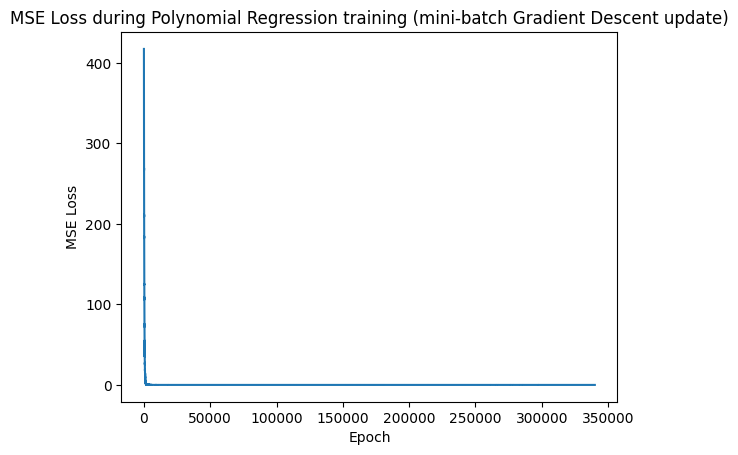

In [415]:
# Plot loss
plt.plot(train_loss_his)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MSE Loss during Polynomial Regression training (mini-batch Gradient Descent update)')
plt.show()

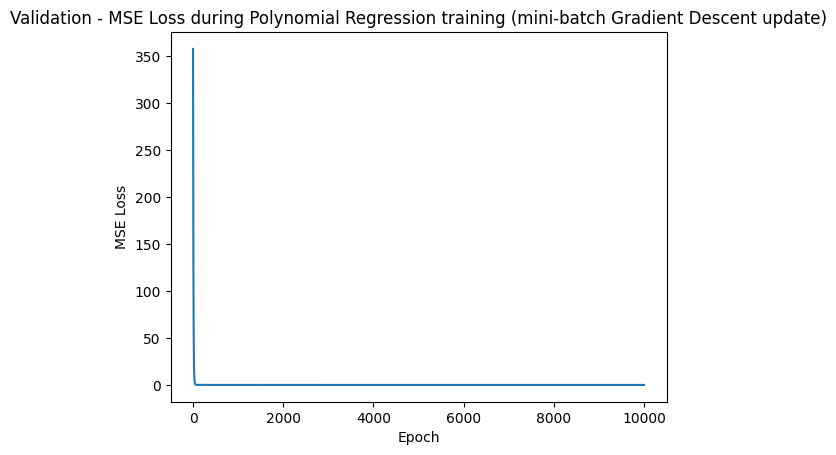

In [416]:
# Plot loss
plt.plot(val_loss_his)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Validation - MSE Loss during Polynomial Regression training (mini-batch Gradient Descent update)')
plt.show()

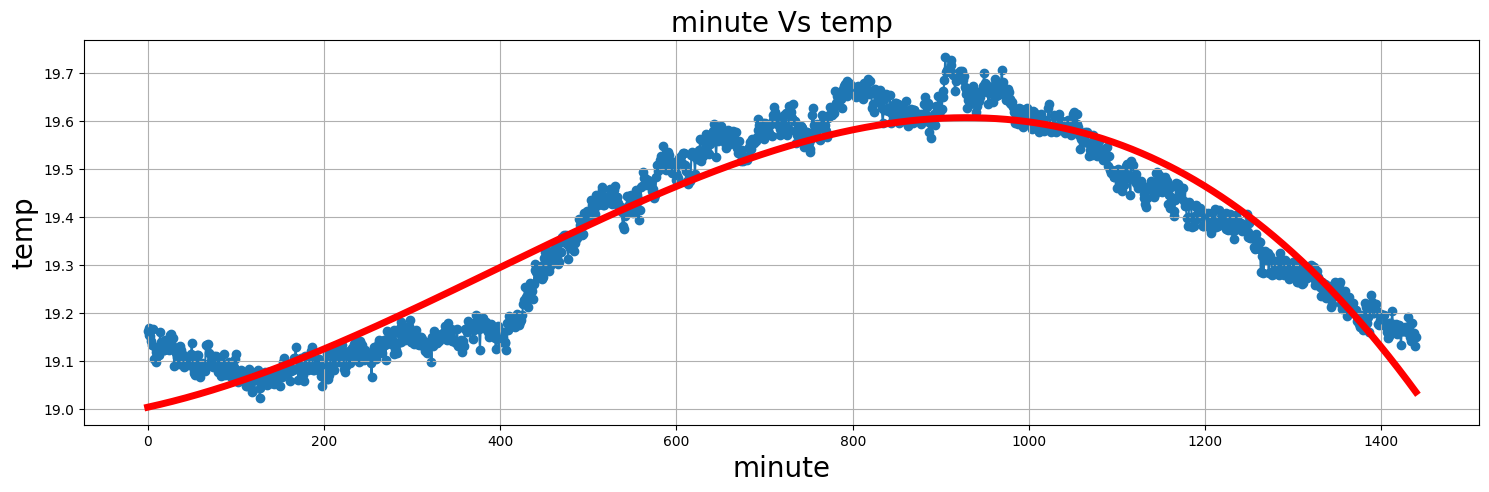

In [417]:
y2_pred = np.dot(X2, w2) + b2
SensorVizWithPrediction(df_pair2, feature_X, feature_y, y2_pred)

Rsquare2 : 0.9159215326900108
Mean Square Error : 0.0035754855221274296
Root Mean Square Error : 0.059795363717661504
Mean Absolute Error : 0.04891215129672295


<Figure size 2000x500 with 0 Axes>

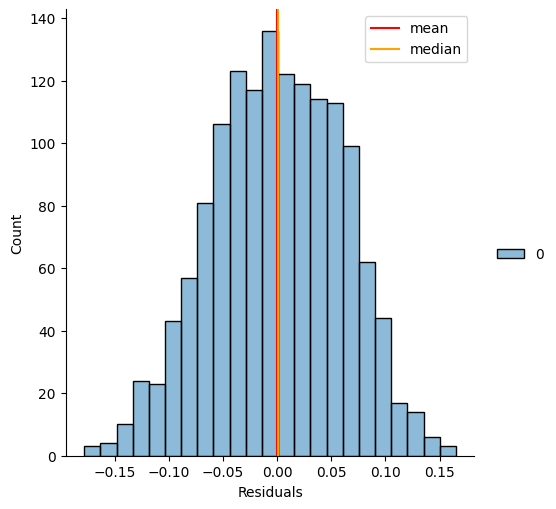

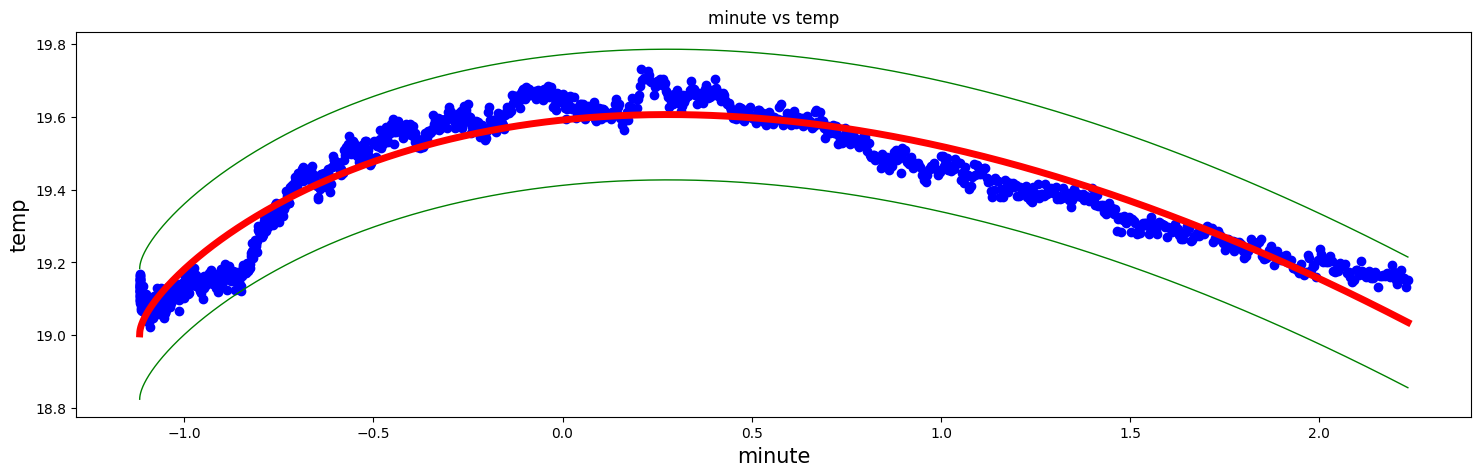

In [418]:
assess_model(X2[:, 1], y2, y2_pred, feature_X='minute', feature_y='temp')

Pair 3: hour and temp

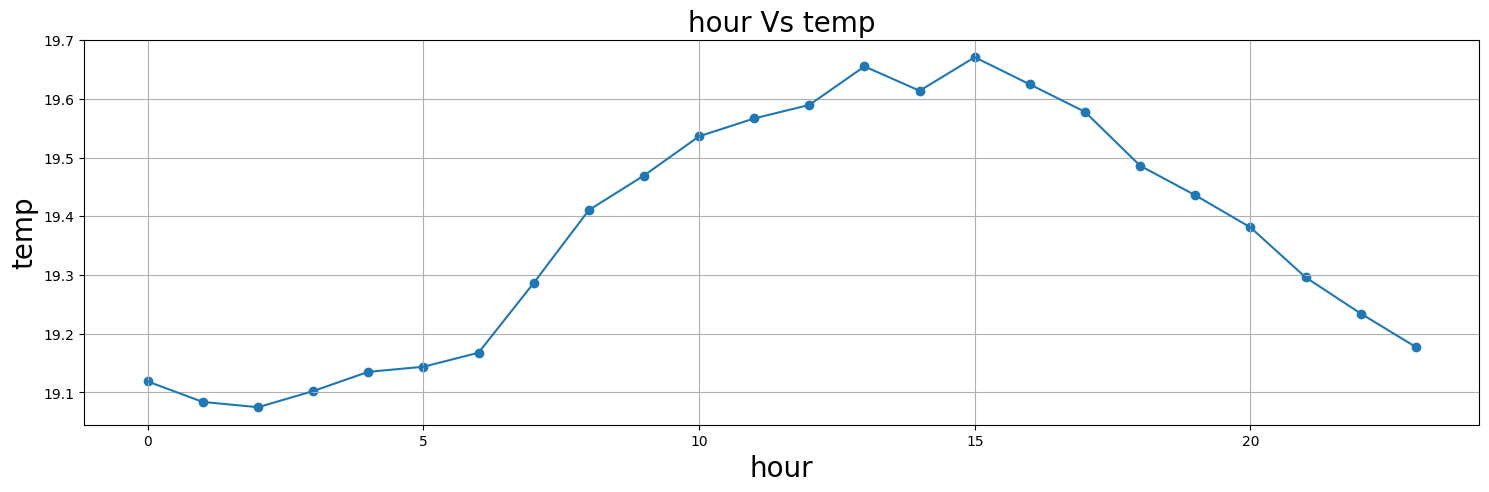

In [419]:
feature_y = 'temp'
feature_X = 'hour'

df_pair3 = features[[feature_X, feature_y]].groupby(feature_X, as_index=False).mean()
SensorViz(df_pair3, feature_X, feature_y)

In [420]:
# Define hyper-parameters for training model
epochs = 10000
learning_rate = 0.001
degree = 3
batch_size = 32
patience = 5 # for early stopping

# Prepare data for training
X3 = df_pair3[[feature_X]].values
y3 = df_pair3[[feature_y]].values.reshape(-1, 1)

print(type(X3), X3.shape, type(y3), y3.shape)
X3 = add_features(x=X3, degree=degree)
X3 = normalize(x=X3)

# Fit model (training)
w3, b3, train_loss_his, val_loss_his = poly_reg_fit(X3, y3,
                                                    lr=learning_rate,
                                                    epochs=epochs,
                                                    batch_size=batch_size,
                                                    patience=patience)

<class 'numpy.ndarray'> (24, 1) <class 'numpy.ndarray'> (24, 1)


  3%|▎         | 252/10000 [00:00<00:04, 2353.12it/s]

Epoch 0 | train_loss=388.050 | val_loss=382.982
Epoch 1 | train_loss=386.498 | val_loss=381.452
Epoch 2 | train_loss=384.952 | val_loss=379.928
Epoch 3 | train_loss=383.412 | val_loss=378.410
Epoch 4 | train_loss=381.878 | val_loss=376.898
Epoch 5 | train_loss=380.350 | val_loss=375.392
Epoch 6 | train_loss=378.828 | val_loss=373.892
Epoch 7 | train_loss=377.313 | val_loss=372.398
Epoch 8 | train_loss=375.803 | val_loss=370.910
Epoch 9 | train_loss=374.300 | val_loss=369.428
Epoch 10 | train_loss=372.802 | val_loss=367.952
Epoch 11 | train_loss=371.311 | val_loss=366.482
Epoch 12 | train_loss=369.825 | val_loss=365.017
Epoch 13 | train_loss=368.346 | val_loss=363.559
Epoch 14 | train_loss=366.872 | val_loss=362.106
Epoch 15 | train_loss=365.404 | val_loss=360.659
Epoch 16 | train_loss=363.943 | val_loss=359.218
Epoch 17 | train_loss=362.487 | val_loss=357.783
Epoch 18 | train_loss=361.037 | val_loss=356.353
Epoch 19 | train_loss=359.592 | val_loss=354.930
Epoch 20 | train_loss=358.154 

  7%|▋         | 682/10000 [00:00<00:02, 3464.64it/s]


Epoch 638 | train_loss=30.113 | val_loss=29.689
Epoch 639 | train_loss=29.992 | val_loss=29.570
Epoch 640 | train_loss=29.872 | val_loss=29.451
Epoch 641 | train_loss=29.753 | val_loss=29.334
Epoch 642 | train_loss=29.634 | val_loss=29.216
Epoch 643 | train_loss=29.516 | val_loss=29.099
Epoch 644 | train_loss=29.398 | val_loss=28.983
Epoch 645 | train_loss=29.280 | val_loss=28.866
Epoch 646 | train_loss=29.163 | val_loss=28.751
Epoch 647 | train_loss=29.047 | val_loss=28.636
Epoch 648 | train_loss=28.930 | val_loss=28.521
Epoch 649 | train_loss=28.815 | val_loss=28.407
Epoch 650 | train_loss=28.700 | val_loss=28.293
Epoch 651 | train_loss=28.585 | val_loss=28.180
Epoch 652 | train_loss=28.471 | val_loss=28.067
Epoch 653 | train_loss=28.357 | val_loss=27.954
Epoch 654 | train_loss=28.244 | val_loss=27.843
Epoch 655 | train_loss=28.131 | val_loss=27.731
Epoch 656 | train_loss=28.018 | val_loss=27.620
Epoch 657 | train_loss=27.906 | val_loss=27.509
Epoch 658 | train_loss=27.795 | val_los

 11%|█         | 1116/10000 [00:00<00:02, 3728.06it/s]

Epoch 682 | train_loss=25.247 | val_loss=24.883
Epoch 683 | train_loss=25.147 | val_loss=24.784
Epoch 684 | train_loss=25.046 | val_loss=24.684
Epoch 685 | train_loss=24.946 | val_loss=24.586
Epoch 686 | train_loss=24.846 | val_loss=24.487
Epoch 687 | train_loss=24.747 | val_loss=24.389
Epoch 688 | train_loss=24.648 | val_loss=24.291
Epoch 689 | train_loss=24.549 | val_loss=24.194
Epoch 690 | train_loss=24.451 | val_loss=24.097
Epoch 691 | train_loss=24.354 | val_loss=24.001
Epoch 692 | train_loss=24.256 | val_loss=23.904
Epoch 693 | train_loss=24.159 | val_loss=23.809
Epoch 694 | train_loss=24.063 | val_loss=23.713
Epoch 695 | train_loss=23.967 | val_loss=23.618
Epoch 696 | train_loss=23.871 | val_loss=23.524
Epoch 697 | train_loss=23.775 | val_loss=23.430
Epoch 698 | train_loss=23.680 | val_loss=23.336
Epoch 699 | train_loss=23.586 | val_loss=23.242
Epoch 700 | train_loss=23.491 | val_loss=23.149
Epoch 701 | train_loss=23.398 | val_loss=23.056
Epoch 702 | train_loss=23.304 | val_loss

 20%|█▉        | 1995/10000 [00:00<00:02, 3331.70it/s]

Epoch 1587 | train_loss=0.680 | val_loss=0.659
Epoch 1588 | train_loss=0.678 | val_loss=0.656
Epoch 1589 | train_loss=0.675 | val_loss=0.653
Epoch 1590 | train_loss=0.672 | val_loss=0.651
Epoch 1591 | train_loss=0.670 | val_loss=0.648
Epoch 1592 | train_loss=0.667 | val_loss=0.646
Epoch 1593 | train_loss=0.664 | val_loss=0.643
Epoch 1594 | train_loss=0.662 | val_loss=0.640
Epoch 1595 | train_loss=0.659 | val_loss=0.638
Epoch 1596 | train_loss=0.657 | val_loss=0.635
Epoch 1597 | train_loss=0.654 | val_loss=0.633
Epoch 1598 | train_loss=0.651 | val_loss=0.630
Epoch 1599 | train_loss=0.649 | val_loss=0.628
Epoch 1600 | train_loss=0.646 | val_loss=0.625
Epoch 1601 | train_loss=0.644 | val_loss=0.623
Epoch 1602 | train_loss=0.641 | val_loss=0.620
Epoch 1603 | train_loss=0.639 | val_loss=0.618
Epoch 1604 | train_loss=0.636 | val_loss=0.615
Epoch 1605 | train_loss=0.634 | val_loss=0.613
Epoch 1606 | train_loss=0.631 | val_loss=0.611
Epoch 1607 | train_loss=0.629 | val_loss=0.608
Epoch 1608 | 

 23%|██▎       | 2346/10000 [00:00<00:02, 2954.32it/s]

Epoch 2183 | train_loss=0.069 | val_loss=0.065
Epoch 2184 | train_loss=0.069 | val_loss=0.065
Epoch 2185 | train_loss=0.069 | val_loss=0.065
Epoch 2186 | train_loss=0.069 | val_loss=0.065
Epoch 2187 | train_loss=0.068 | val_loss=0.065
Epoch 2188 | train_loss=0.068 | val_loss=0.064
Epoch 2189 | train_loss=0.068 | val_loss=0.064
Epoch 2190 | train_loss=0.068 | val_loss=0.064
Epoch 2191 | train_loss=0.067 | val_loss=0.064
Epoch 2192 | train_loss=0.067 | val_loss=0.063
Epoch 2193 | train_loss=0.067 | val_loss=0.063
Epoch 2194 | train_loss=0.067 | val_loss=0.063
Epoch 2195 | train_loss=0.067 | val_loss=0.063
Epoch 2196 | train_loss=0.066 | val_loss=0.062
Epoch 2197 | train_loss=0.066 | val_loss=0.062
Epoch 2198 | train_loss=0.066 | val_loss=0.062
Epoch 2199 | train_loss=0.066 | val_loss=0.062
Epoch 2200 | train_loss=0.065 | val_loss=0.062
Epoch 2201 | train_loss=0.065 | val_loss=0.061
Epoch 2202 | train_loss=0.065 | val_loss=0.061
Epoch 2203 | train_loss=0.065 | val_loss=0.061
Epoch 2204 | 

 31%|███       | 3069/10000 [00:00<00:02, 3179.67it/s]


Epoch 2739 | train_loss=0.014 | val_loss=0.013
Epoch 2740 | train_loss=0.014 | val_loss=0.013
Epoch 2741 | train_loss=0.014 | val_loss=0.013
Epoch 2742 | train_loss=0.014 | val_loss=0.013
Epoch 2743 | train_loss=0.014 | val_loss=0.013
Epoch 2744 | train_loss=0.014 | val_loss=0.013
Epoch 2745 | train_loss=0.014 | val_loss=0.013
Epoch 2746 | train_loss=0.014 | val_loss=0.013
Epoch 2747 | train_loss=0.014 | val_loss=0.013
Epoch 2748 | train_loss=0.014 | val_loss=0.013
Epoch 2749 | train_loss=0.014 | val_loss=0.013
Epoch 2750 | train_loss=0.013 | val_loss=0.013
Epoch 2751 | train_loss=0.013 | val_loss=0.013
Epoch 2752 | train_loss=0.013 | val_loss=0.013
Epoch 2753 | train_loss=0.013 | val_loss=0.013
Epoch 2754 | train_loss=0.013 | val_loss=0.013
Epoch 2755 | train_loss=0.013 | val_loss=0.013
Epoch 2756 | train_loss=0.013 | val_loss=0.013
Epoch 2757 | train_loss=0.013 | val_loss=0.013
Epoch 2758 | train_loss=0.013 | val_loss=0.013
Epoch 2759 | train_loss=0.013 | val_loss=0.013
Epoch 2760 |

 40%|████      | 4042/10000 [00:01<00:01, 3225.88it/s]

Epoch 3379 | train_loss=0.007 | val_loss=0.008
Epoch 3380 | train_loss=0.007 | val_loss=0.008
Epoch 3381 | train_loss=0.007 | val_loss=0.008
Epoch 3382 | train_loss=0.007 | val_loss=0.008
Epoch 3383 | train_loss=0.007 | val_loss=0.008
Epoch 3384 | train_loss=0.007 | val_loss=0.008
Epoch 3385 | train_loss=0.007 | val_loss=0.008
Epoch 3386 | train_loss=0.007 | val_loss=0.008
Epoch 3387 | train_loss=0.007 | val_loss=0.008
Epoch 3388 | train_loss=0.007 | val_loss=0.008
Epoch 3389 | train_loss=0.007 | val_loss=0.008
Epoch 3390 | train_loss=0.007 | val_loss=0.008
Epoch 3391 | train_loss=0.007 | val_loss=0.008
Epoch 3392 | train_loss=0.007 | val_loss=0.008
Epoch 3393 | train_loss=0.007 | val_loss=0.008
Epoch 3394 | train_loss=0.007 | val_loss=0.008
Epoch 3395 | train_loss=0.007 | val_loss=0.008
Epoch 3396 | train_loss=0.007 | val_loss=0.008
Epoch 3397 | train_loss=0.007 | val_loss=0.008
Epoch 3398 | train_loss=0.007 | val_loss=0.008
Epoch 3399 | train_loss=0.007 | val_loss=0.008
Epoch 3400 | 

In [421]:
print('Weights: ', w3)
print('Bias: ', b3)

Weights:  [[ 0.44646025]
 [-0.12479285]
 [-0.2469042 ]]
Bias:  [19.3623096]


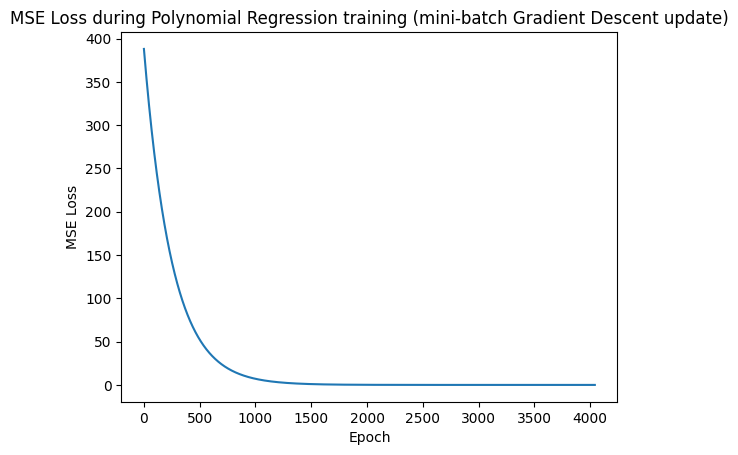

In [422]:
# Plot loss
plt.plot(train_loss_his)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MSE Loss during Polynomial Regression training (mini-batch Gradient Descent update)')
plt.show()

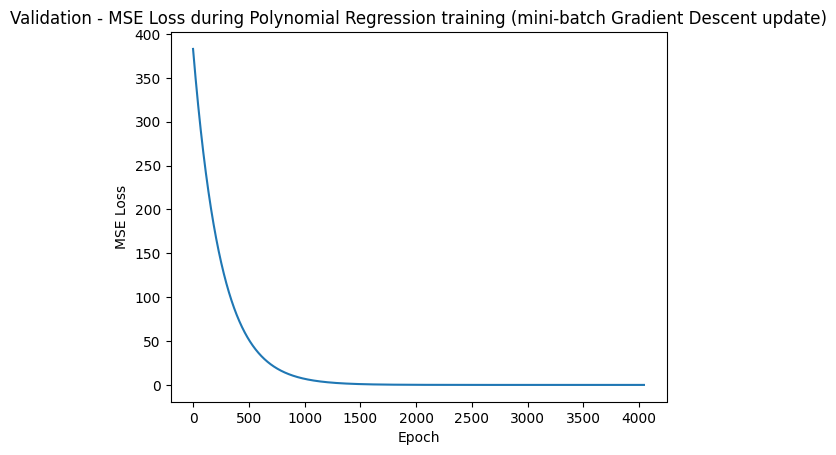

In [423]:
# Plot loss
plt.plot(val_loss_his)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Validation - MSE Loss during Polynomial Regression training (mini-batch Gradient Descent update)')
plt.show()

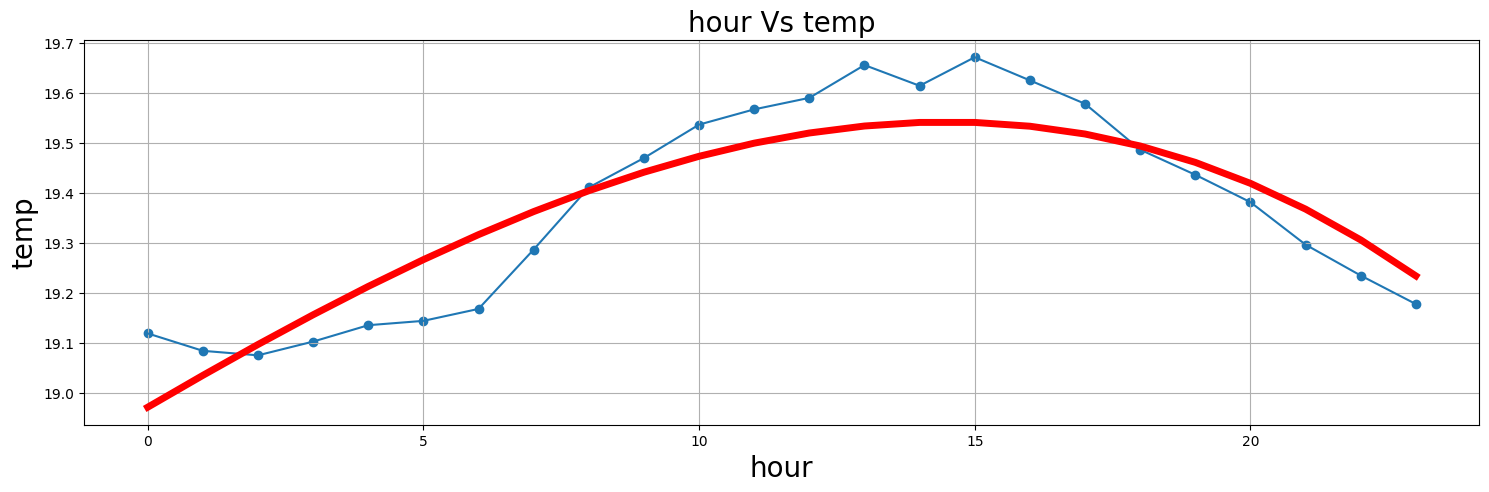

In [424]:
y3_pred = np.dot(X3, w3) + b3
SensorVizWithPrediction(df_pair3, feature_X, feature_y, y3_pred)

Rsquare2 : 0.8449922962612624
Mean Square Error : 0.006476684042516952
Root Mean Square Error : 0.08047784814790311
Mean Absolute Error : 0.06995046469701105


<Figure size 2000x500 with 0 Axes>

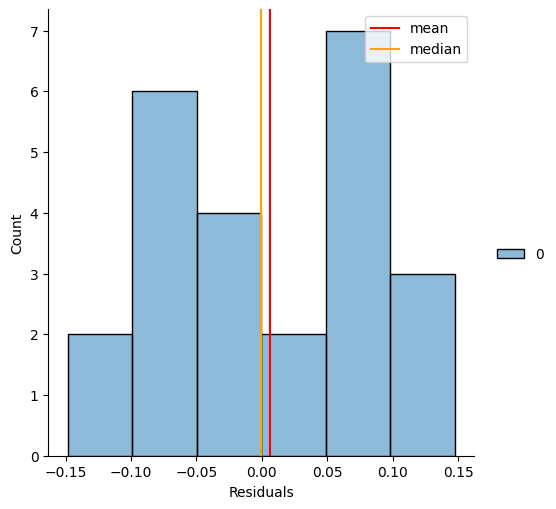

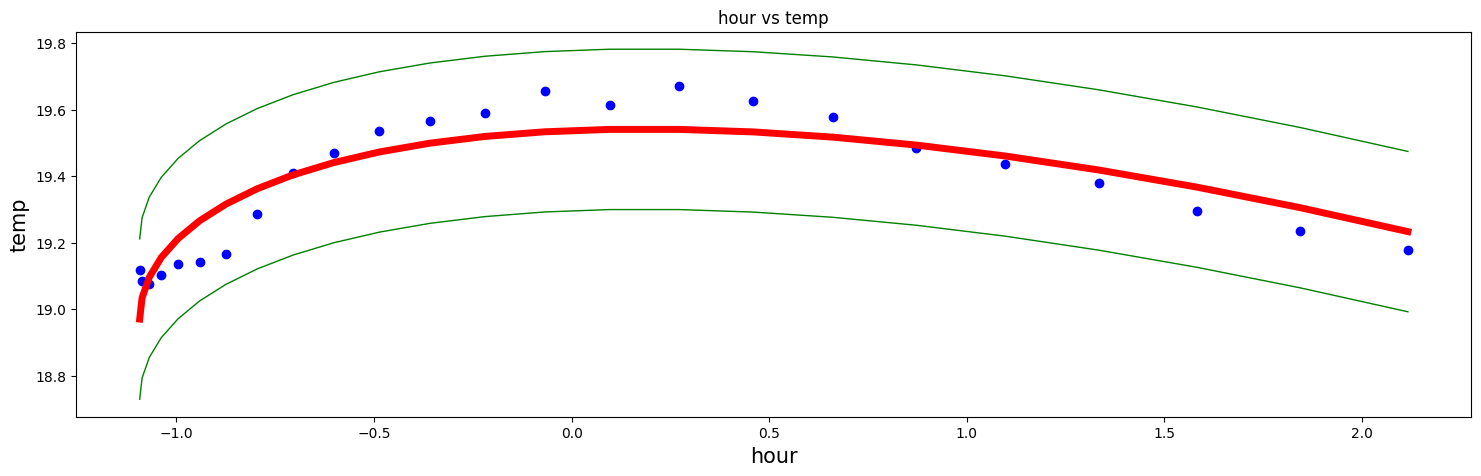

In [425]:
assess_model(X3[:, 1], y3, y3_pred, feature_X='hour', feature_y='temp')

Pair 4: month and temp

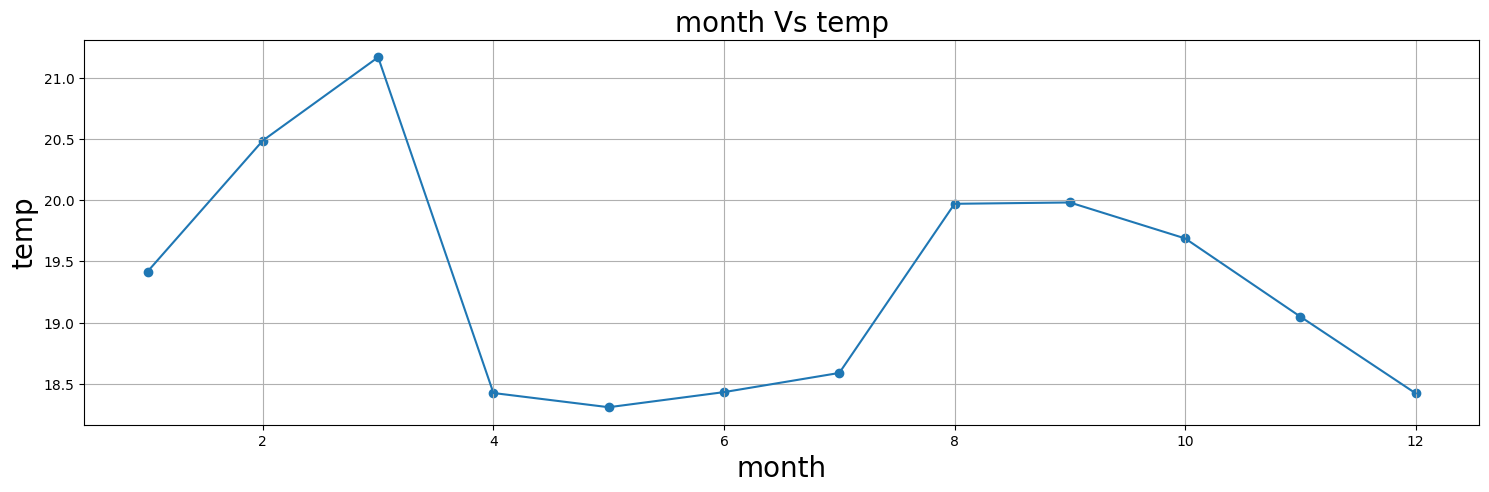

In [426]:
feature_y = 'temp'
feature_X = 'month'

df_pair4 = features[[feature_X, feature_y]].groupby(feature_X, as_index=False).mean()
SensorViz(df_pair4, feature_X, feature_y)

In [442]:
# Define hyper-parameters for training model
epochs = 10000
learning_rate = 0.001
degree = 6
batch_size = 32
patience = 5 # for early stopping

# Prepare data for training
X4 = df_pair4[[feature_X]].values
y4 = df_pair4[[feature_y]].values.reshape(-1, 1)

print(type(X4), X4.shape, type(y4), y4.shape)
X4 = add_features(x=X4, degree=degree)
X4 = normalize(x=X4)

# Fit model (training)
w4, b4, train_loss_his, val_loss_his = poly_reg_fit(X4, y4,
                                                    lr=learning_rate,
                                                    epochs=epochs,
                                                    batch_size=batch_size,
                                                    patience=patience)

<class 'numpy.ndarray'> (12, 1) <class 'numpy.ndarray'> (12, 1)


  2%|▏         | 180/10000 [00:00<00:05, 1798.23it/s]

Epoch 0 | train_loss=407.741 | val_loss=371.558
Epoch 1 | train_loss=406.104 | val_loss=369.979
Epoch 2 | train_loss=404.473 | val_loss=368.407
Epoch 3 | train_loss=402.849 | val_loss=366.842
Epoch 4 | train_loss=401.232 | val_loss=365.284
Epoch 5 | train_loss=399.621 | val_loss=363.732
Epoch 6 | train_loss=398.017 | val_loss=362.188
Epoch 7 | train_loss=396.420 | val_loss=360.650
Epoch 8 | train_loss=394.829 | val_loss=359.118
Epoch 9 | train_loss=393.245 | val_loss=357.594
Epoch 10 | train_loss=391.668 | val_loss=356.076
Epoch 11 | train_loss=390.096 | val_loss=354.564
Epoch 12 | train_loss=388.532 | val_loss=353.059
Epoch 13 | train_loss=386.973 | val_loss=351.561
Epoch 14 | train_loss=385.422 | val_loss=350.069
Epoch 15 | train_loss=383.876 | val_loss=348.583
Epoch 16 | train_loss=382.337 | val_loss=347.104
Epoch 17 | train_loss=380.804 | val_loss=345.632
Epoch 18 | train_loss=379.278 | val_loss=344.165
Epoch 19 | train_loss=377.757 | val_loss=342.705
Epoch 20 | train_loss=376.243 

  4%|▎         | 372/10000 [00:00<00:05, 1869.54it/s]

Epoch 342 | train_loss=103.975 | val_loss=85.679
Epoch 343 | train_loss=103.562 | val_loss=85.305
Epoch 344 | train_loss=103.151 | val_loss=84.932
Epoch 345 | train_loss=102.741 | val_loss=84.560
Epoch 346 | train_loss=102.333 | val_loss=84.191
Epoch 347 | train_loss=101.926 | val_loss=83.822
Epoch 348 | train_loss=101.521 | val_loss=83.456
Epoch 349 | train_loss=101.118 | val_loss=83.091
Epoch 350 | train_loss=100.716 | val_loss=82.727
Epoch 351 | train_loss=100.316 | val_loss=82.365
Epoch 352 | train_loss=99.918 | val_loss=82.005
Epoch 353 | train_loss=99.521 | val_loss=81.645
Epoch 354 | train_loss=99.126 | val_loss=81.288
Epoch 355 | train_loss=98.732 | val_loss=80.932
Epoch 356 | train_loss=98.340 | val_loss=80.578
Epoch 357 | train_loss=97.949 | val_loss=80.224
Epoch 358 | train_loss=97.560 | val_loss=79.873
Epoch 359 | train_loss=97.173 | val_loss=79.523
Epoch 360 | train_loss=96.787 | val_loss=79.174
Epoch 361 | train_loss=96.403 | val_loss=78.827
Epoch 362 | train_loss=96.020 

  7%|▋         | 746/10000 [00:00<00:04, 1861.80it/s]

Epoch 400 | train_loss=82.552 | val_loss=66.372
Epoch 401 | train_loss=82.225 | val_loss=66.078
Epoch 402 | train_loss=81.899 | val_loss=65.786
Epoch 403 | train_loss=81.574 | val_loss=65.496
Epoch 404 | train_loss=81.250 | val_loss=65.206
Epoch 405 | train_loss=80.928 | val_loss=64.918
Epoch 406 | train_loss=80.607 | val_loss=64.631
Epoch 407 | train_loss=80.287 | val_loss=64.345
Epoch 408 | train_loss=79.969 | val_loss=64.061
Epoch 409 | train_loss=79.652 | val_loss=63.777
Epoch 410 | train_loss=79.336 | val_loss=63.495
Epoch 411 | train_loss=79.021 | val_loss=63.214
Epoch 412 | train_loss=78.708 | val_loss=62.934
Epoch 413 | train_loss=78.396 | val_loss=62.656
Epoch 414 | train_loss=78.085 | val_loss=62.378
Epoch 415 | train_loss=77.775 | val_loss=62.102
Epoch 416 | train_loss=77.467 | val_loss=61.827
Epoch 417 | train_loss=77.160 | val_loss=61.553
Epoch 418 | train_loss=76.854 | val_loss=61.280
Epoch 419 | train_loss=76.549 | val_loss=61.008
Epoch 420 | train_loss=76.246 | val_loss

 11%|█▏        | 1133/10000 [00:00<00:04, 1832.60it/s]

Epoch 796 | train_loss=17.385 | val_loss=10.491
Epoch 797 | train_loss=17.318 | val_loss=10.439
Epoch 798 | train_loss=17.252 | val_loss=10.387
Epoch 799 | train_loss=17.185 | val_loss=10.335
Epoch 800 | train_loss=17.119 | val_loss=10.284
Epoch 801 | train_loss=17.053 | val_loss=10.233
Epoch 802 | train_loss=16.987 | val_loss=10.182
Epoch 803 | train_loss=16.921 | val_loss=10.132
Epoch 804 | train_loss=16.856 | val_loss=10.082
Epoch 805 | train_loss=16.791 | val_loss=10.031
Epoch 806 | train_loss=16.726 | val_loss=9.982
Epoch 807 | train_loss=16.662 | val_loss=9.932
Epoch 808 | train_loss=16.598 | val_loss=9.883
Epoch 809 | train_loss=16.534 | val_loss=9.833
Epoch 810 | train_loss=16.470 | val_loss=9.785
Epoch 811 | train_loss=16.407 | val_loss=9.736
Epoch 812 | train_loss=16.344 | val_loss=9.687
Epoch 813 | train_loss=16.281 | val_loss=9.639
Epoch 814 | train_loss=16.218 | val_loss=9.591
Epoch 815 | train_loss=16.156 | val_loss=9.543
Epoch 816 | train_loss=16.093 | val_loss=9.496
Epo

 15%|█▍        | 1498/10000 [00:00<00:04, 1801.76it/s]


Epoch 1202 | train_loss=3.896 | val_loss=1.185
Epoch 1203 | train_loss=3.883 | val_loss=1.178
Epoch 1204 | train_loss=3.870 | val_loss=1.172
Epoch 1205 | train_loss=3.857 | val_loss=1.165
Epoch 1206 | train_loss=3.844 | val_loss=1.159
Epoch 1207 | train_loss=3.831 | val_loss=1.152
Epoch 1208 | train_loss=3.818 | val_loss=1.146
Epoch 1209 | train_loss=3.805 | val_loss=1.139
Epoch 1210 | train_loss=3.792 | val_loss=1.133
Epoch 1211 | train_loss=3.779 | val_loss=1.127
Epoch 1212 | train_loss=3.766 | val_loss=1.121
Epoch 1213 | train_loss=3.754 | val_loss=1.114
Epoch 1214 | train_loss=3.741 | val_loss=1.108
Epoch 1215 | train_loss=3.729 | val_loss=1.102
Epoch 1216 | train_loss=3.716 | val_loss=1.096
Epoch 1217 | train_loss=3.703 | val_loss=1.090
Epoch 1218 | train_loss=3.691 | val_loss=1.084
Epoch 1219 | train_loss=3.679 | val_loss=1.078
Epoch 1220 | train_loss=3.666 | val_loss=1.072
Epoch 1221 | train_loss=3.654 | val_loss=1.066
Epoch 1222 | train_loss=3.642 | val_loss=1.060
Epoch 1223 |

 16%|█▌        | 1558/10000 [00:00<00:04, 1852.17it/s]

Epoch 1544 | train_loss=1.428 | val_loss=0.352
Epoch 1545 | train_loss=1.424 | val_loss=0.352
Epoch 1546 | train_loss=1.421 | val_loss=0.352
Epoch 1547 | train_loss=1.417 | val_loss=0.352
Epoch 1548 | train_loss=1.414 | val_loss=0.352
Epoch 1549 | train_loss=1.411 | val_loss=0.352
Epoch 1550 | train_loss=1.408 | val_loss=0.352
Epoch 1551 | train_loss=1.404 | val_loss=0.352
Epoch 1552 | train_loss=1.401 | val_loss=0.352
Epoch 1553 | train_loss=1.398 | val_loss=0.352
Epoch 1554 | train_loss=1.394 | val_loss=0.352
Epoch 1555 | train_loss=1.391 | val_loss=0.352
Epoch 1556 | train_loss=1.388 | val_loss=0.352
Epoch 1557 | train_loss=1.385 | val_loss=0.352
Epoch 1558 | train_loss=1.382 | val_loss=0.352
Early stopping at epoch 1558


In [443]:
print('Weights: ', w4)
print('Bias: ', b4)

Weights:  [[-0.44952946]
 [-1.36856224]
 [ 2.41438116]
 [-0.09212105]
 [-0.56092091]
 [-0.40009869]]
Bias:  [18.65690901]


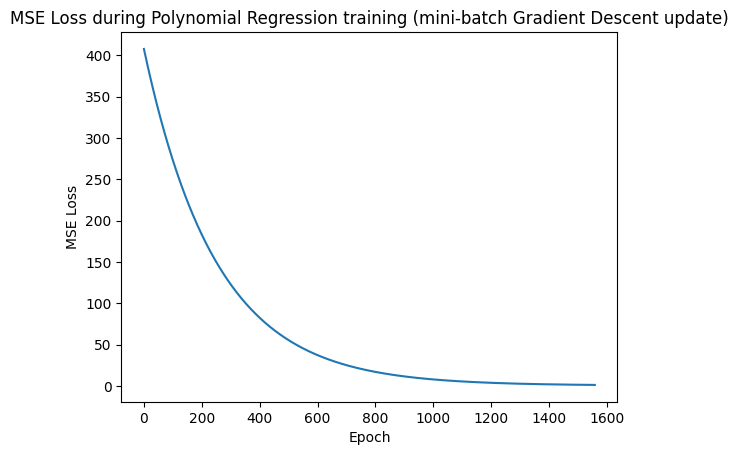

In [444]:
# Plot loss
plt.plot(train_loss_his)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('MSE Loss during Polynomial Regression training (mini-batch Gradient Descent update)')
plt.show()

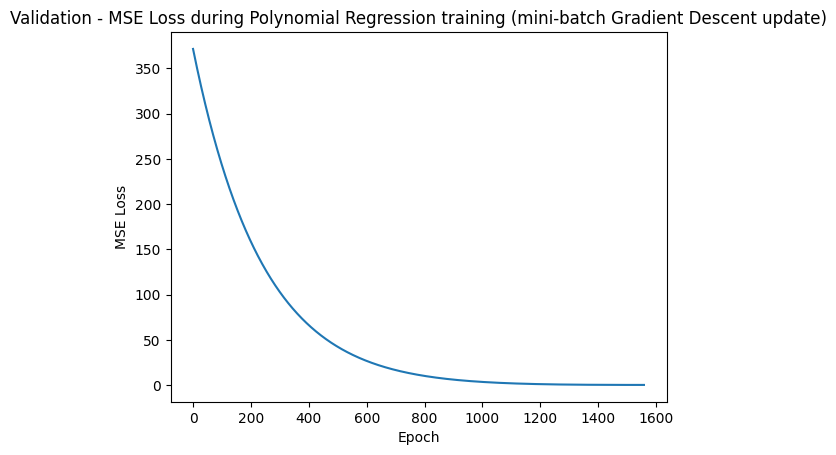

In [445]:
# Plot loss
plt.plot(val_loss_his)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Validation - MSE Loss during Polynomial Regression training (mini-batch Gradient Descent update)')
plt.show()

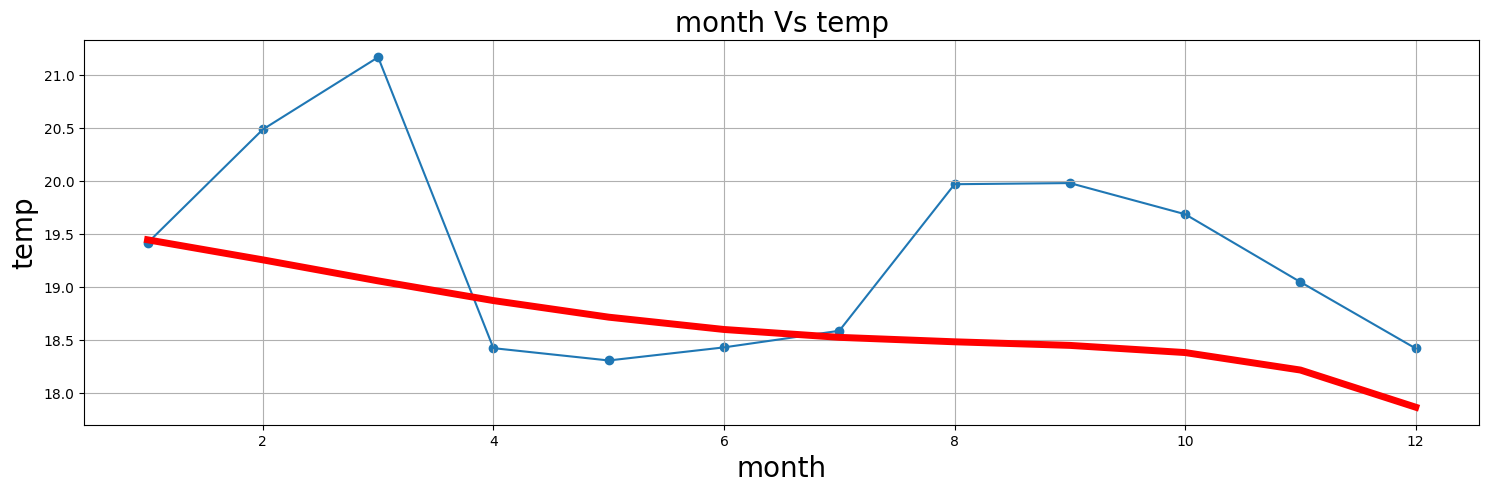

In [446]:
y4_pred = np.dot(X4, w4) + b4
SensorVizWithPrediction(df_pair4, feature_X, feature_y, y4_pred)

Rsquare2 : -0.3871118214255953
Mean Square Error : 1.1338108835555853
Root Mean Square Error : 1.0648055613846057
Mean Absolute Error : 0.8466359693081399


<Figure size 2000x500 with 0 Axes>

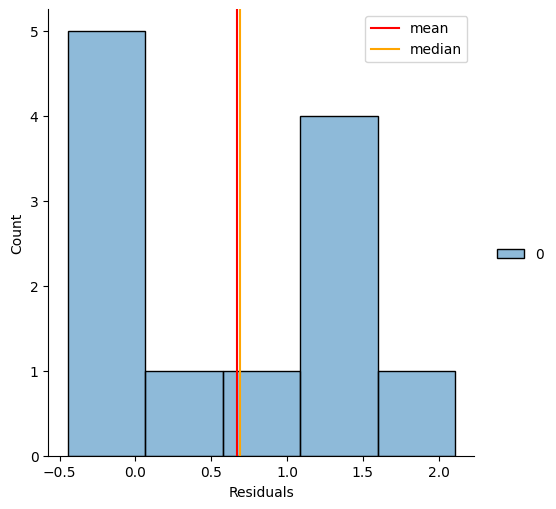

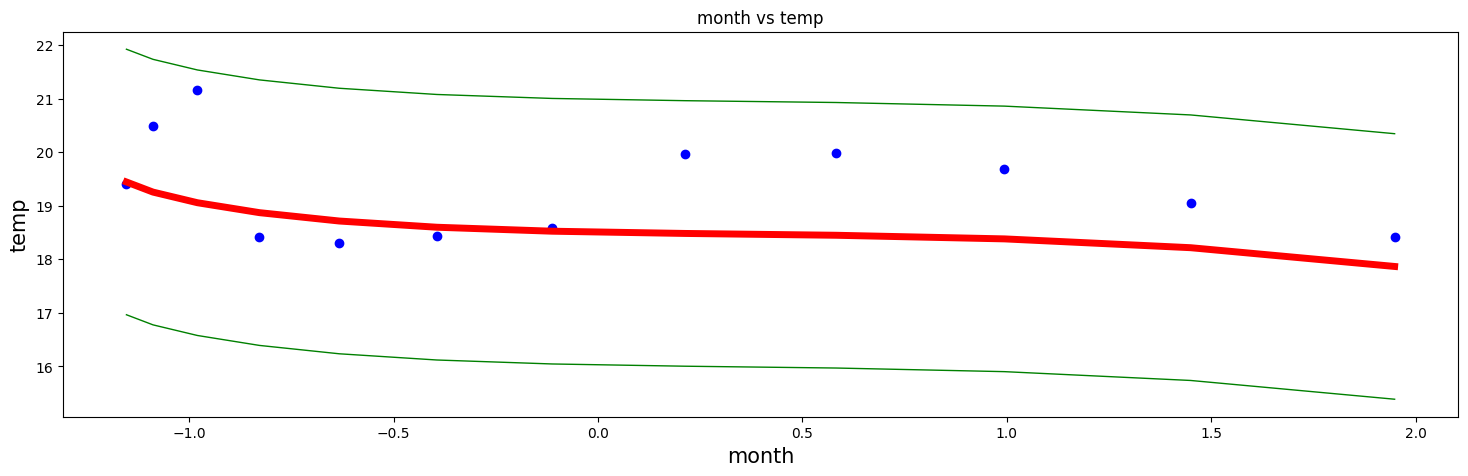

In [447]:
assess_model(X4[:, 1], y4, y4_pred, feature_X='month', feature_y='temp')